In [375]:
!!ln -s ../common.py ./common.py

["ln: failed to create symbolic link './common.py': File exists"]

In [376]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from common import *
import torchvision
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [377]:
''' Options for console output '''
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 200)

In [378]:
''' Read Data from csv file and store in dataframe df '''
df = pd.read_csv('../Data-Files/T0_without_pcm.csv')
df_with_pm = pd.read_csv('../Data-Files/After_cleaning/T0_data_without_missing_rows.csv').set_index('Respondentnummer')
df_learning_lab = pd.read_csv('../Data-Files/marketing_campaign.csv', sep=None, engine='python').set_index('ID')

In [379]:
''' 
    Function to get name of every column where the dtype is object and append it to a list
    returns the list with column names 
'''

def getObjectColumns(df):
    object_cols_array = []
    for col in df.columns:
        if df[col].dtype == 'object':
            object_cols_array.append(col)
    return object_cols_array          

In [380]:
''' 
    Function for removing features with more than n% missing values 
    returns dataframe with features where less than n% values are missing
'''

def removeColumnsWithMoreThanNValuesMissing(df, n):
    for col in df.columns:
        if df[col].isna().sum() >= (n*len(df)):
            df.drop(labels=col, axis=1, inplace=True)
    return df           

In [381]:
''' 
    Function for encoding columns with dtype object 
    returns dataframe with encoded features
'''

def encodeObjectColumns(df, encoder, object_cols_list):
    if len(object_cols_list) > 0:
        df[object_cols_list] = df[object_cols_list].apply(encoder.fit_transform)
    return df    

In [382]:
''' Function for scaling data and return scaled dataframe '''
def scaleData(scaler, df):
    scaled_data = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
    return scaled_df

In [383]:
'''
    Function to unscale data for better reading/understanding
    returns unscaled dataframe
'''
def unscaleData(scaler, df):
    dfUnscaled = scaler.inverse_transform(df)
    dfUnscaled = pd.DataFrame(dfUnscaled, columns=df.columns)
    return dfUnscaled

In [384]:
'''
    name of hyperparameter = description (min value, max values) 
    n_components = Dimension of space / default = 2
    perplexity = number of nearest neighbors (5,50) / default = 30.0
    early_exaggeration = tightness of clusters (no values) / default = 12.0
    learning_rate = "Zoom" (10.0, 1000.0) / default = 200.0
    n_iter = max number of iterations for optimization (250, no value) / default = 1000
    n_iter_without_progress = number of iterations without progress (n*50) / default = 300
    min_grad_norm = gradient norm when below this value stop optimization (no values) / default = 1e-7
    metric = used metric for calculating distance (no values) / default = 'euclidean'
    init = initialization of embedding ('random', 'pca') / default = 'random'
    verbose = verbosity level (no values) / default = 0
    random_state = random number generator (no values) / default = None
    method = gradient calculation algorithm (no values) / default = 'barnes_hut'
    angle = used if method = 'barnes_hut' / default = 0.5
    n_jobs = number of parallel jobs running (no values) / default = None
    square_distances = tsne squares the distances (no values) / default = 'legacy'/True

'''
def calculateTSNE(df, n_comp, perplex, exag, lrate, random_state, n_iter, n_iter_wo_pr, norm, 
metric, init, verb, method , angle, n_jobs, sq_dist):
    tsne = TSNE(n_components=n_comp, perplexity=perplex, early_exaggeration=exag, 
    learning_rate=lrate, n_iter=n_iter, n_iter_without_progress=n_iter_wo_pr, 
    min_grad_norm=norm, metric= metric, init=init, verbose=verb, random_state=random_state,
    method=method, angle=angle, n_jobs=n_jobs, square_distances= sq_dist)
    df_tsne = df.copy()
    print('\n TSNE: ',df_tsne.info())
    tsne_fit = tsne.fit_transform(df_tsne)
    print('\n tsne fit: ', tsne_fit)
    df_tsne['tsne_x'] = tsne_fit[:,0]
    df_tsne['tsne_y'] = tsne_fit[:,1]
    print('\n df TSNE:',df_tsne.info())
    return tsne_fit

In [385]:
def tuneHyperparametersTsne(df, scaled_df,  n_components, perplexity, early_exaggeration, learning_rate, random_state, n_iter, n_iter_without_progress, min_grad_norm =1e-7, 
metric = 'euclidean', init = 'random', verbose=0, method = 'barnes_hut', angle = 0.5, n_jobs = None, square_distances = True):
    print('Hyperparameters: ',df.info())
    tsne_fit = calculateTSNE(df=scaled_df, n_comp=n_components, perplex=perplexity, exag=early_exaggeration, lrate=learning_rate, random_state=random_state, n_iter=n_iter, n_iter_wo_pr=n_iter_without_progress, 
    norm=min_grad_norm, metric=metric, init=init, verb=verbose, method=method, angle=angle, n_jobs=n_jobs, sq_dist=square_distances)
    df['tsne_x'] = tsne_fit[:,0]
    df['tsne_y'] = tsne_fit[:,1]
    print(df.info())
    return df

In [386]:
def plotTsneAndSaveToFiles(df, df_name):

    for col in df.columns:
        if not 'tsne' in col:
         
            plt.figure(figsize=(16, 12))
            color = sns.color_palette('colorblind')
            #sns.palplot(color)
            sns.set_palette('bright')
            sns.scatterplot(x='tsne_x', y='tsne_y', hue=col,  data=df, alpha=0.4)
            if not '/' in col:
                plt.savefig('../Output-Files/TSNE-visualizations/Tsne_'+ df_name+col+'.pdf')
            else:
                column_name = col.replace('/', '_')
                plt.savefig('../Output-Files/TSNE-visualizations/Tsne_'+ df_name+column_name+'.pdf')   
            #plt.show()

In [387]:
print(df_with_pm.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 726 entries, 201110 to 310113
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Gender                        726 non-null    float64
 1   IC                            726 non-null    int64  
 2   Zip-code                      726 non-null    object 
 3   Geboortedatum                 726 non-null    object 
 4   Leeftijd (op testdag)         726 non-null    float64
 5   AST (tijd afgerond op 0.1s)   726 non-null    float64
 6   MQ                            726 non-null    float64
 7   MQ catogory                   726 non-null    float64
 8   Lengte (afgerond op 0.1 cm)   726 non-null    float64
 9   Gewicht (afgerond op 0.1 kg)  726 non-null    float64
 10  Lengte (in m)                 726 non-null    float64
 11  BMI                           726 non-null    float64
 12  Gymles                        726 non-null    float64
 1

In [388]:
scaler = StandardScaler()
le = LabelEncoder()
print(df_with_pm.info())
object_list = getObjectColumns(df_with_pm)
print(df_with_pm.info())
df_with_pm = encodeObjectColumns(df_with_pm, le, object_list)
print(df_with_pm.info())
df_with_pm.dropna(axis=0, inplace=True)
print(df_with_pm.info())
scaled_df = scaleData(scaler, df_with_pm)
print(df_with_pm.info())
print(scaled_df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 726 entries, 201110 to 310113
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Gender                        726 non-null    float64
 1   IC                            726 non-null    int64  
 2   Zip-code                      726 non-null    object 
 3   Geboortedatum                 726 non-null    object 
 4   Leeftijd (op testdag)         726 non-null    float64
 5   AST (tijd afgerond op 0.1s)   726 non-null    float64
 6   MQ                            726 non-null    float64
 7   MQ catogory                   726 non-null    float64
 8   Lengte (afgerond op 0.1 cm)   726 non-null    float64
 9   Gewicht (afgerond op 0.1 kg)  726 non-null    float64
 10  Lengte (in m)                 726 non-null    float64
 11  BMI                           726 non-null    float64
 12  Gymles                        726 non-null    float64
 1

In [389]:
'''
    DEFAULT VALUES
'''
n_comp=2 
perplex=30.0 
early_exag=12.0 
l_rate=200.0 
rstate=42 
n_i= 1000 
n_i_progress=300

In [390]:
n_comp=2 
perplex=30.0 
early_exag=12.0 
l_rate=200.0 
rstate=42 
n_i= 1000 
n_i_progress=500
print(df_with_pm.info())
df_learning_lab_n_iter_progress= tuneHyperparametersTsne(df=df_with_pm, scaled_df=scaled_df, n_components=n_comp, perplexity=perplex, early_exaggeration=early_exag, learning_rate=l_rate, 
random_state=rstate, n_iter= n_i, n_iter_without_progress=n_i_progress)
print('\n AFTER TSNE FFS: \n')
print(df_with_pm.info())
print(df_learning_lab_n_iter_progress.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 726 entries, 201110 to 310113
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Gender                        726 non-null    float64
 1   IC                            726 non-null    int64  
 2   Zip-code                      726 non-null    int64  
 3   Geboortedatum                 726 non-null    int64  
 4   Leeftijd (op testdag)         726 non-null    float64
 5   AST (tijd afgerond op 0.1s)   726 non-null    float64
 6   MQ                            726 non-null    float64
 7   MQ catogory                   726 non-null    float64
 8   Lengte (afgerond op 0.1 cm)   726 non-null    float64
 9   Gewicht (afgerond op 0.1 kg)  726 non-null    float64
 10  Lengte (in m)                 726 non-null    float64
 11  BMI                           726 non-null    float64
 12  Gymles                        726 non-null    float64
 1

/tmp/ipykernel_36906/3569143405.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(16, 12))


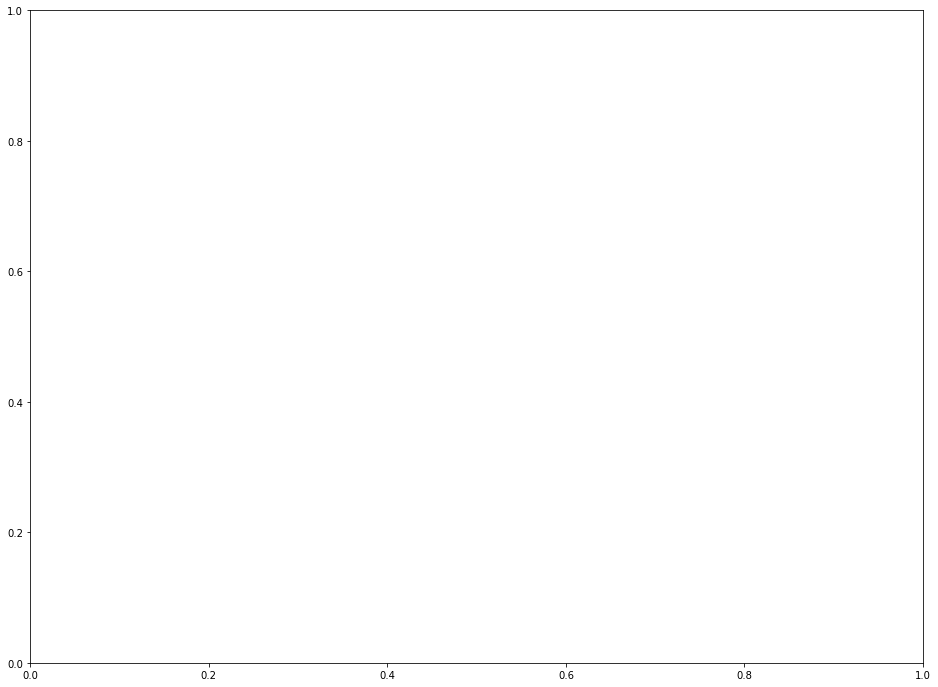

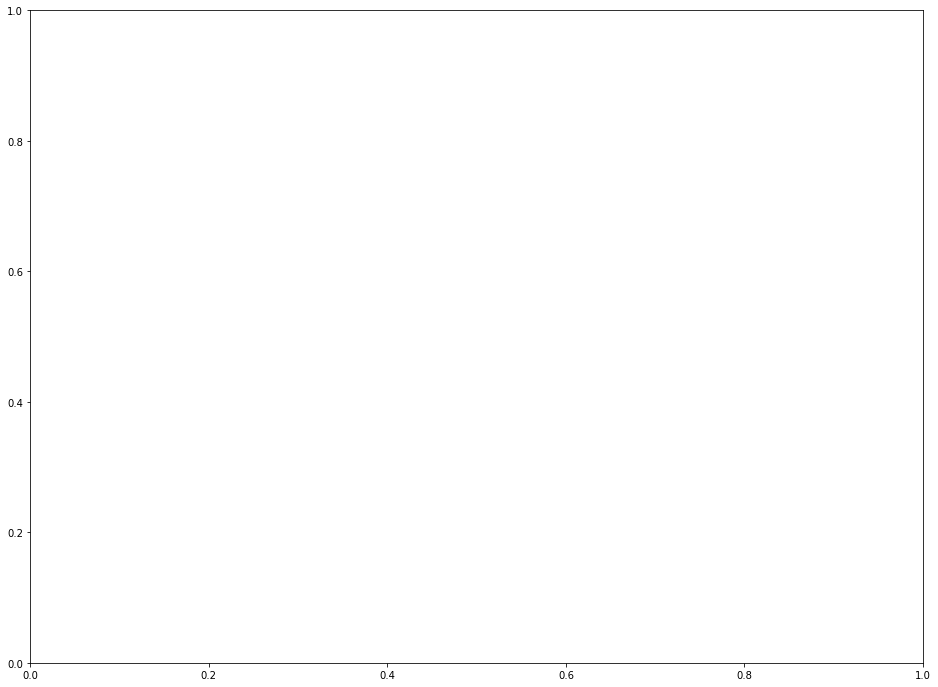

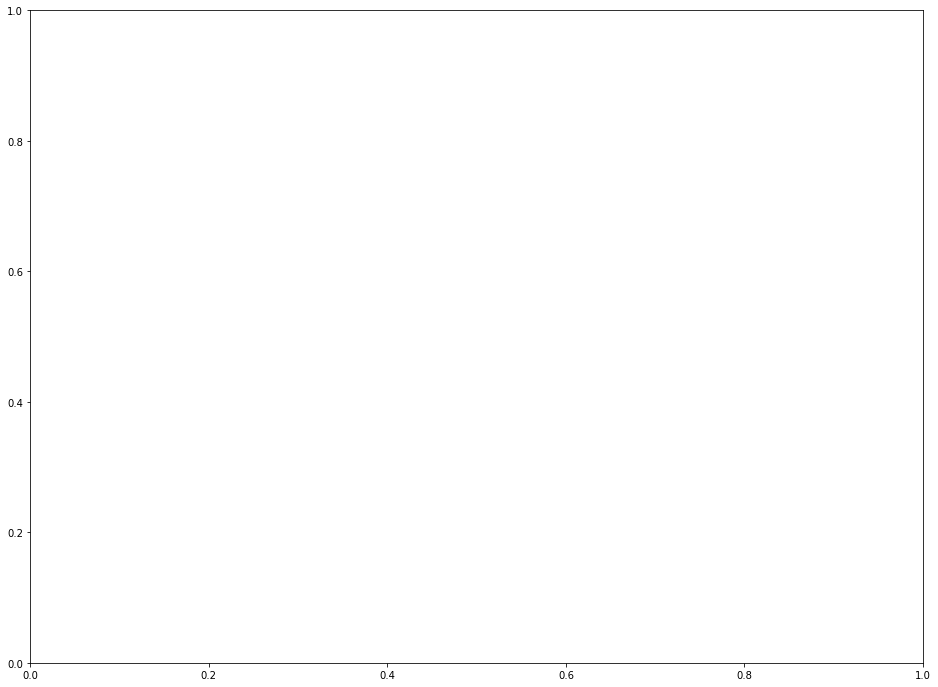

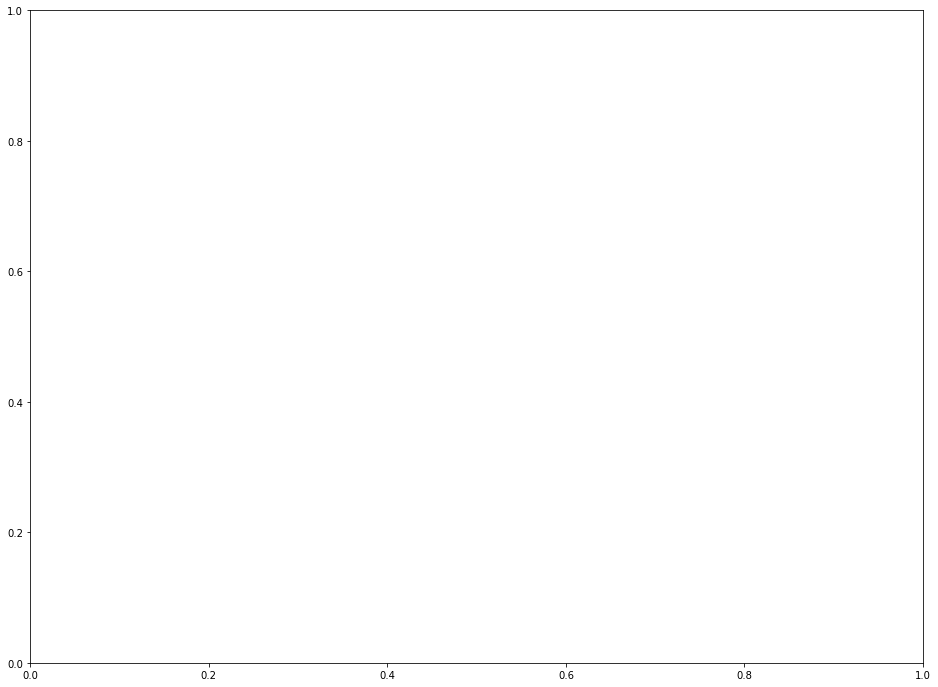

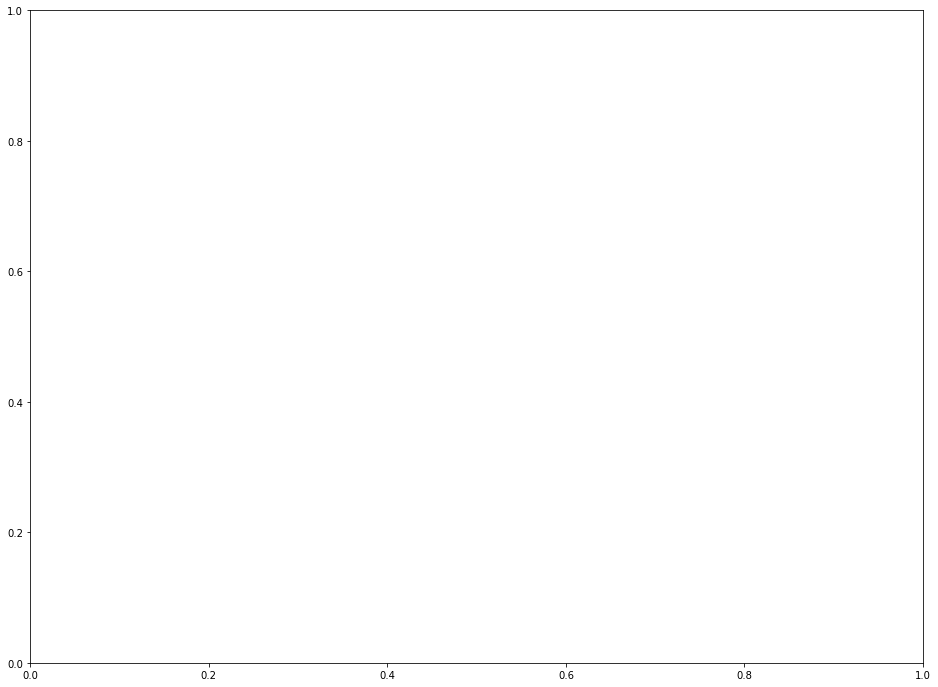

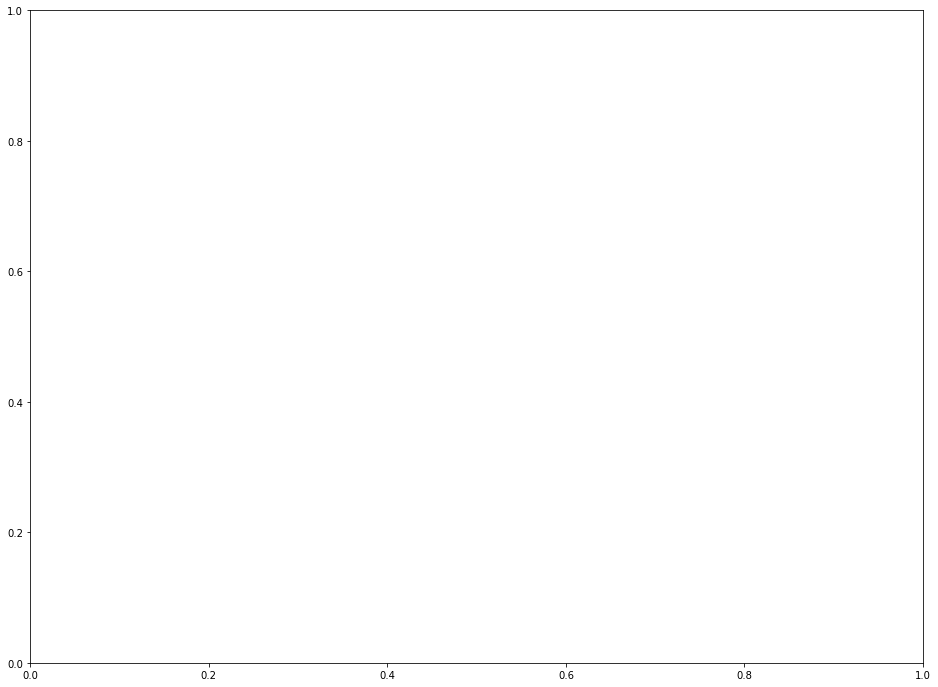

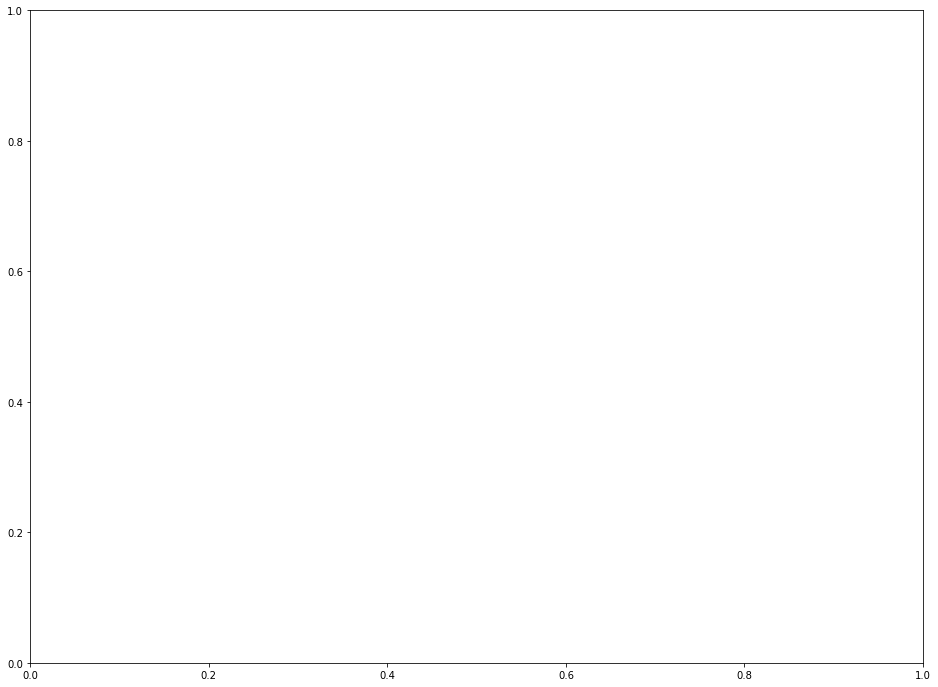

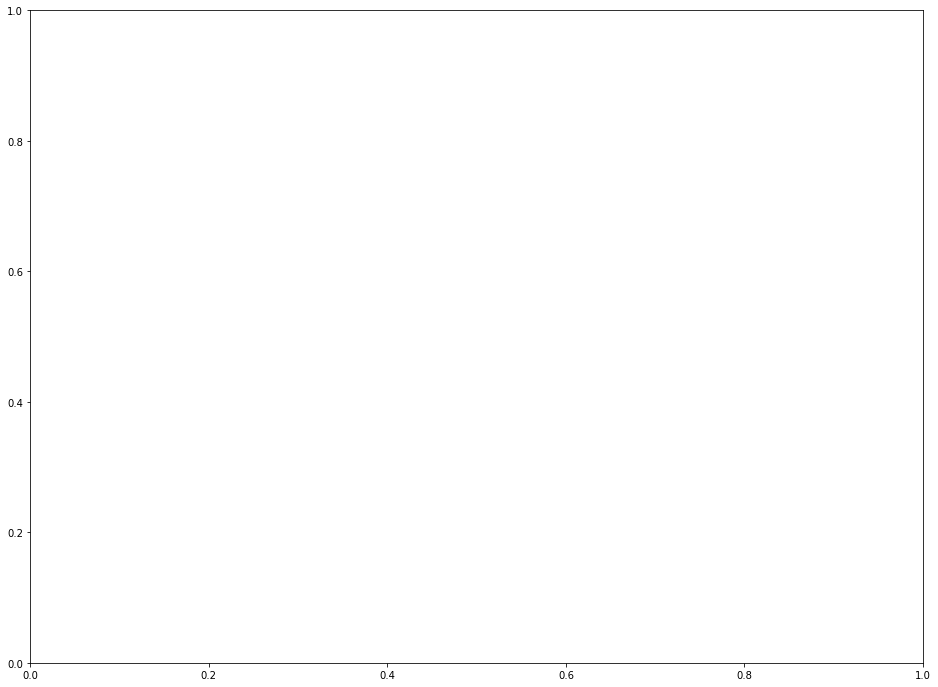

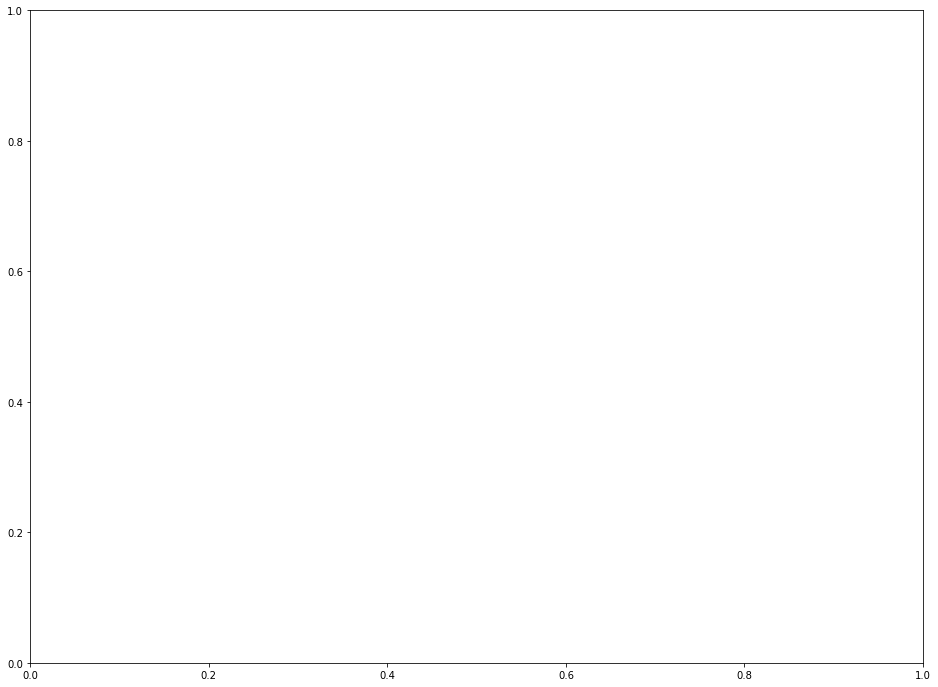

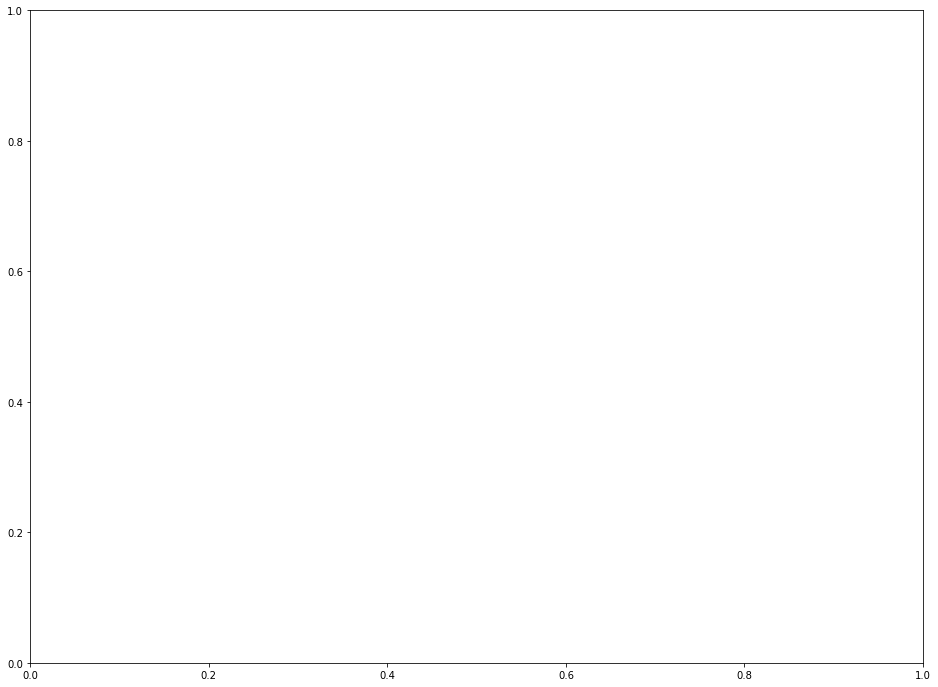

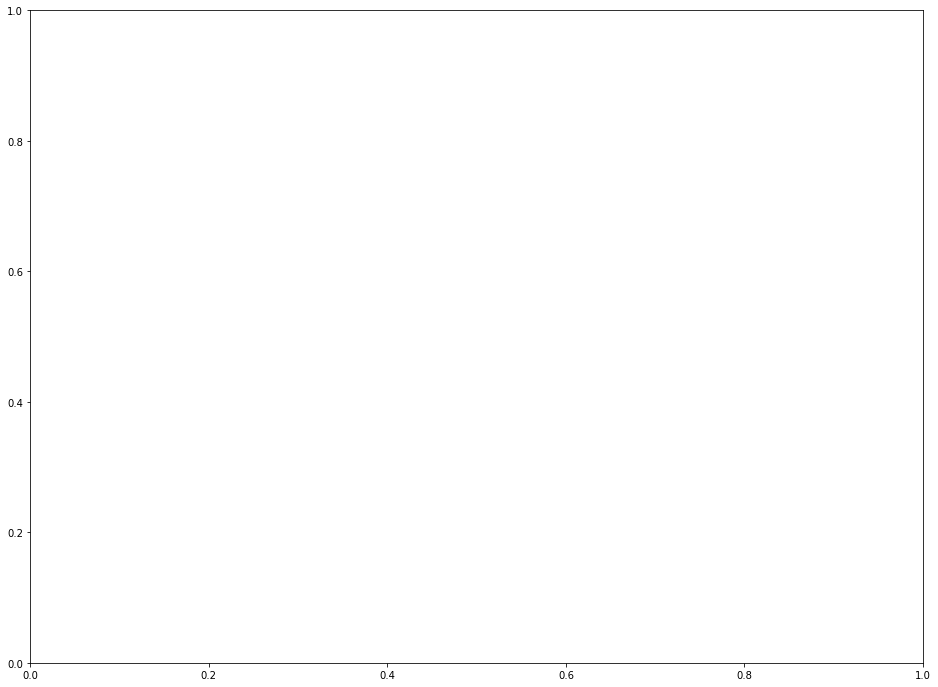

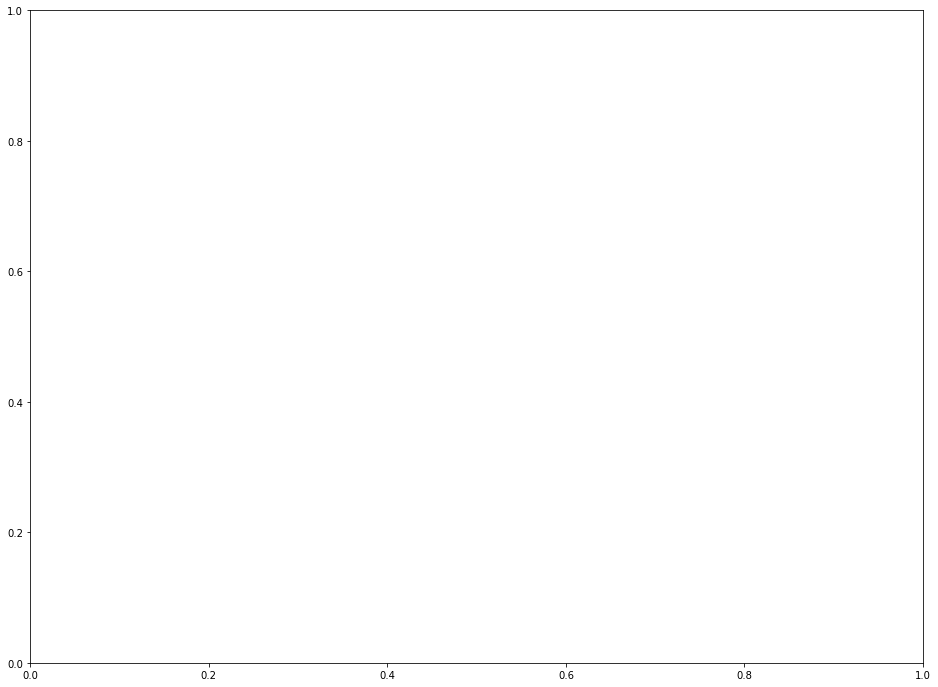

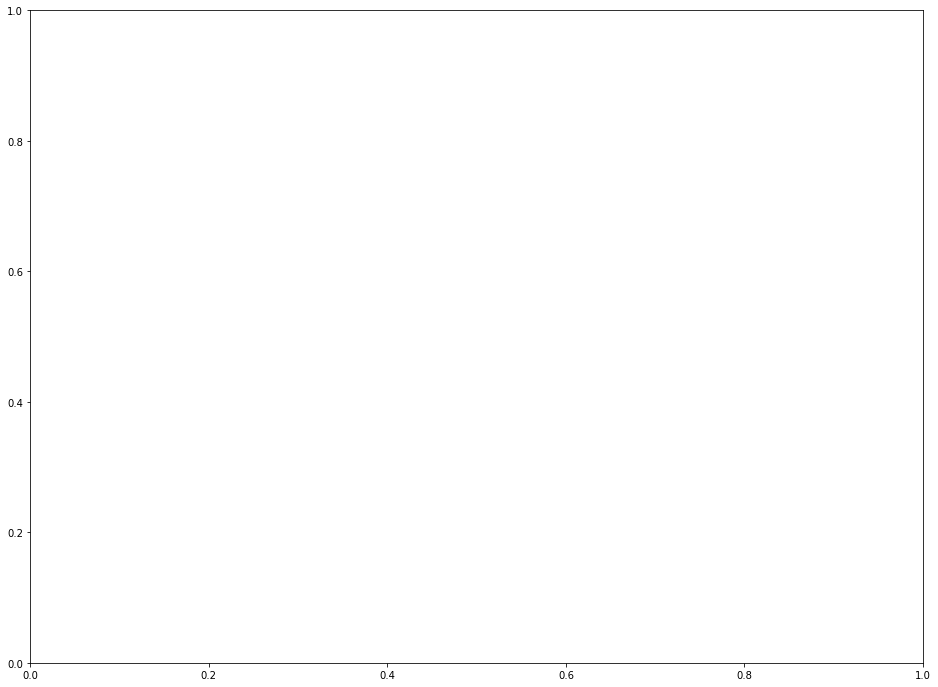

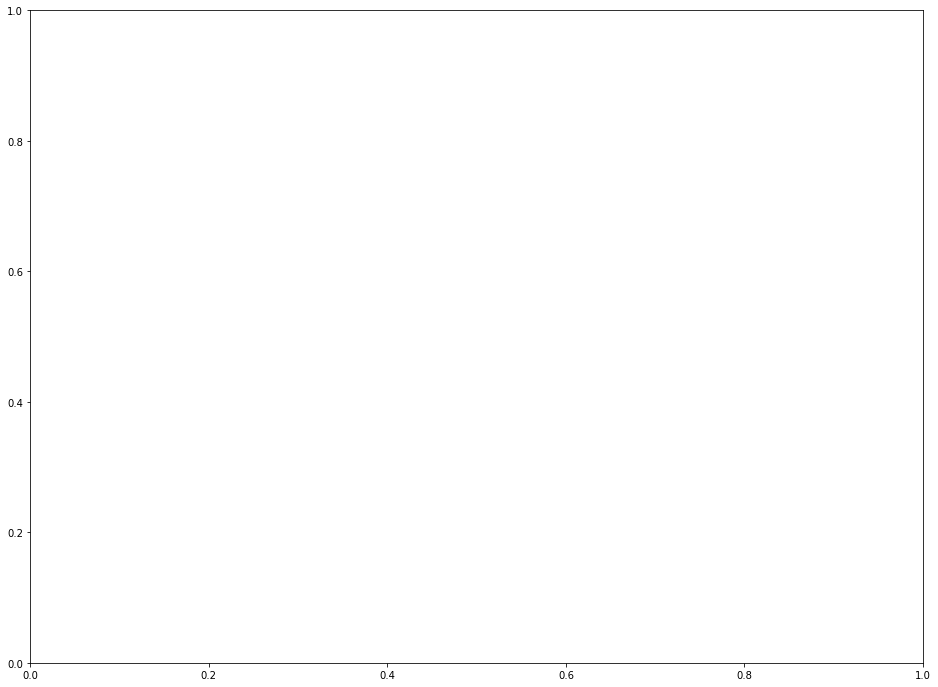

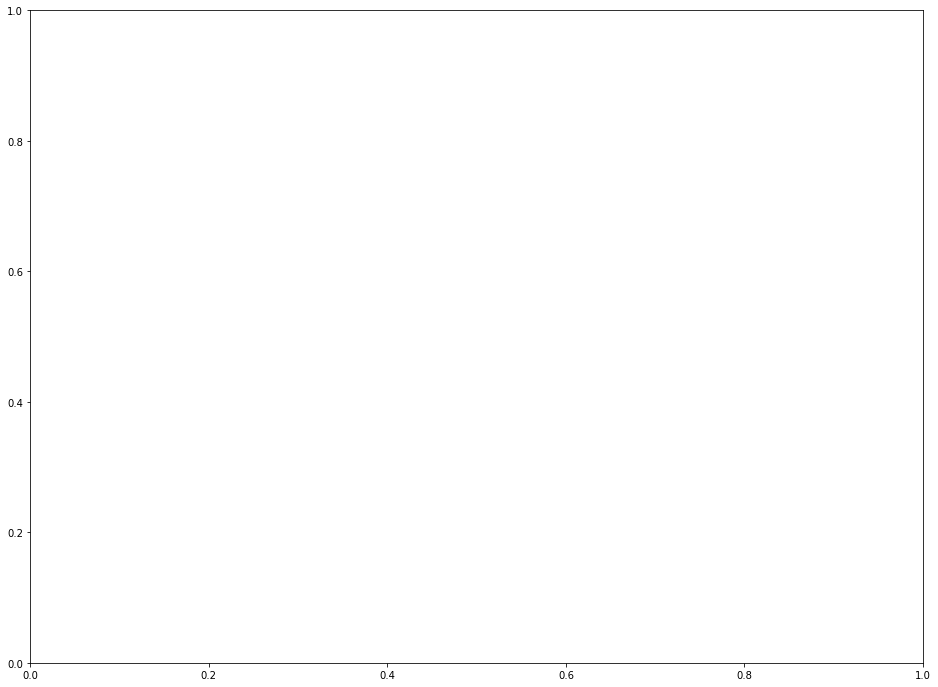

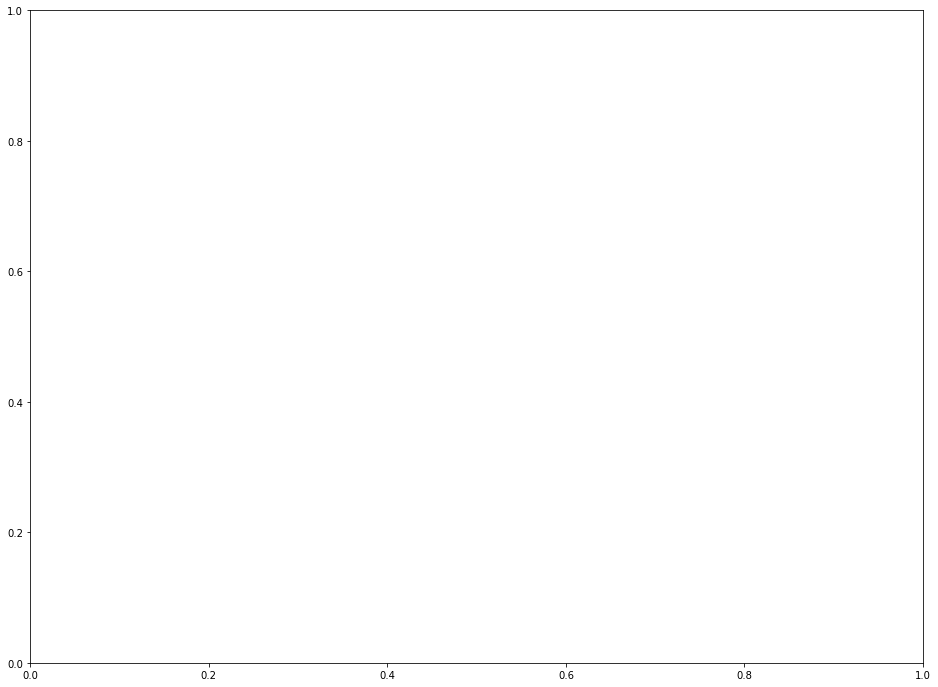

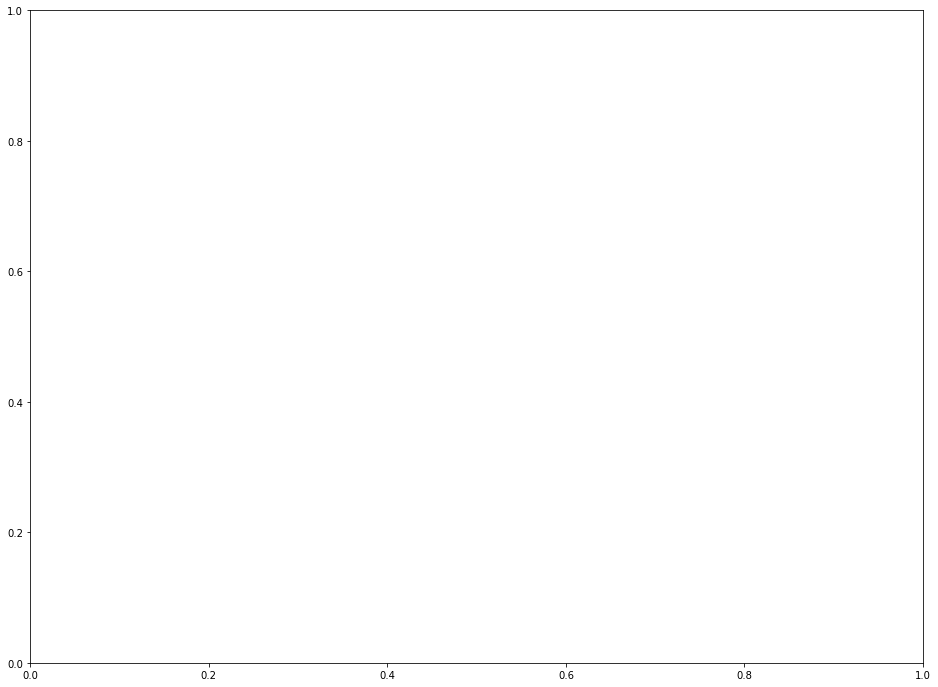

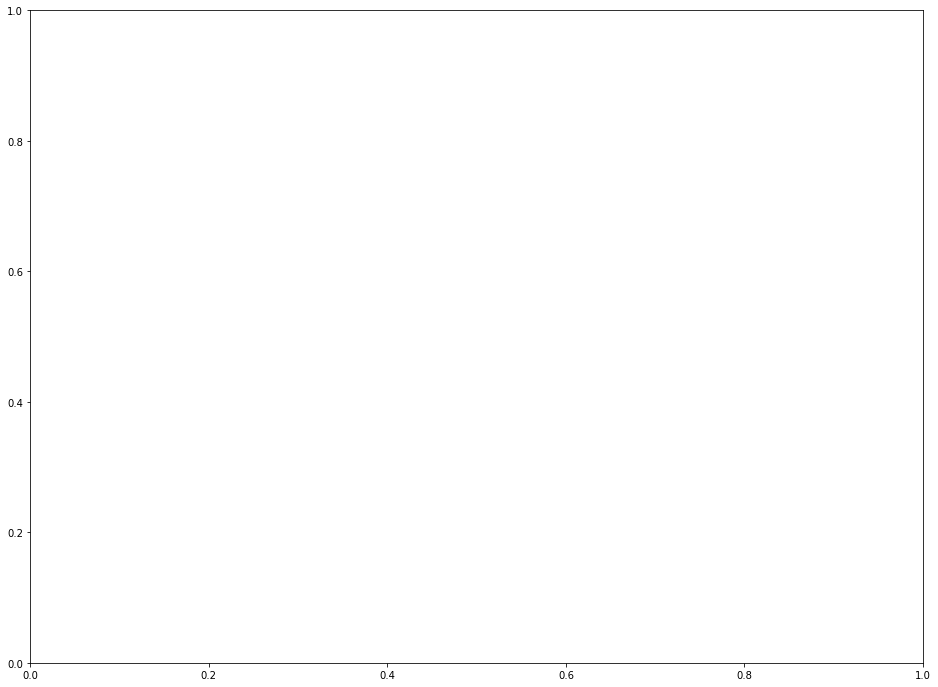

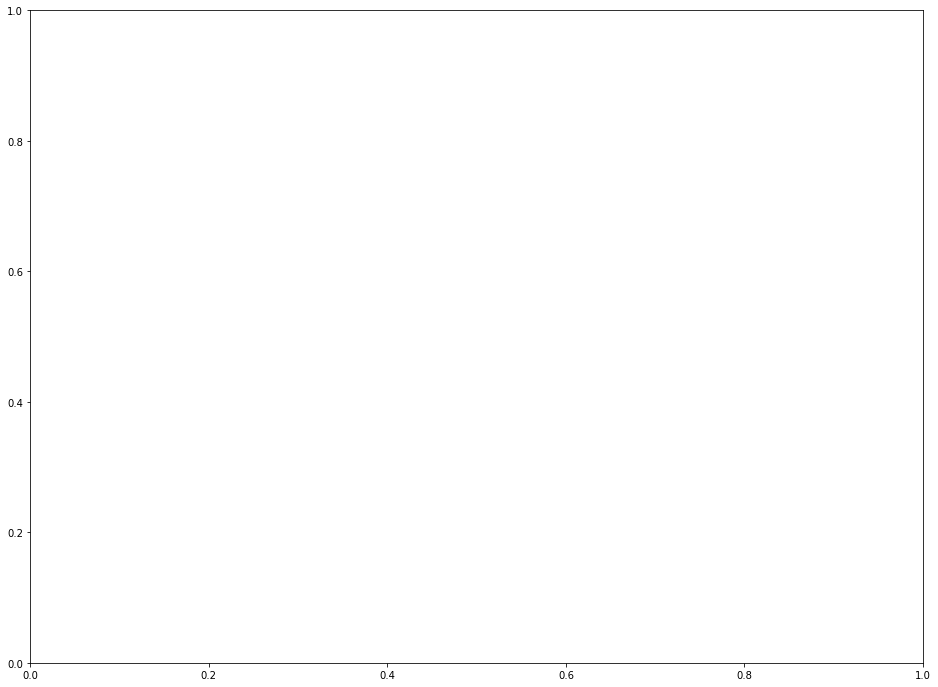

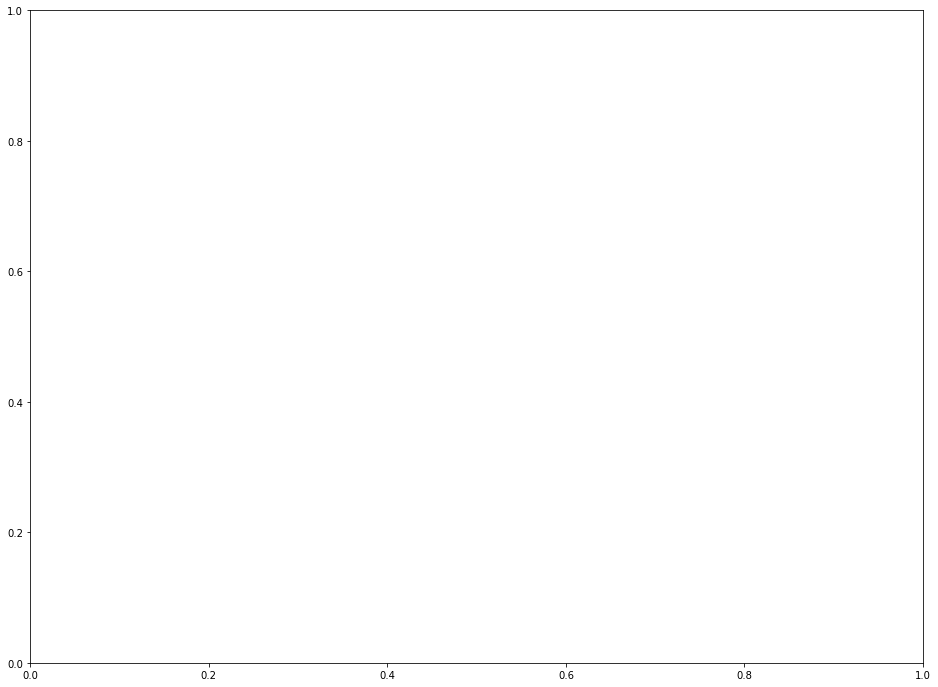

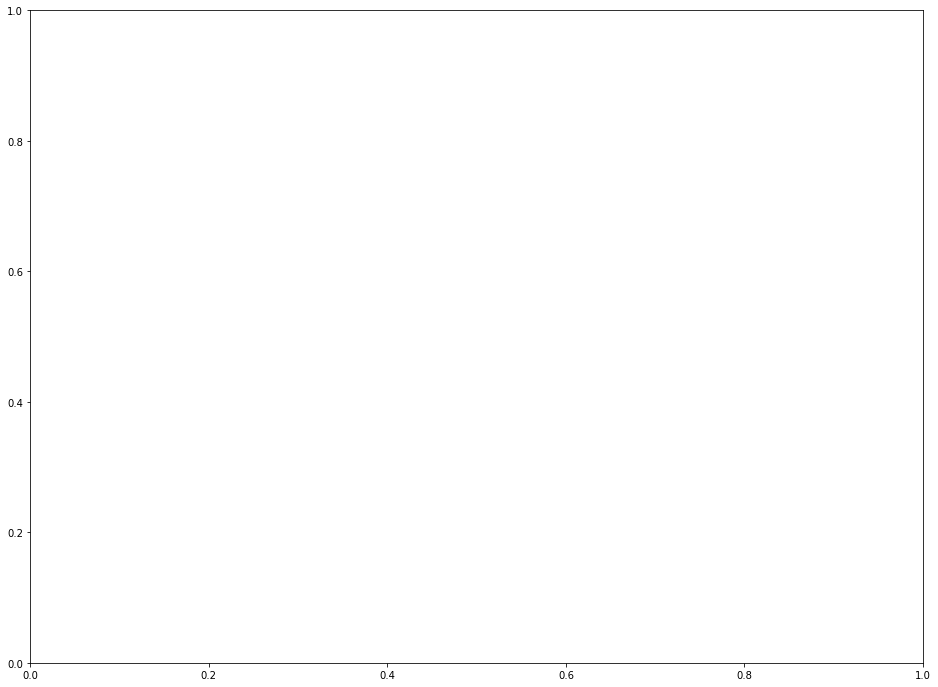

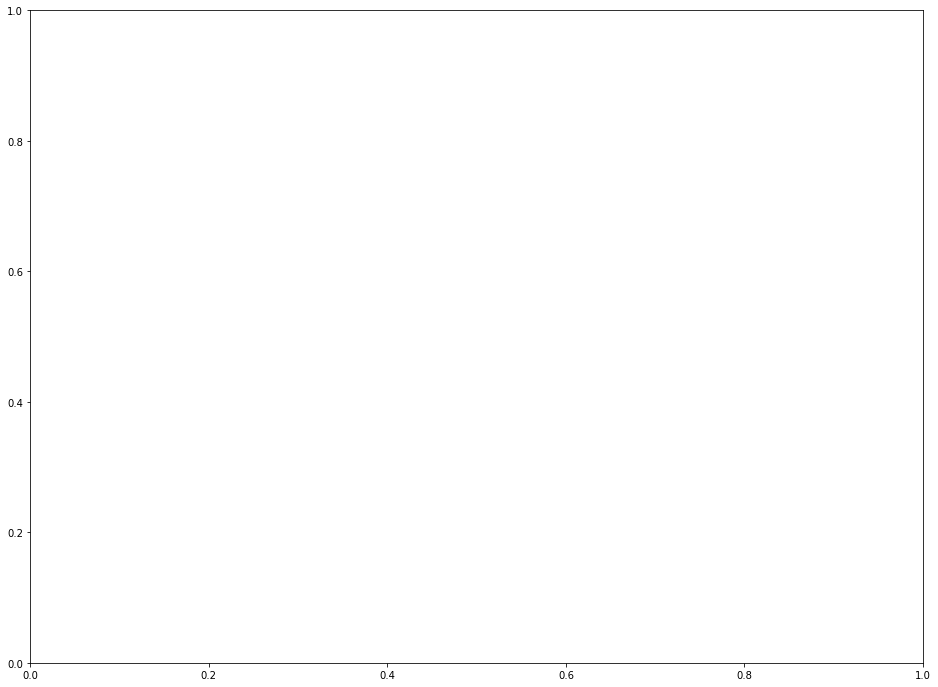

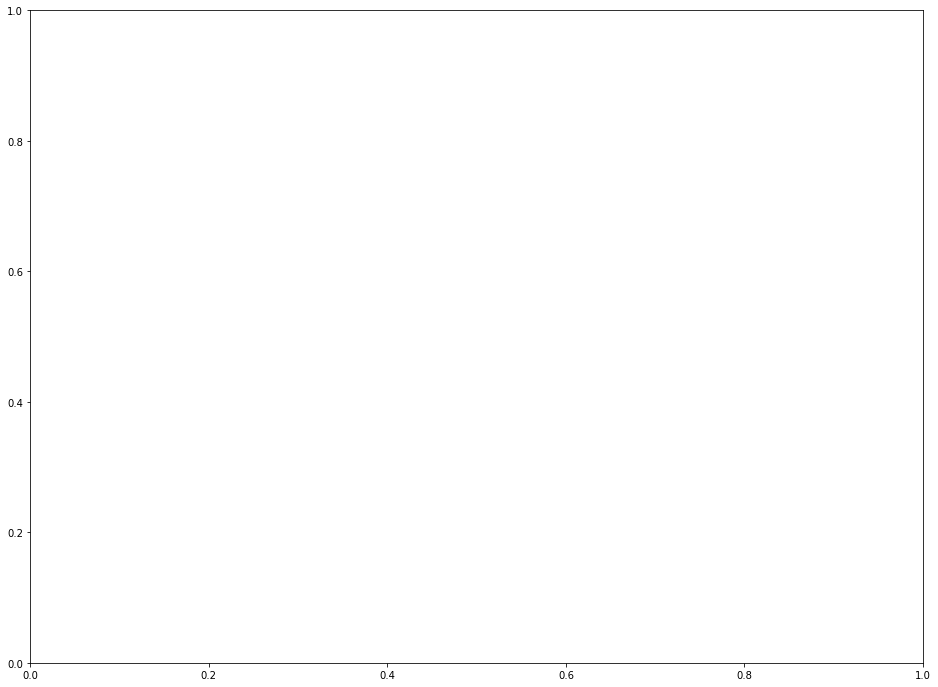

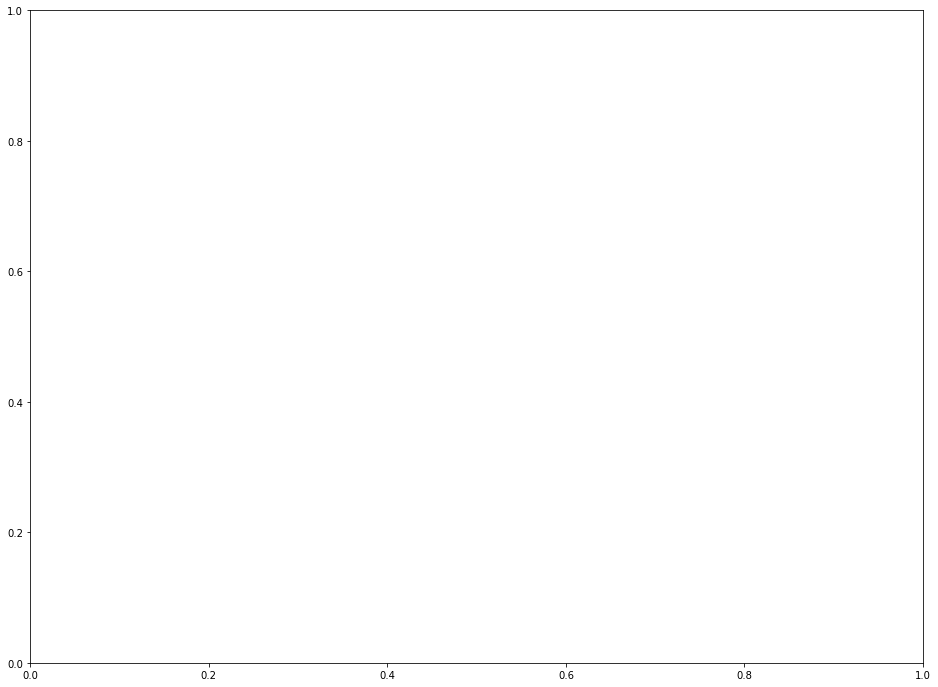

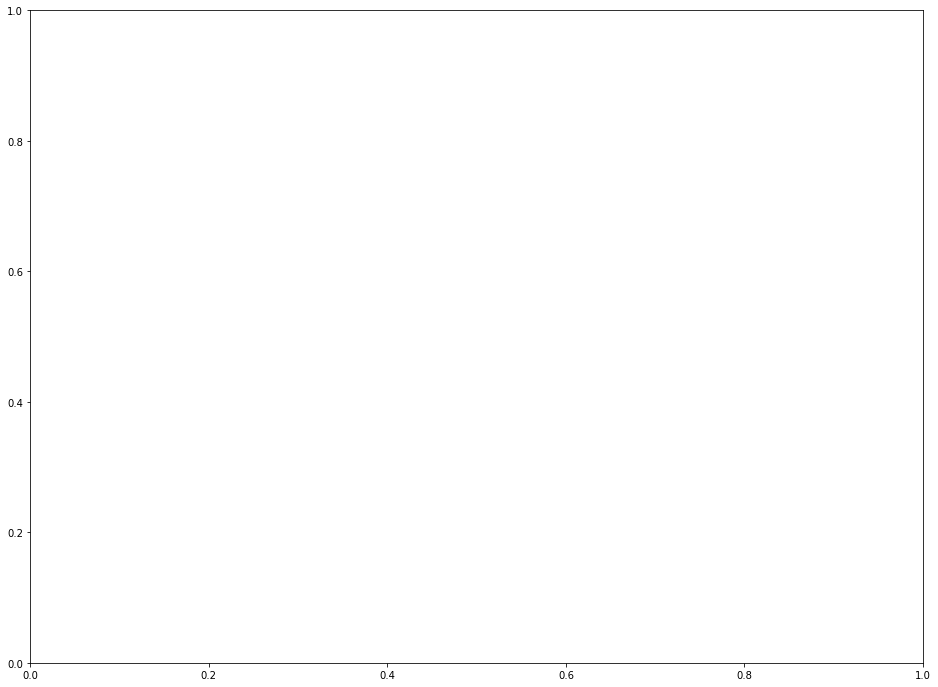

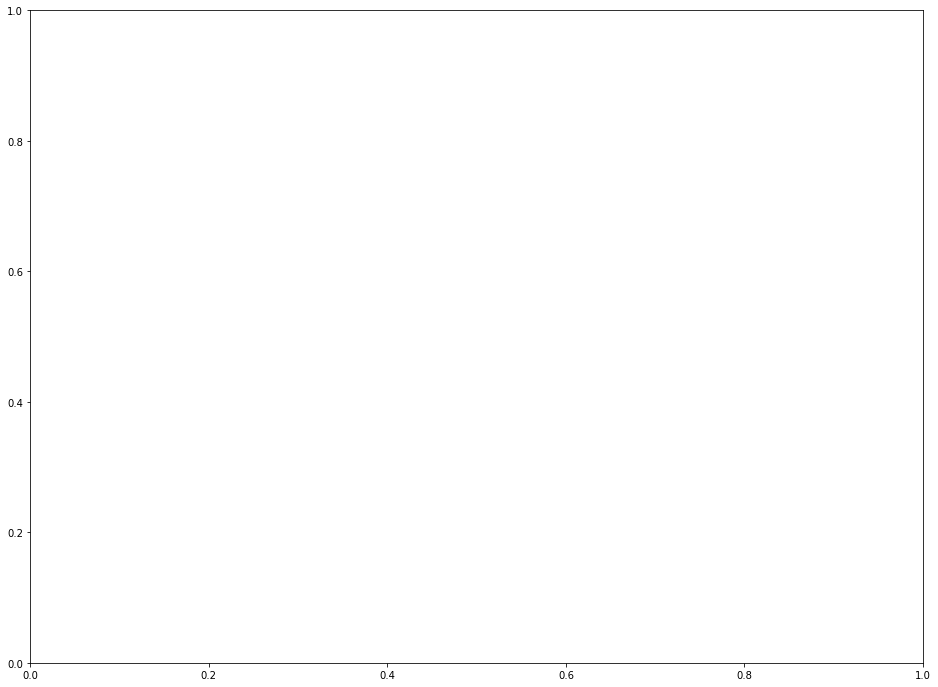

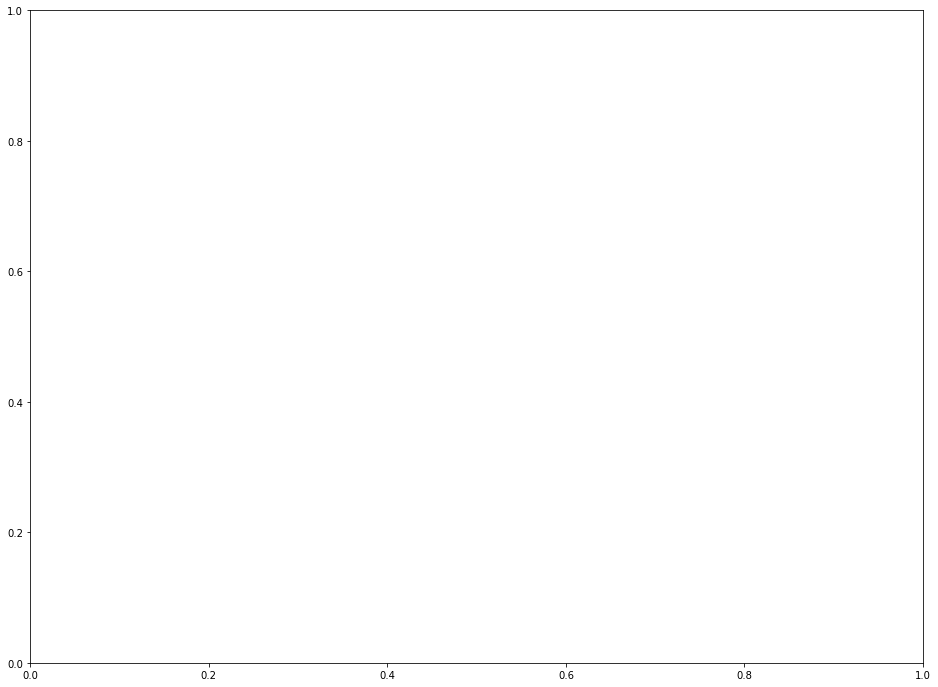

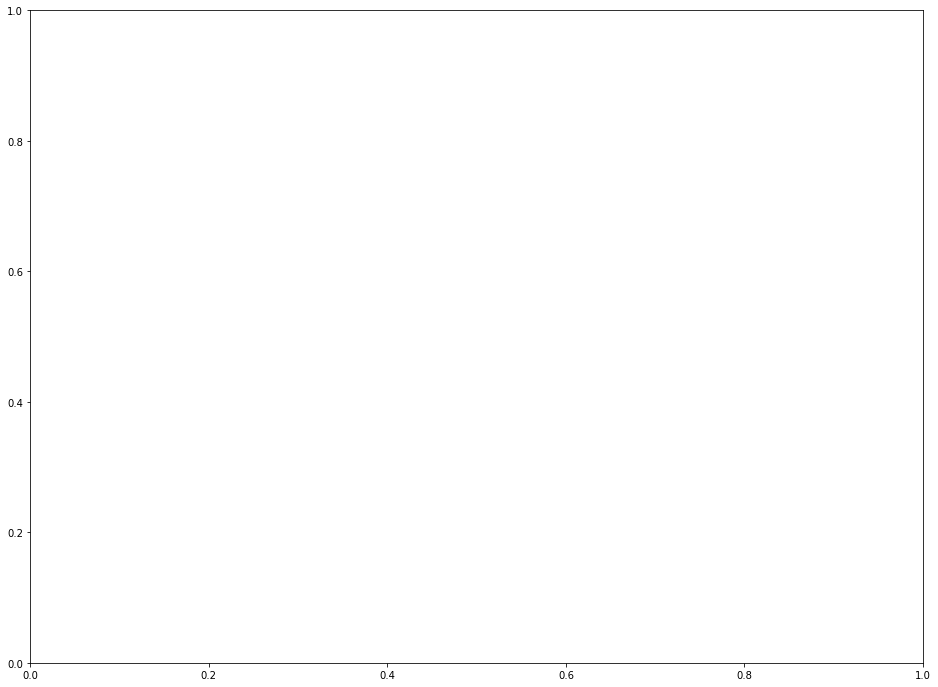

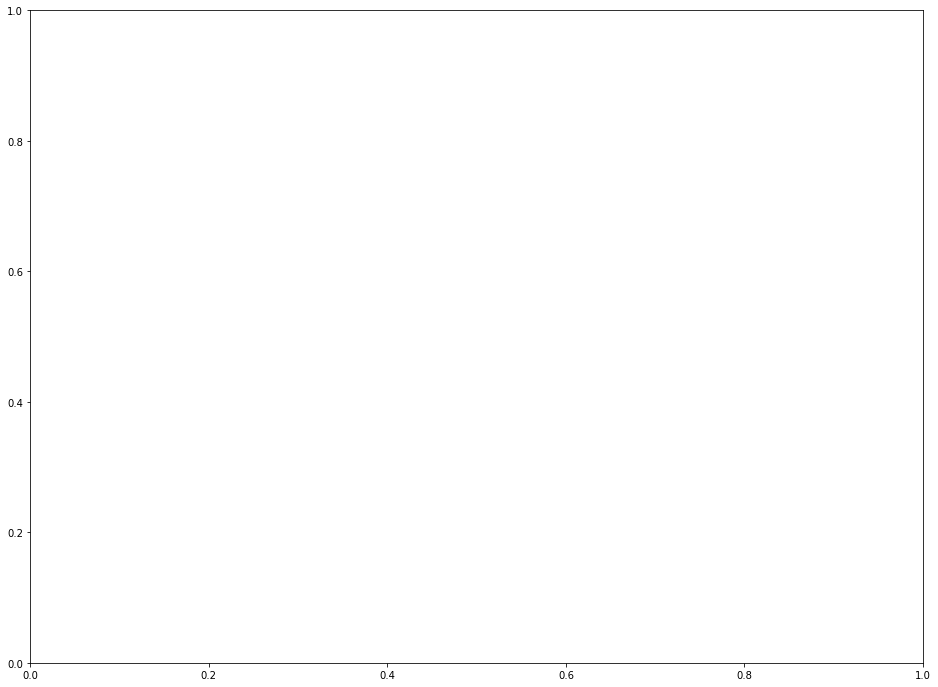

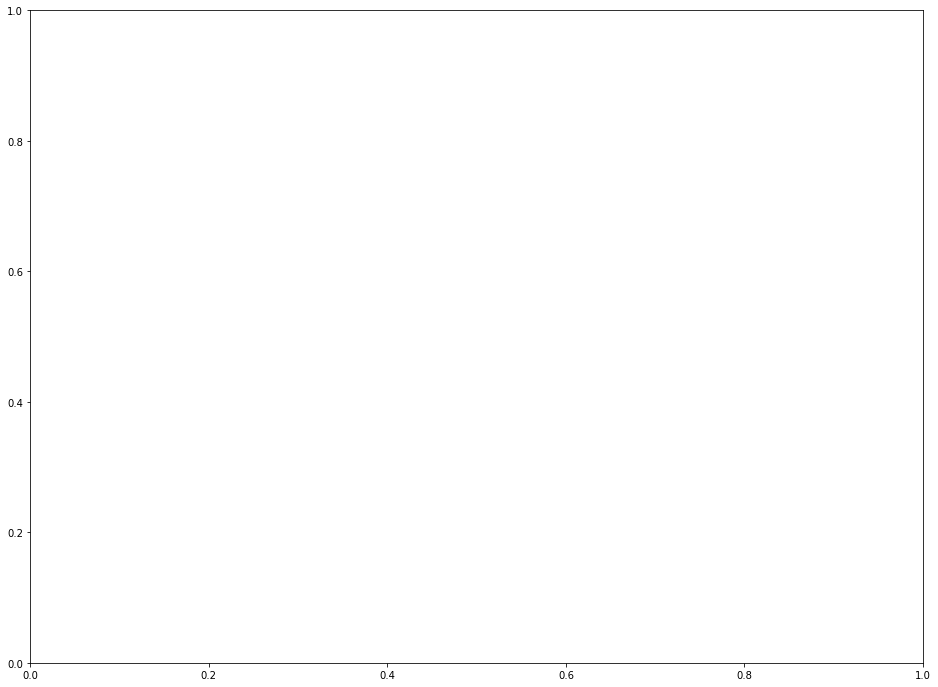

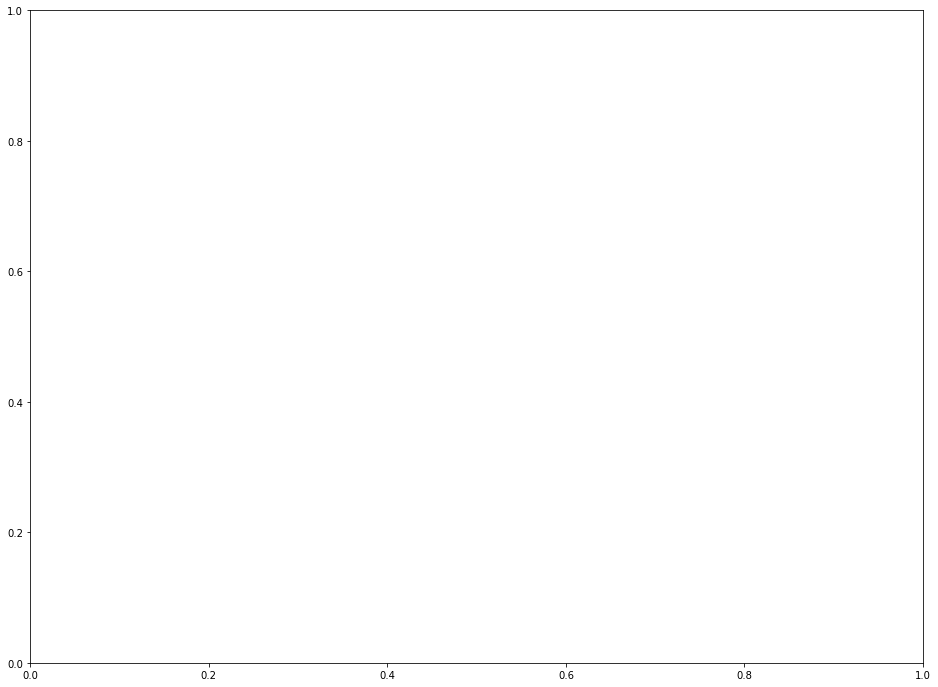

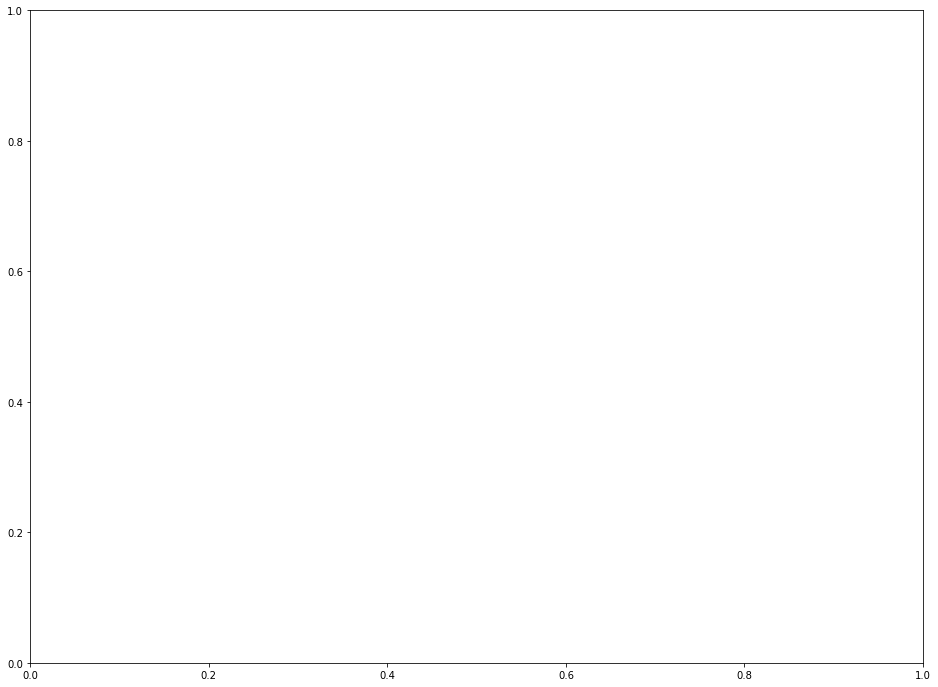

In [391]:
plotTsneAndSaveToFiles(df_learning_lab_n_iter_progress, 'n_iter_progress'+ str(n_i_progress)+'_')

In [392]:
n_comp=2 
perplex=30.0 
early_exag=12.0 
l_rate=200.0 
rstate=42 
n_i= 2000 
n_i_progress=300

df_learning_lab_n_iter= tuneHyperparametersTsne(df=df_with_pm, scaled_df=scaled_df, n_components=n_comp, perplexity=perplex, early_exaggeration=early_exag, learning_rate=l_rate, 
random_state=rstate, n_iter= n_i, n_iter_without_progress=n_i_progress)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 726 entries, 201110 to 310113
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Gender                        726 non-null    float64
 1   IC                            726 non-null    int64  
 2   Zip-code                      726 non-null    int64  
 3   Geboortedatum                 726 non-null    int64  
 4   Leeftijd (op testdag)         726 non-null    float64
 5   AST (tijd afgerond op 0.1s)   726 non-null    float64
 6   MQ                            726 non-null    float64
 7   MQ catogory                   726 non-null    float64
 8   Lengte (afgerond op 0.1 cm)   726 non-null    float64
 9   Gewicht (afgerond op 0.1 kg)  726 non-null    float64
 10  Lengte (in m)                 726 non-null    float64
 11  BMI                           726 non-null    float64
 12  Gymles                        726 non-null    float64
 1

/tmp/ipykernel_36906/3569143405.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(16, 12))


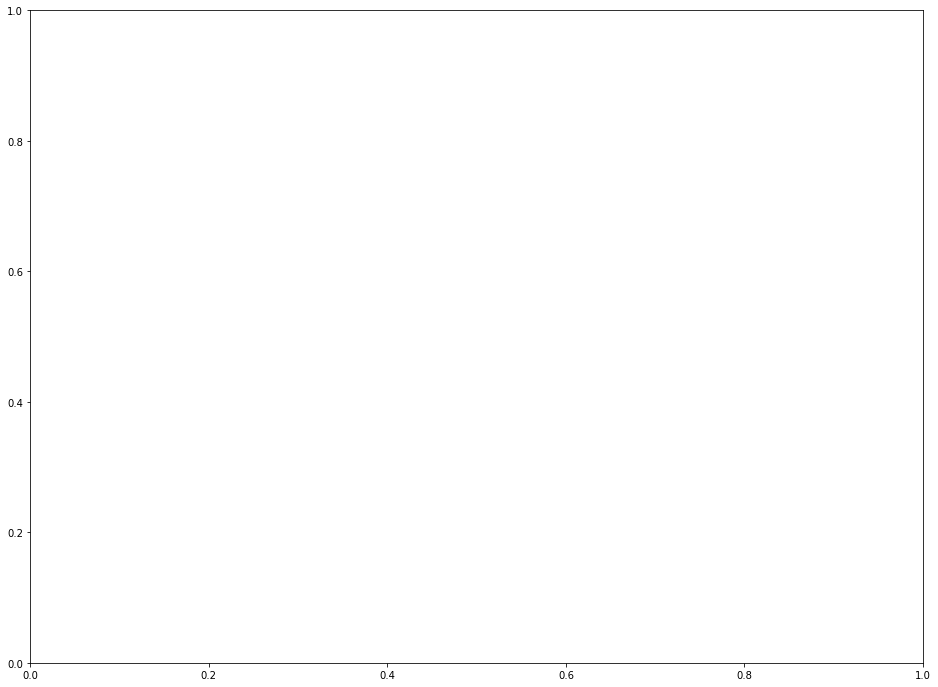

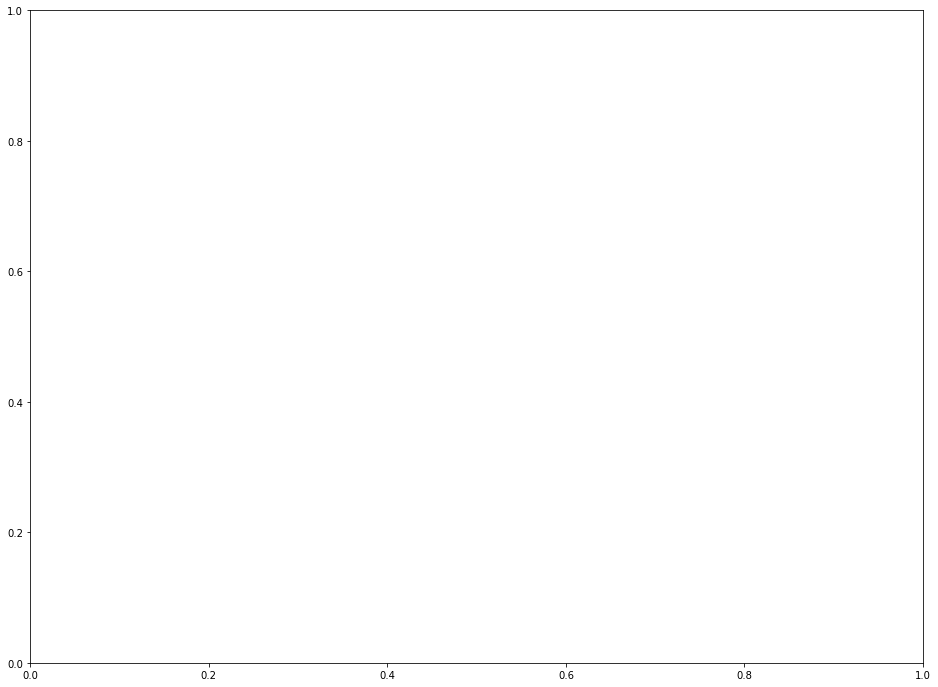

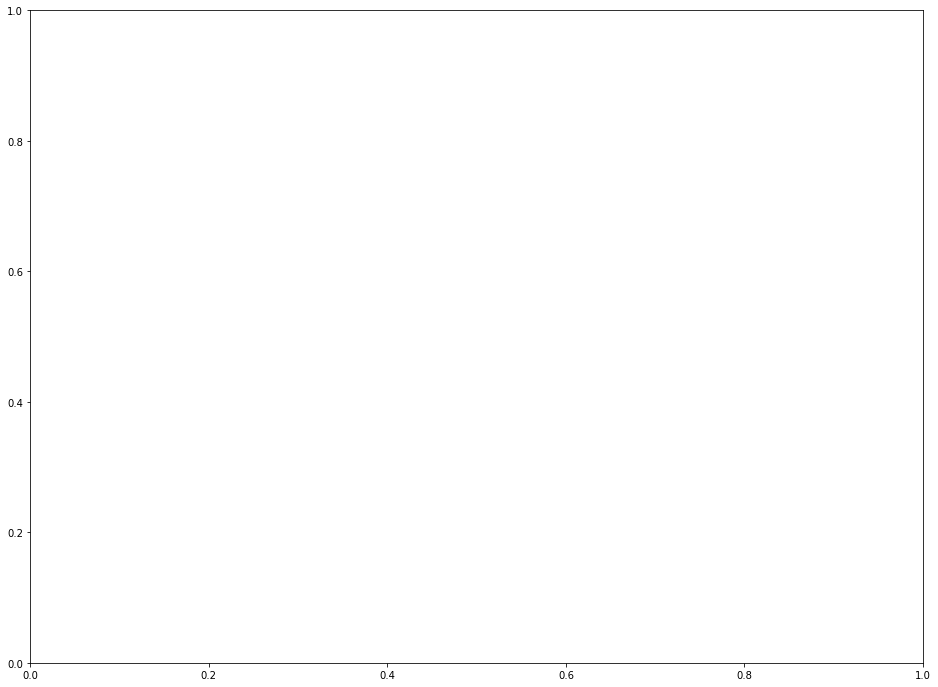

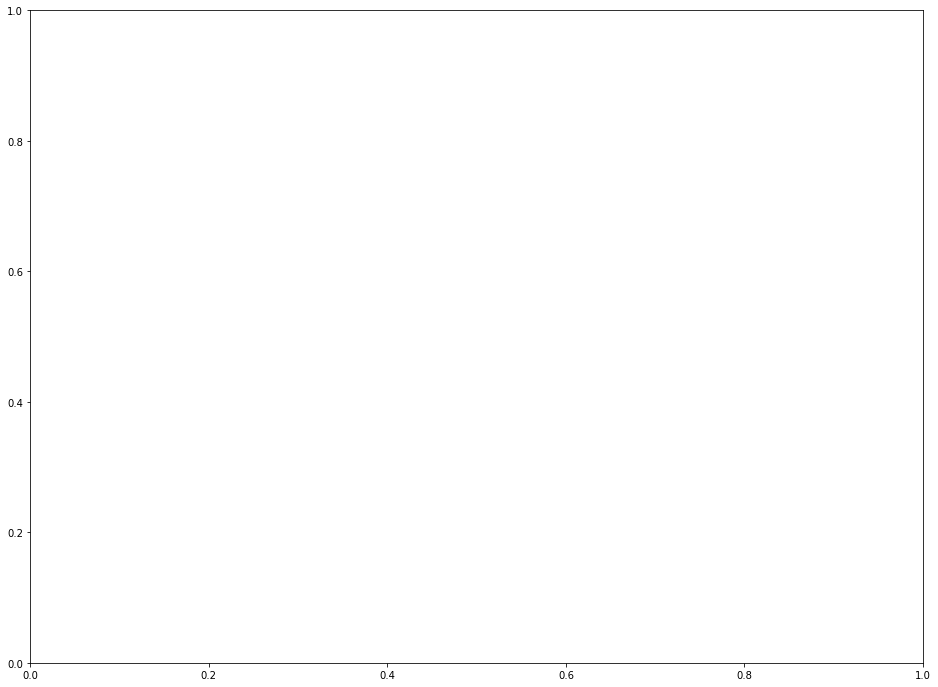

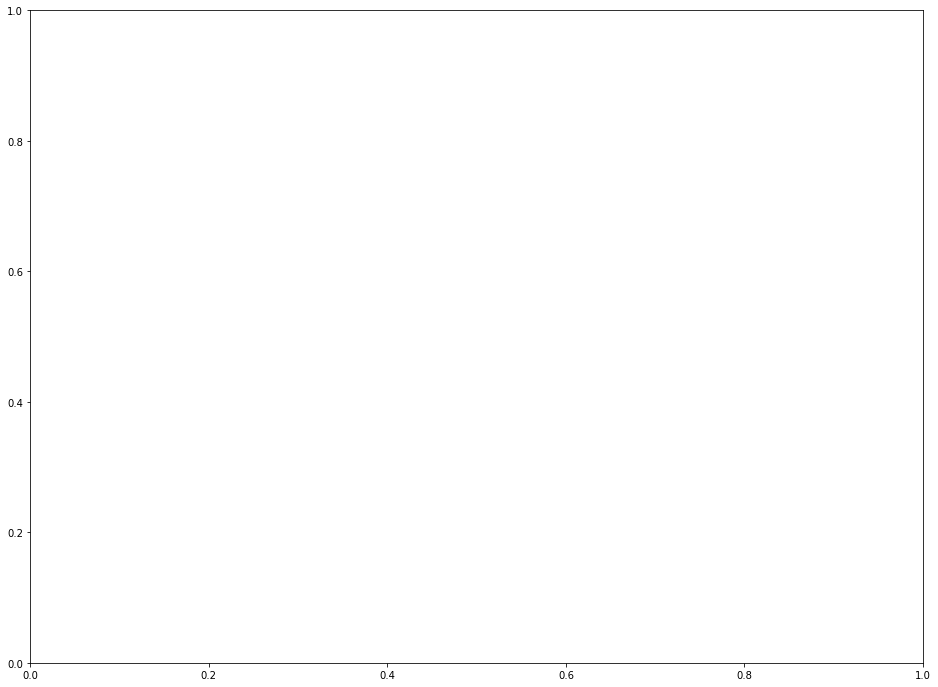

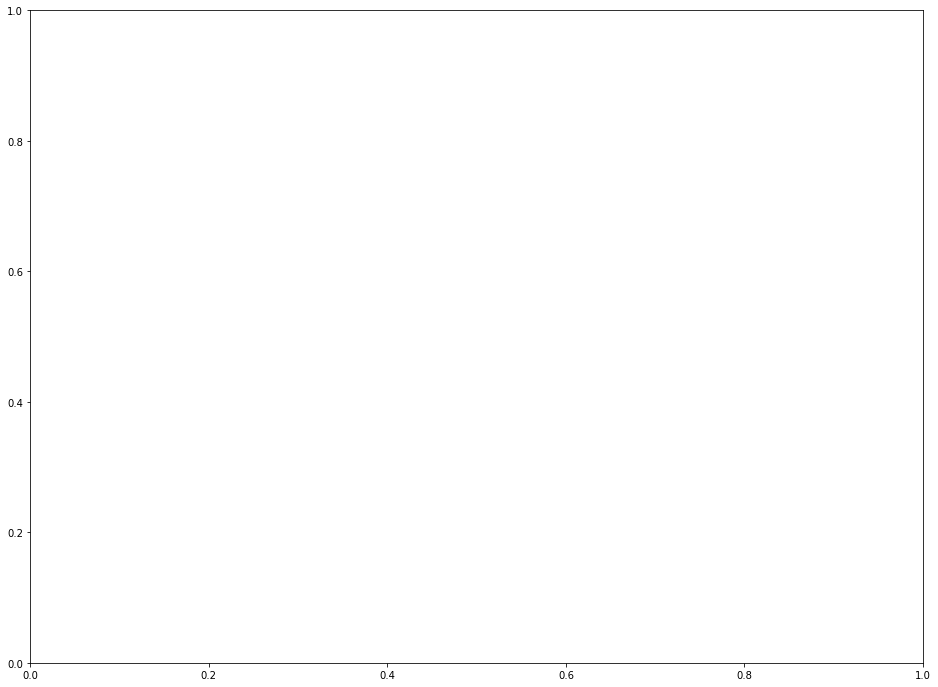

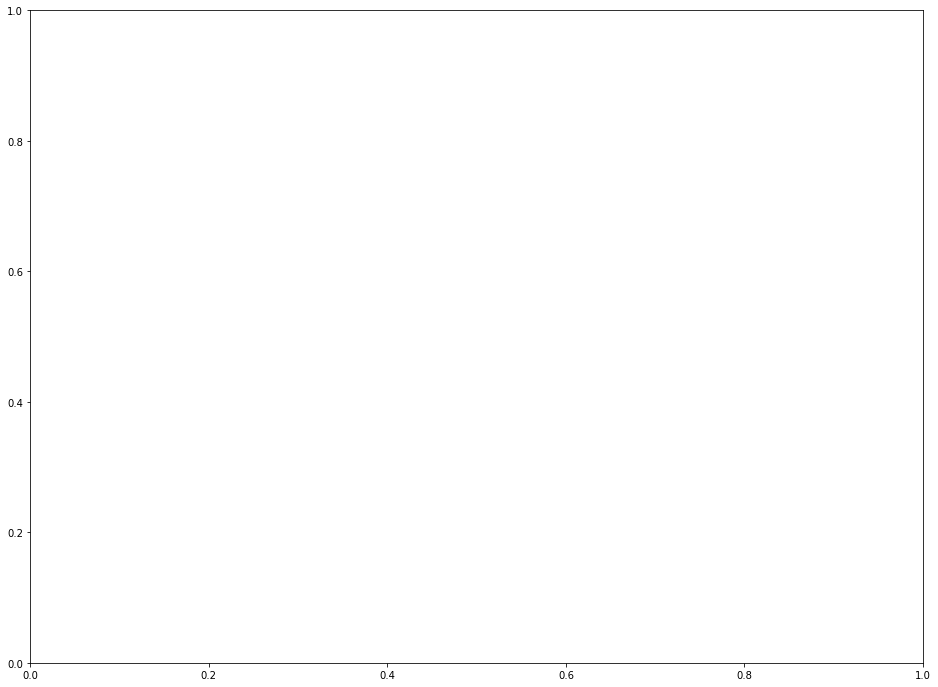

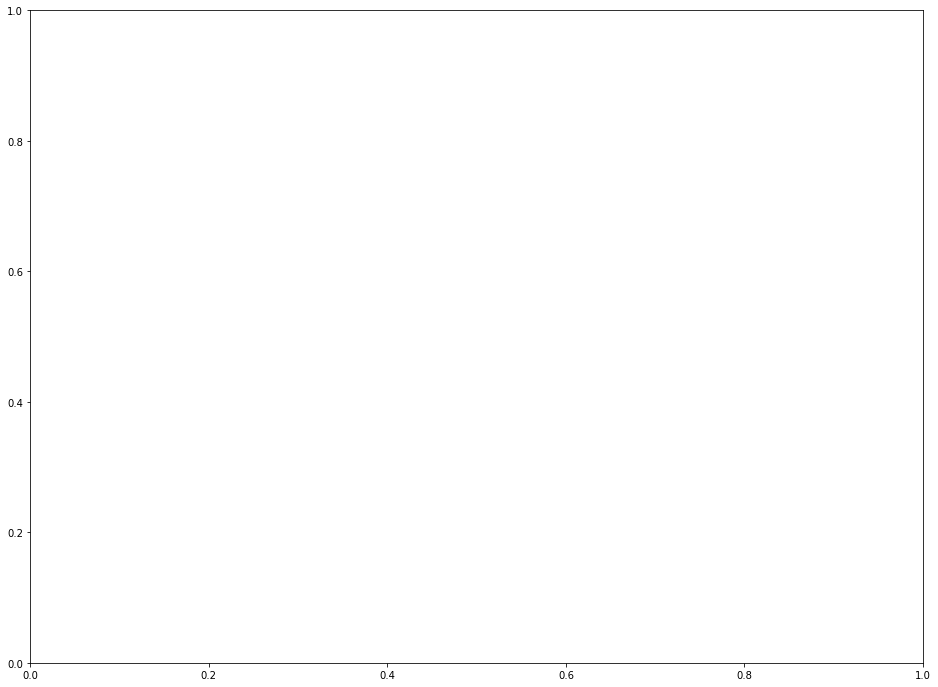

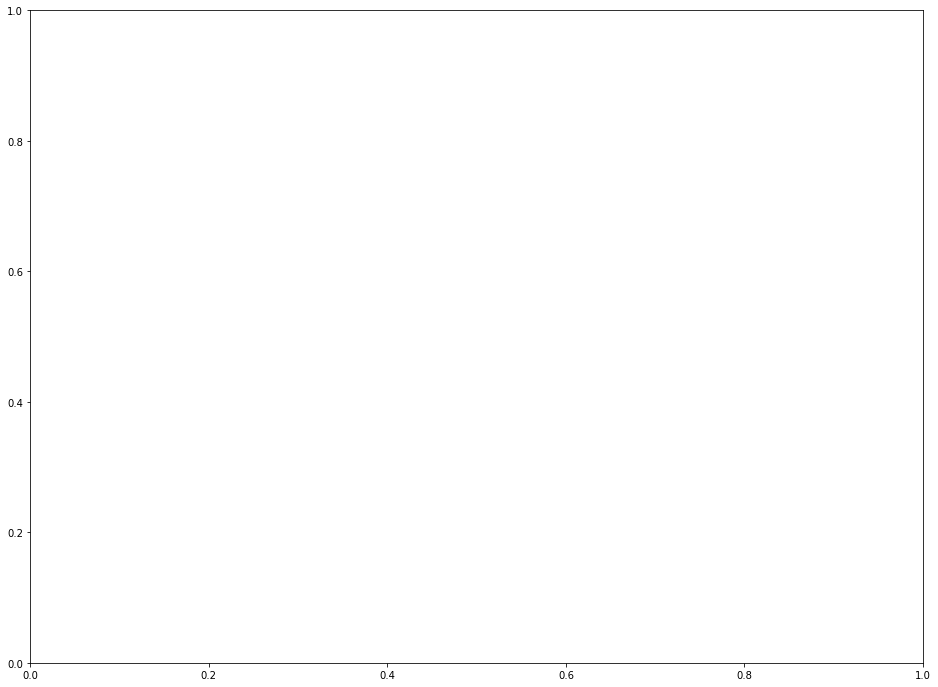

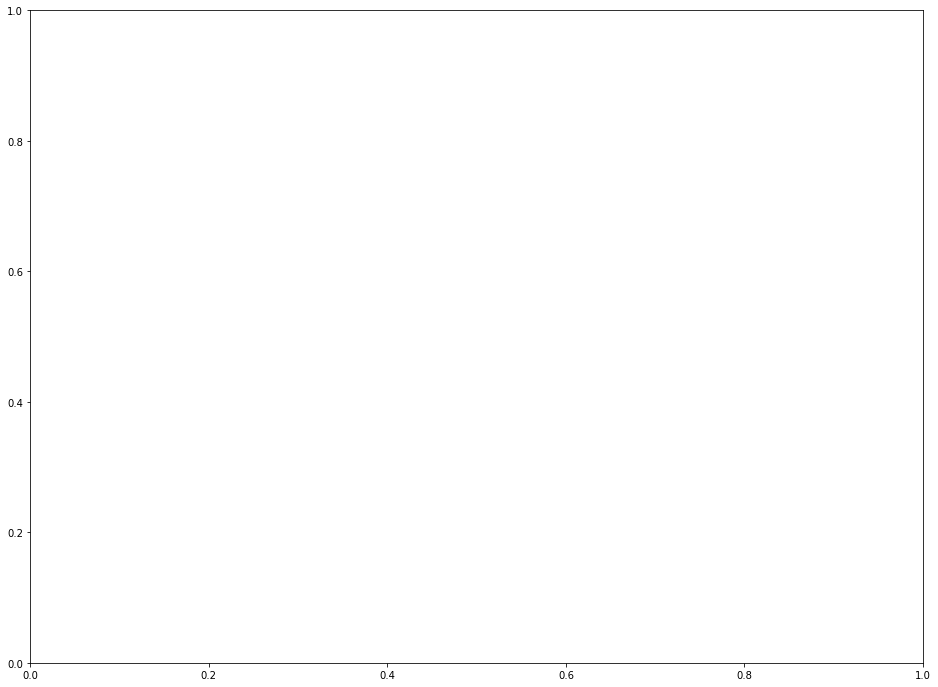

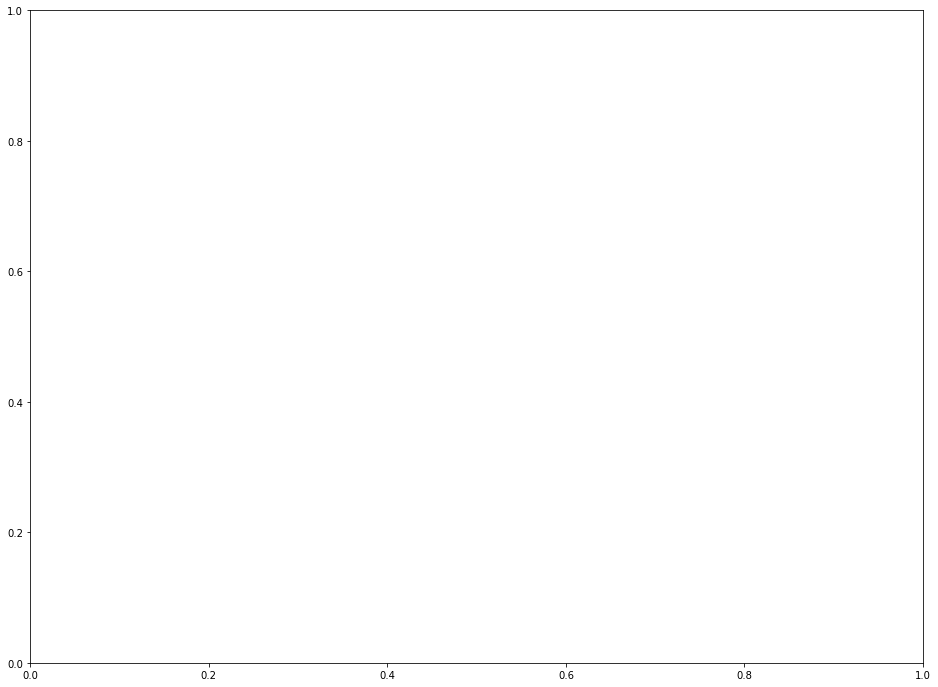

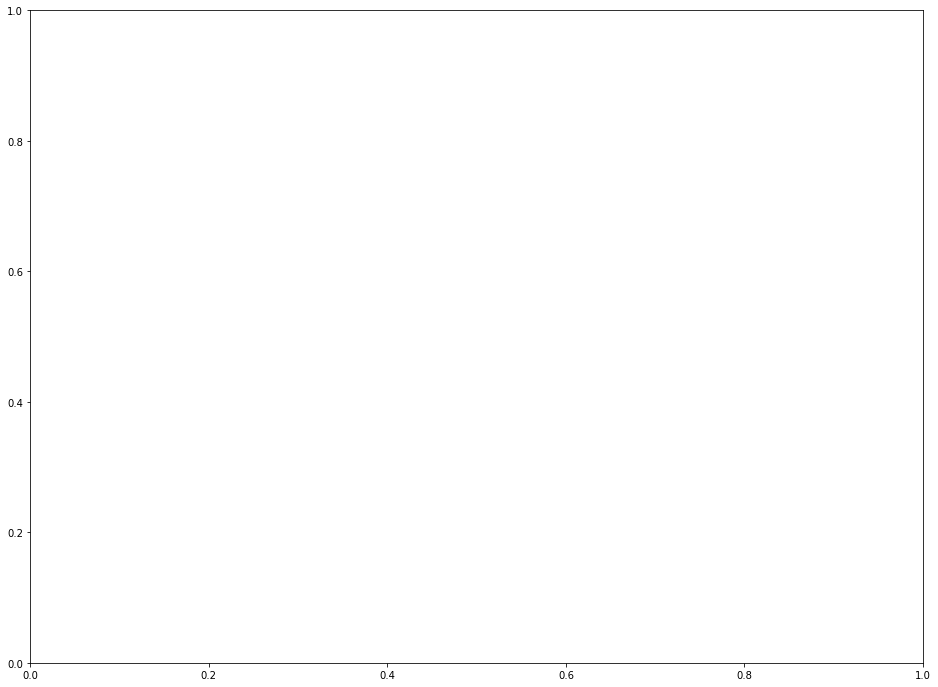

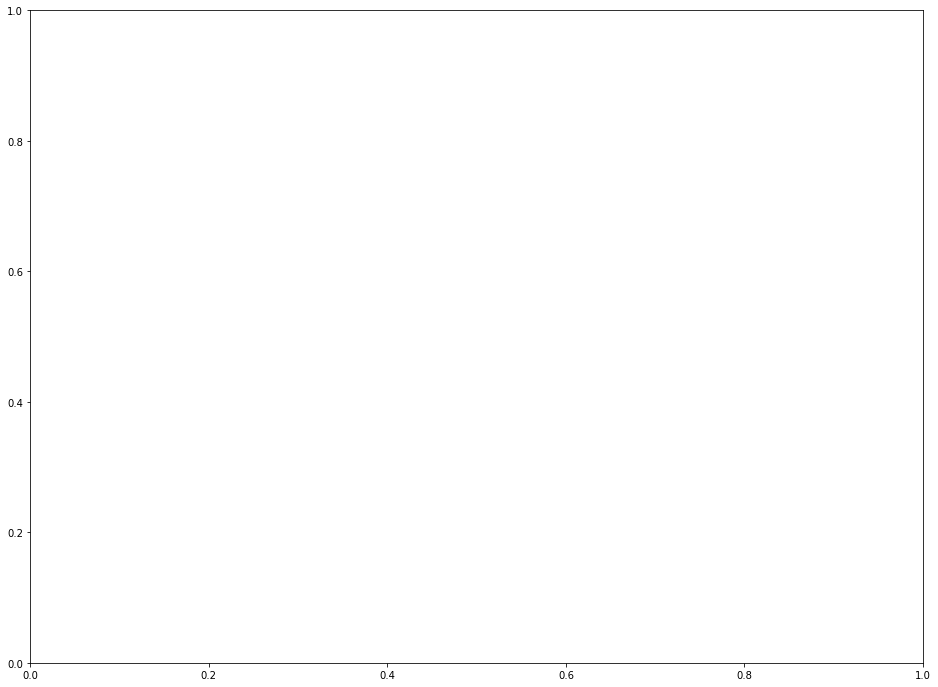

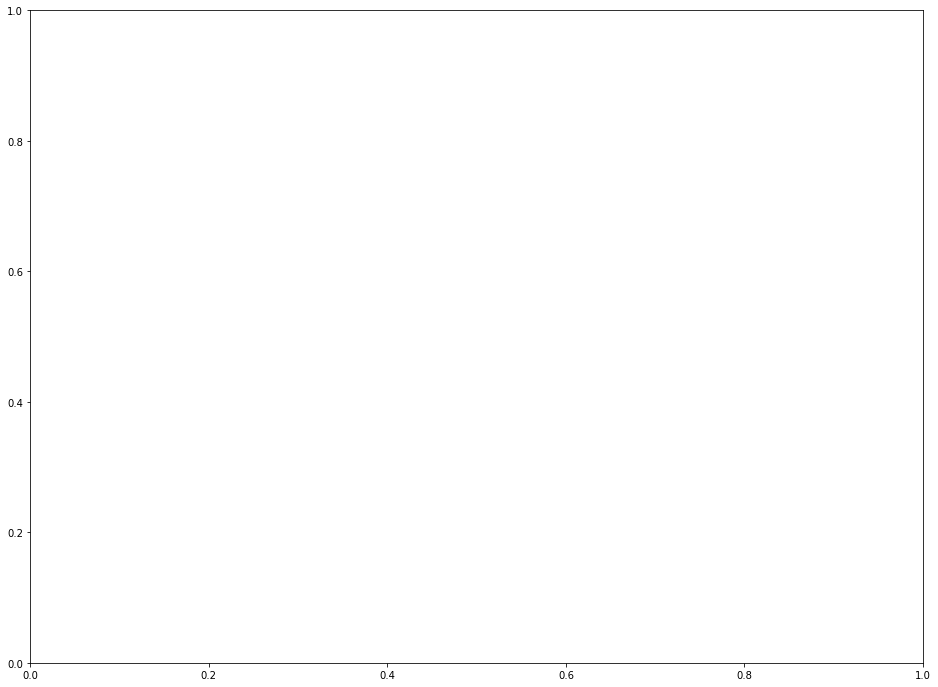

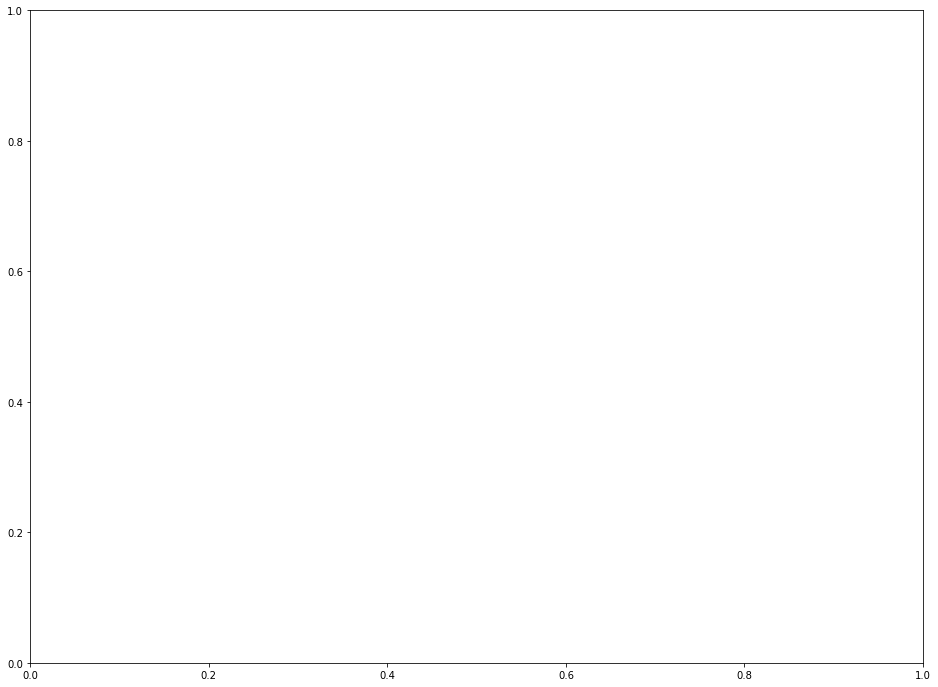

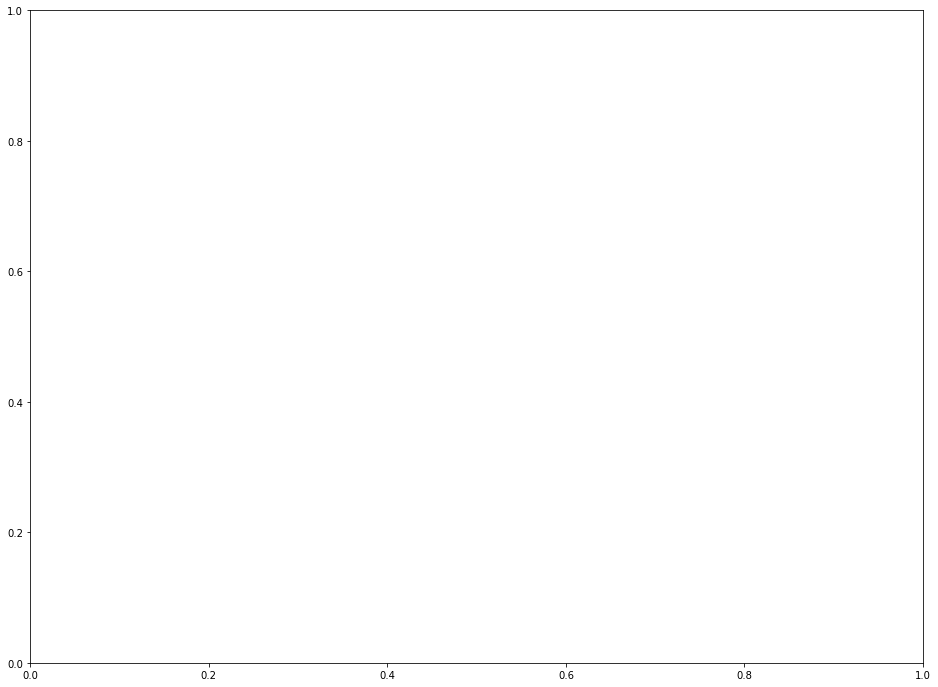

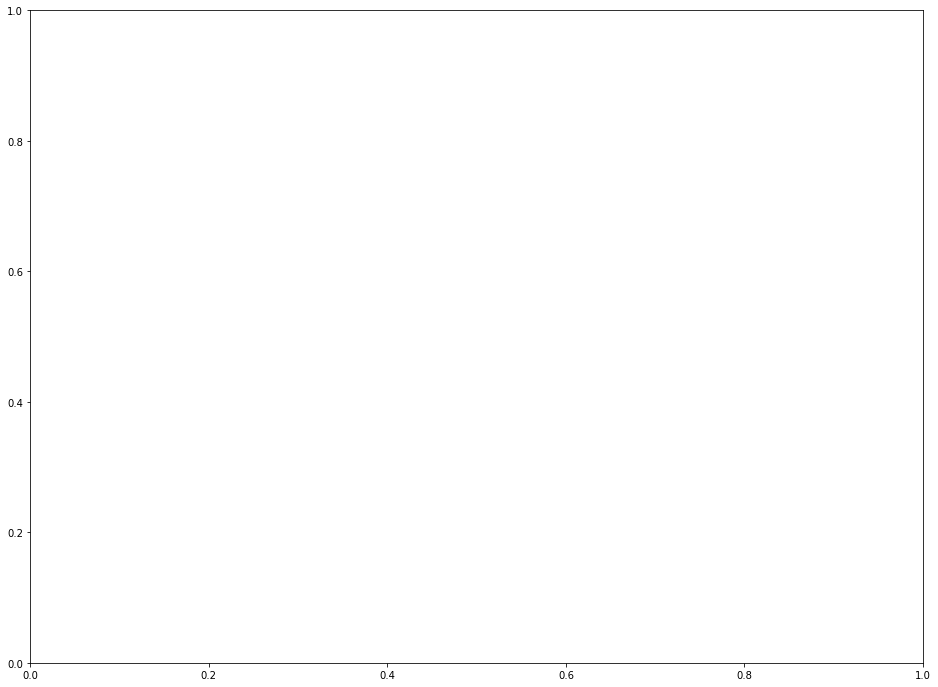

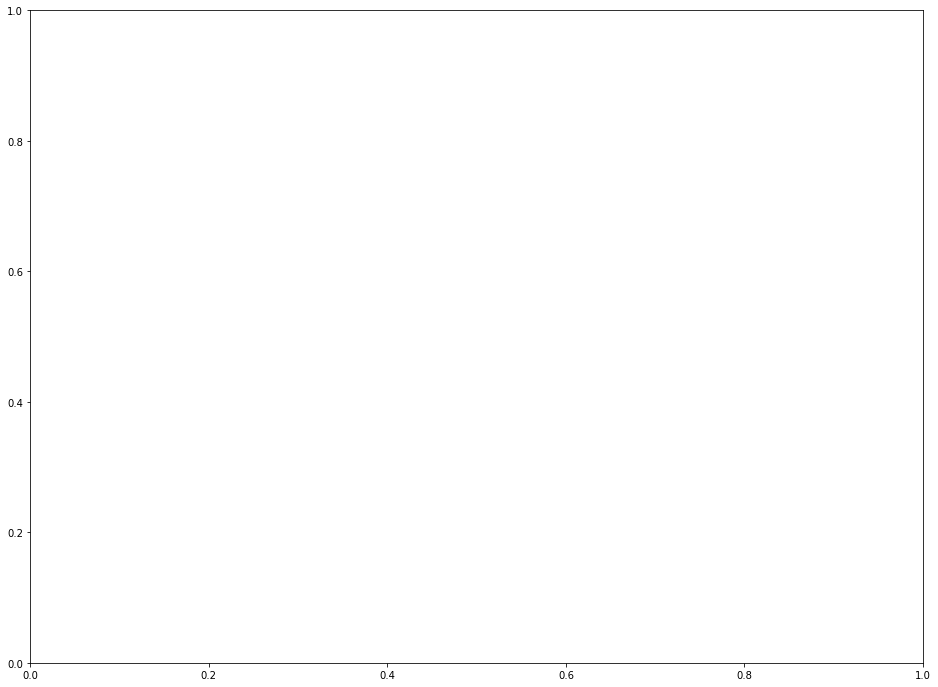

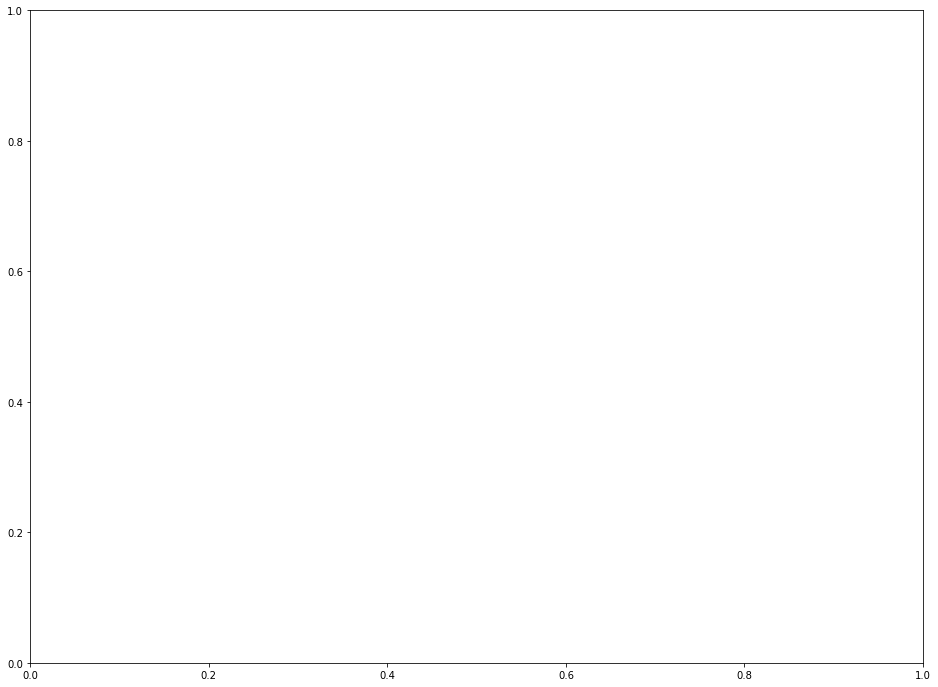

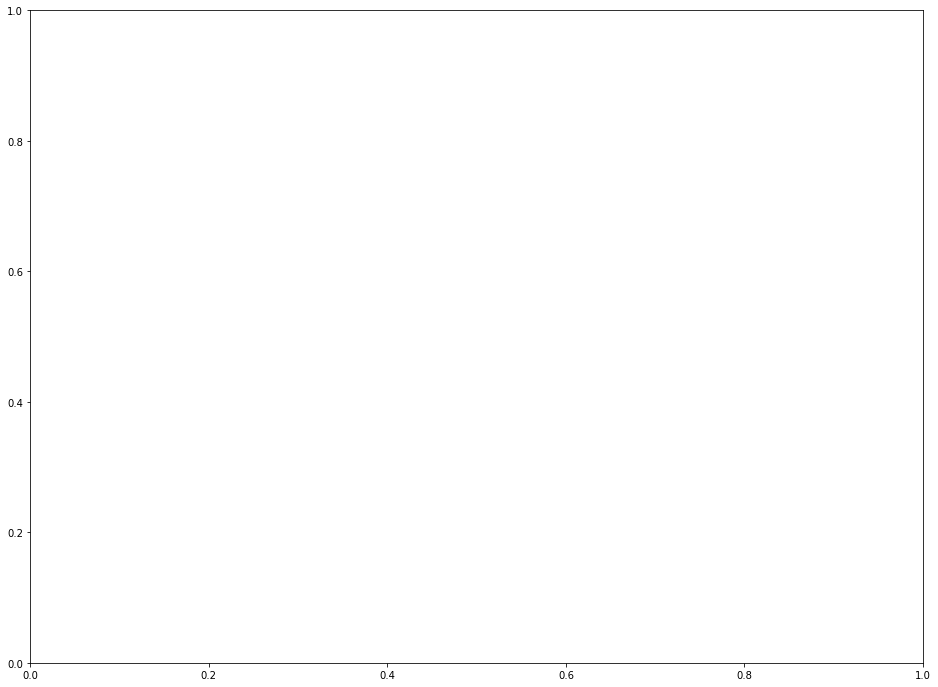

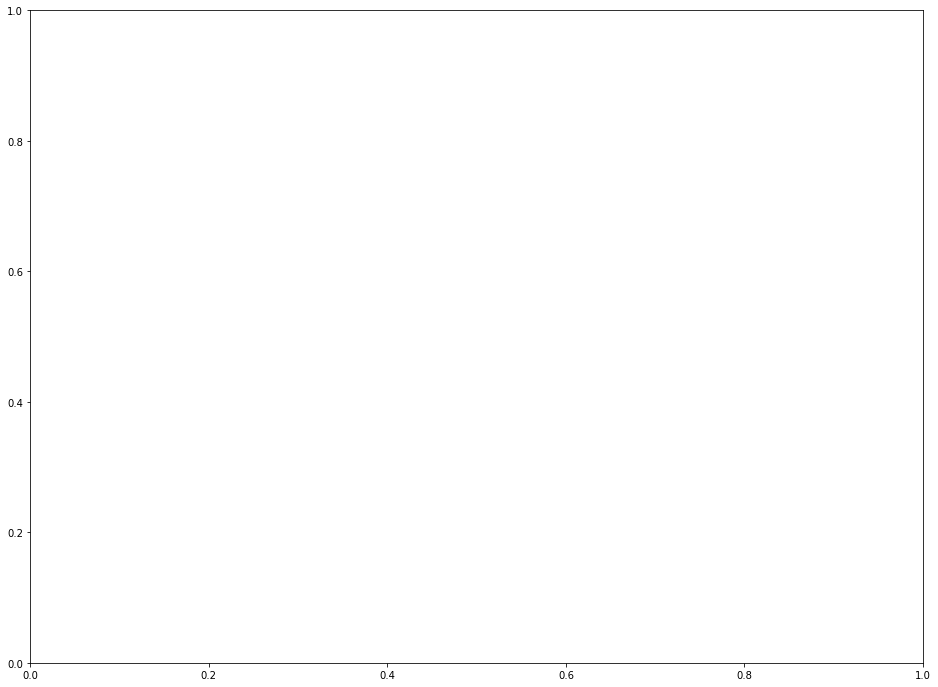

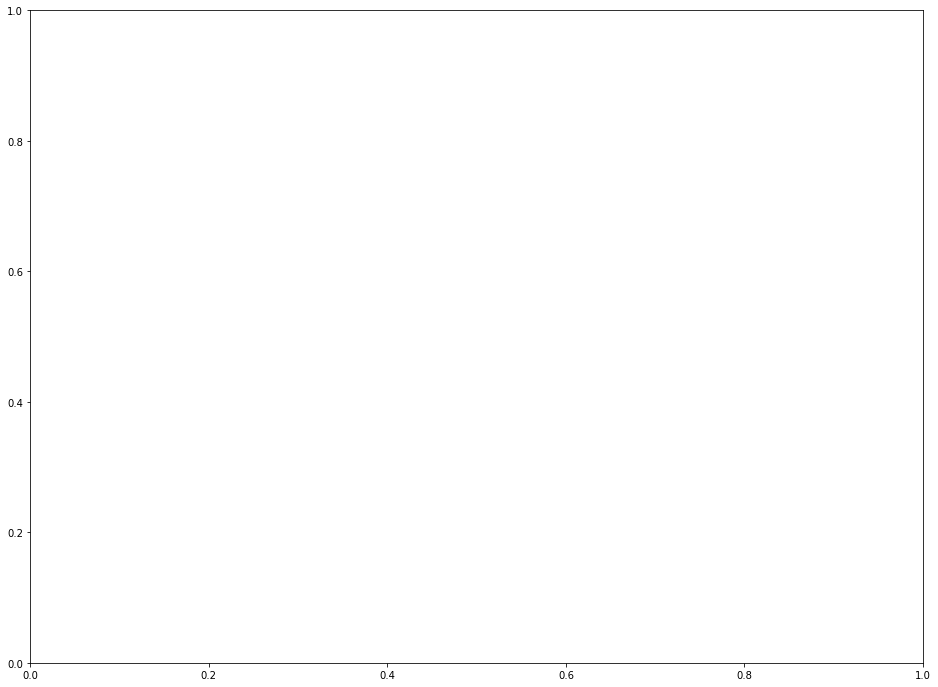

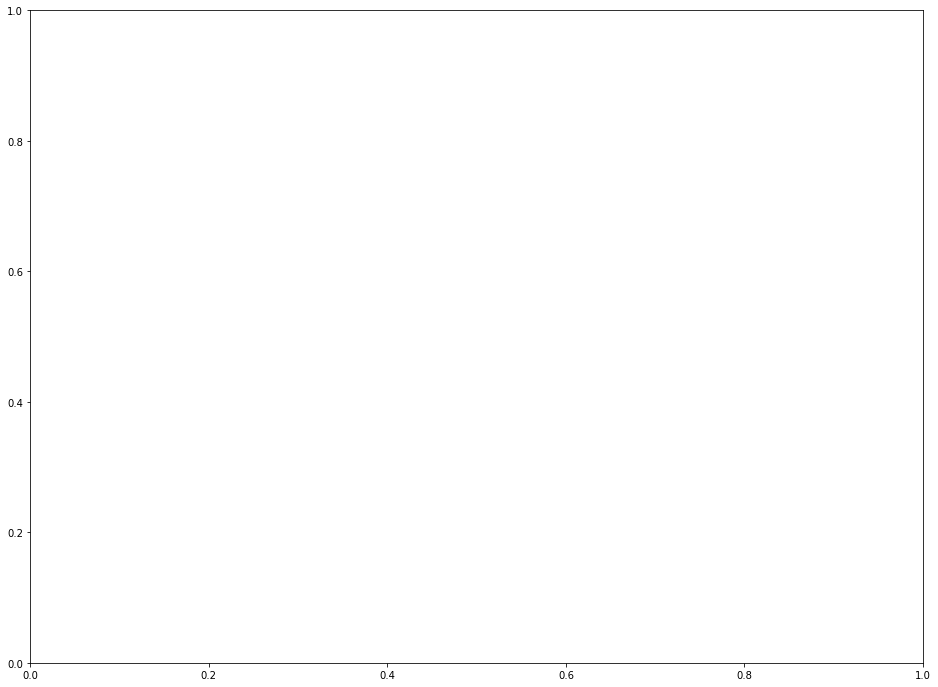

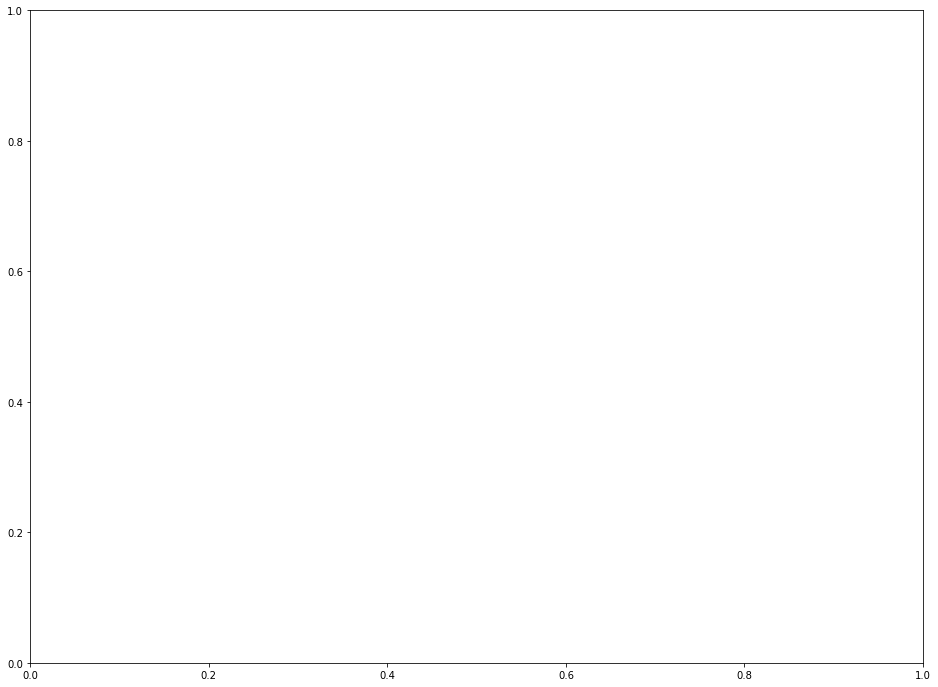

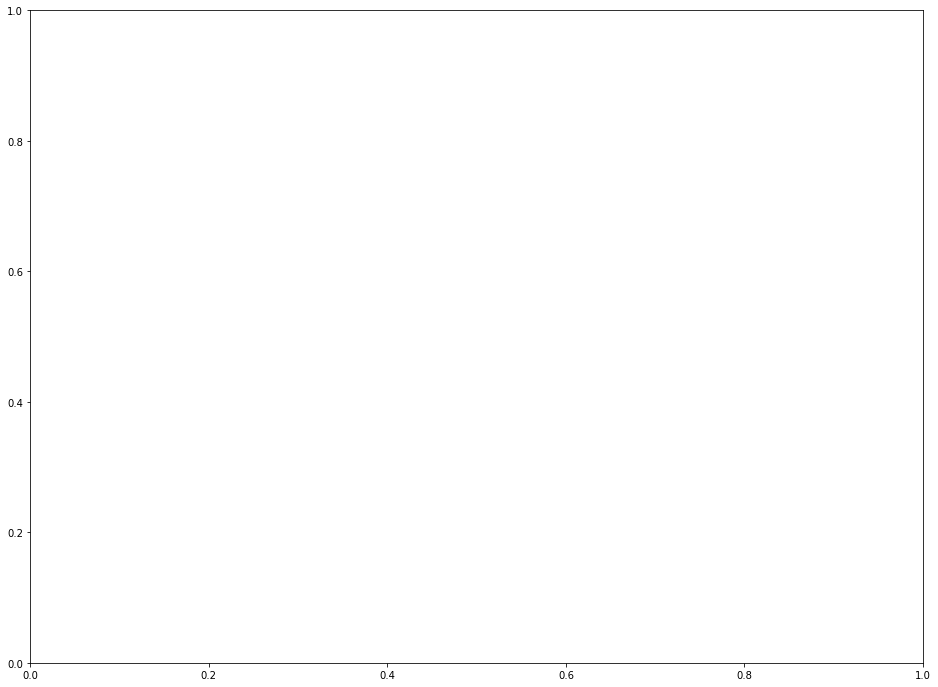

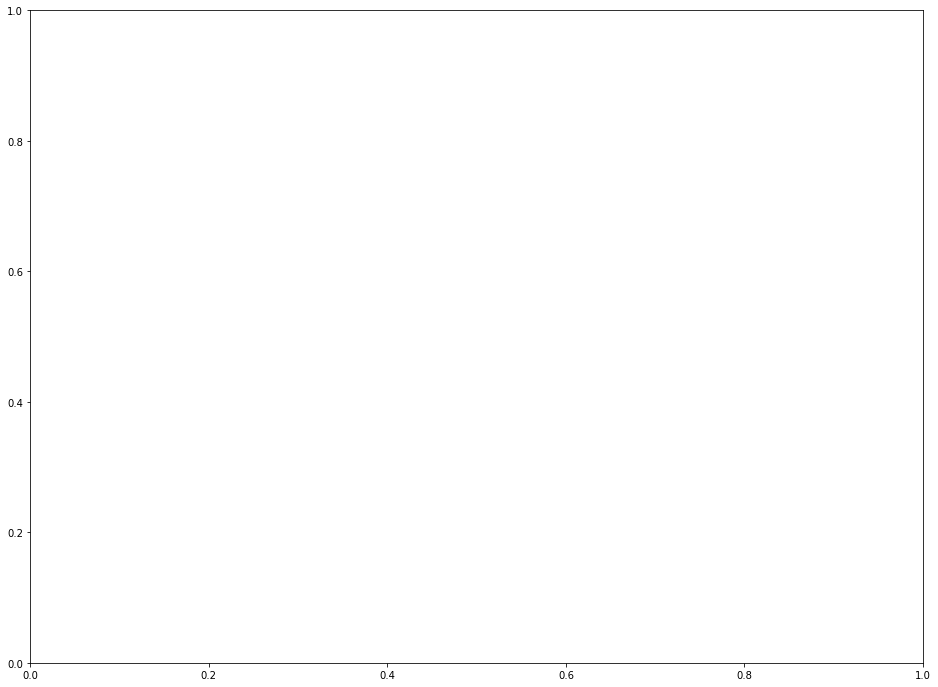

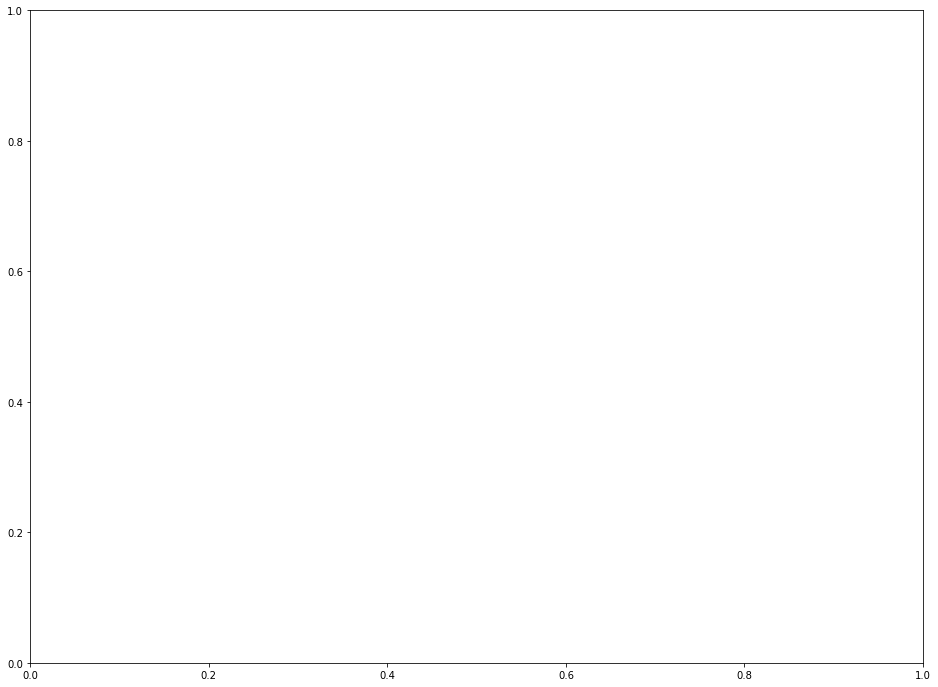

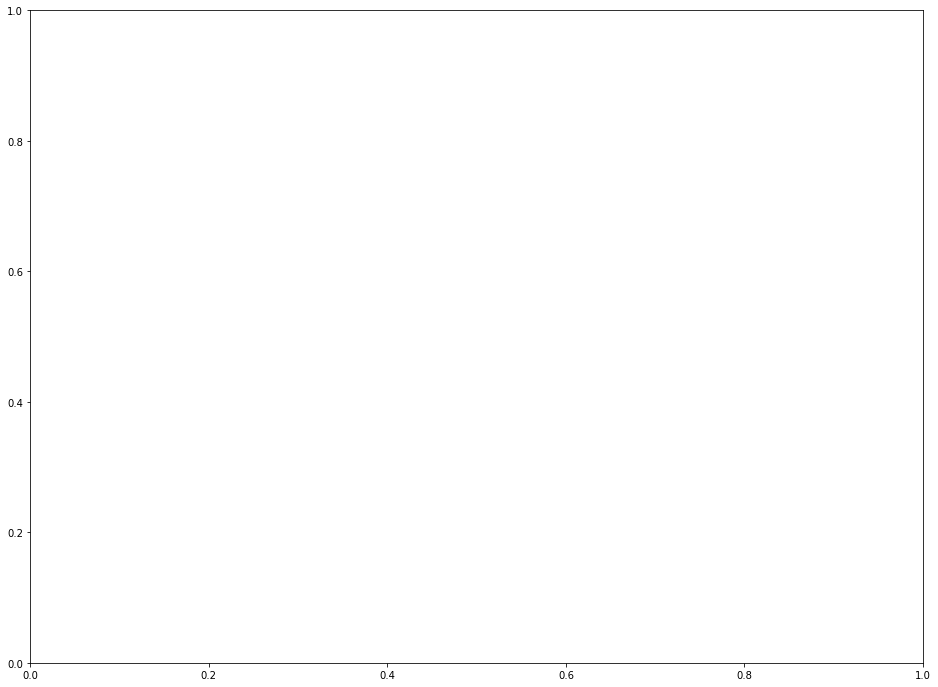

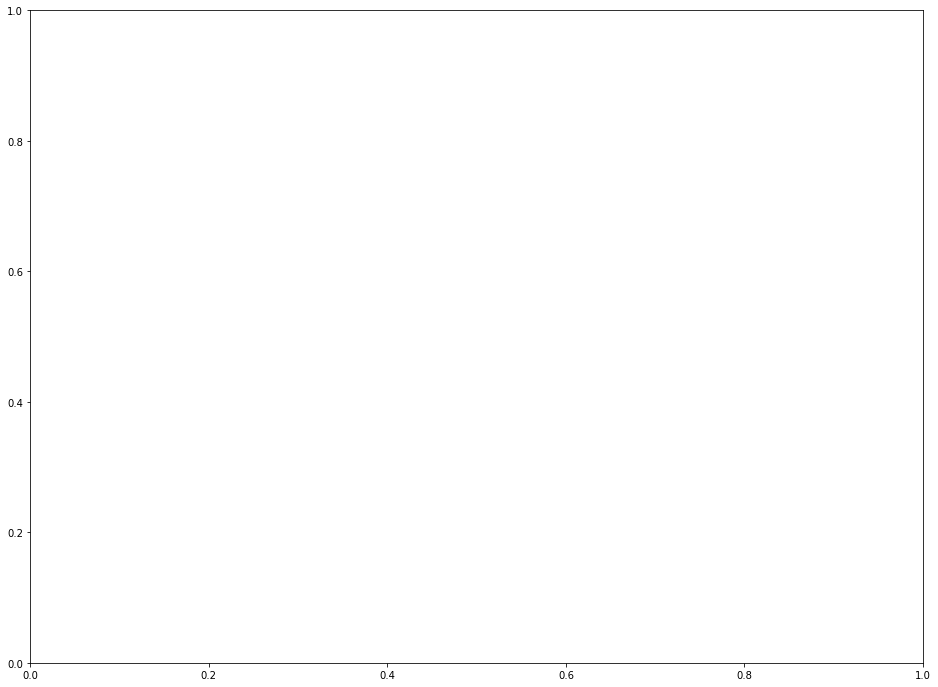

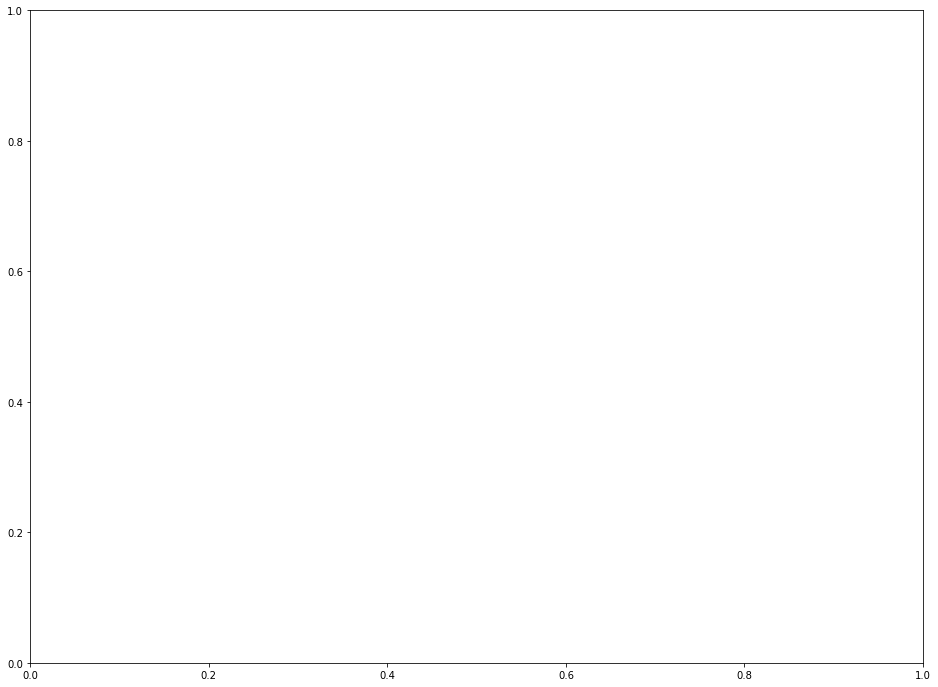

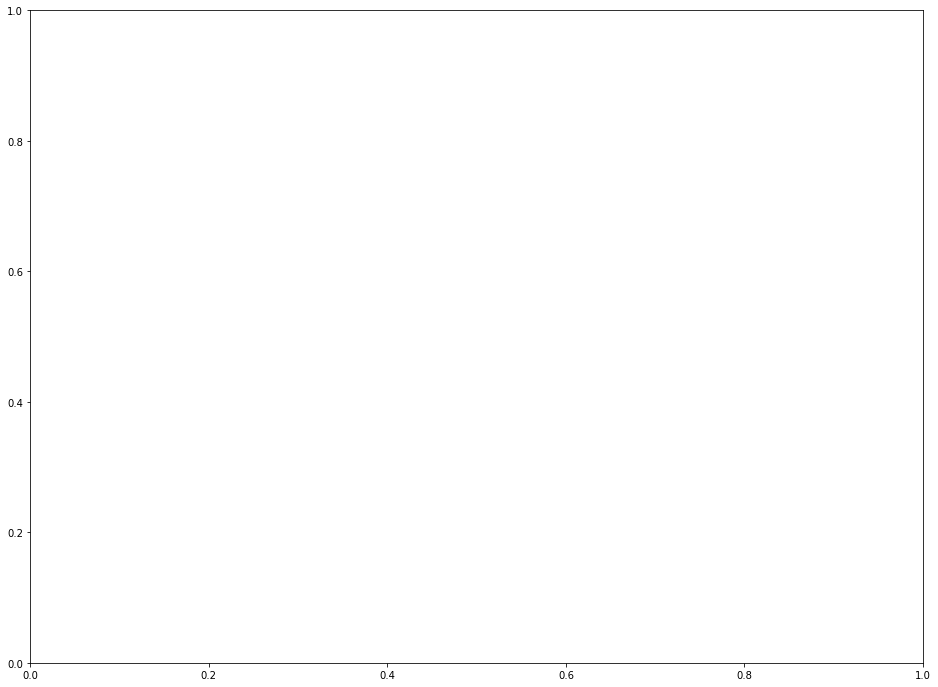

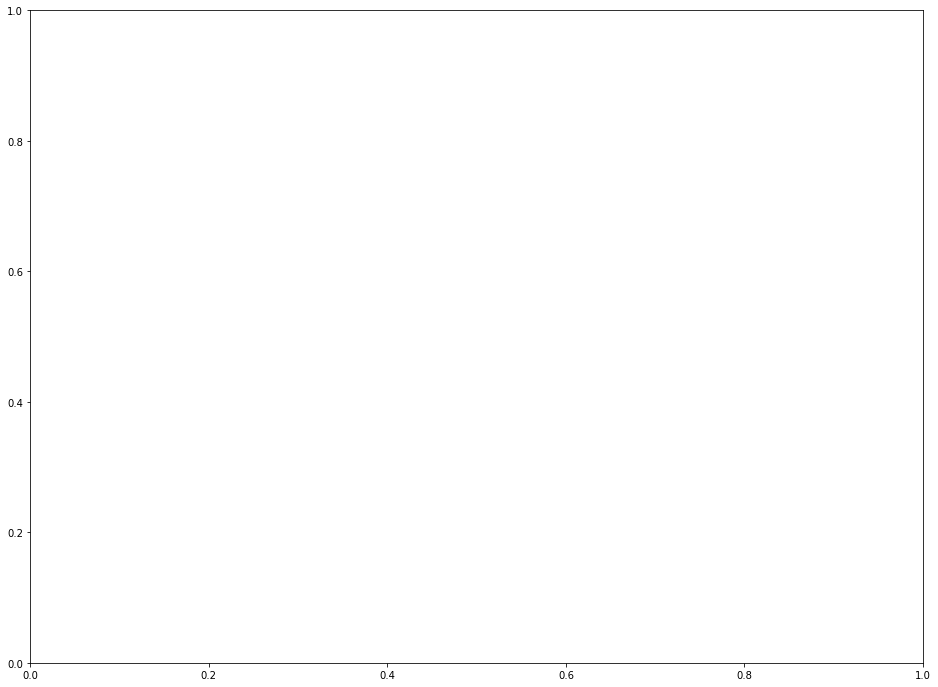

In [393]:
plotTsneAndSaveToFiles(df_learning_lab_n_iter, 'n_iter'+ str(n_i)+'_')

In [394]:
n_comp=2 
perplex=50.0 
early_exag=12.0 
l_rate=200.0 
rstate=42 
n_i= 1000 
n_i_progress=300

df_learning_lab_perplexity = tuneHyperparametersTsne(df=df_with_pm, scaled_df=scaled_df, n_components=n_comp, perplexity=perplex, early_exaggeration=early_exag, learning_rate=l_rate, 
random_state=rstate, n_iter= n_i, n_iter_without_progress=n_i_progress)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 726 entries, 201110 to 310113
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Gender                        726 non-null    float64
 1   IC                            726 non-null    int64  
 2   Zip-code                      726 non-null    int64  
 3   Geboortedatum                 726 non-null    int64  
 4   Leeftijd (op testdag)         726 non-null    float64
 5   AST (tijd afgerond op 0.1s)   726 non-null    float64
 6   MQ                            726 non-null    float64
 7   MQ catogory                   726 non-null    float64
 8   Lengte (afgerond op 0.1 cm)   726 non-null    float64
 9   Gewicht (afgerond op 0.1 kg)  726 non-null    float64
 10  Lengte (in m)                 726 non-null    float64
 11  BMI                           726 non-null    float64
 12  Gymles                        726 non-null    float64
 1

/tmp/ipykernel_36906/3569143405.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(16, 12))


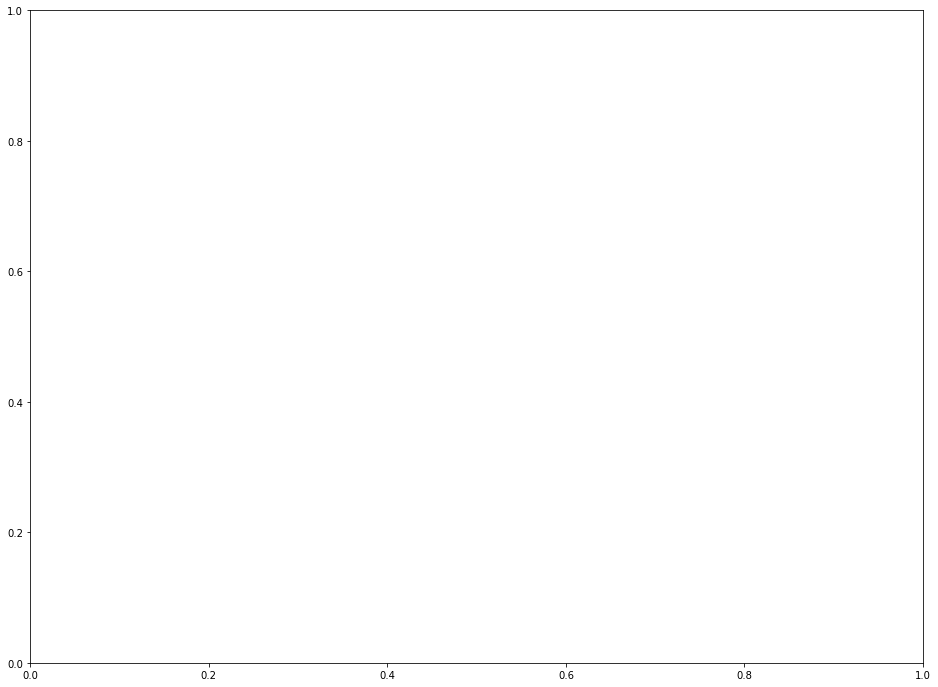

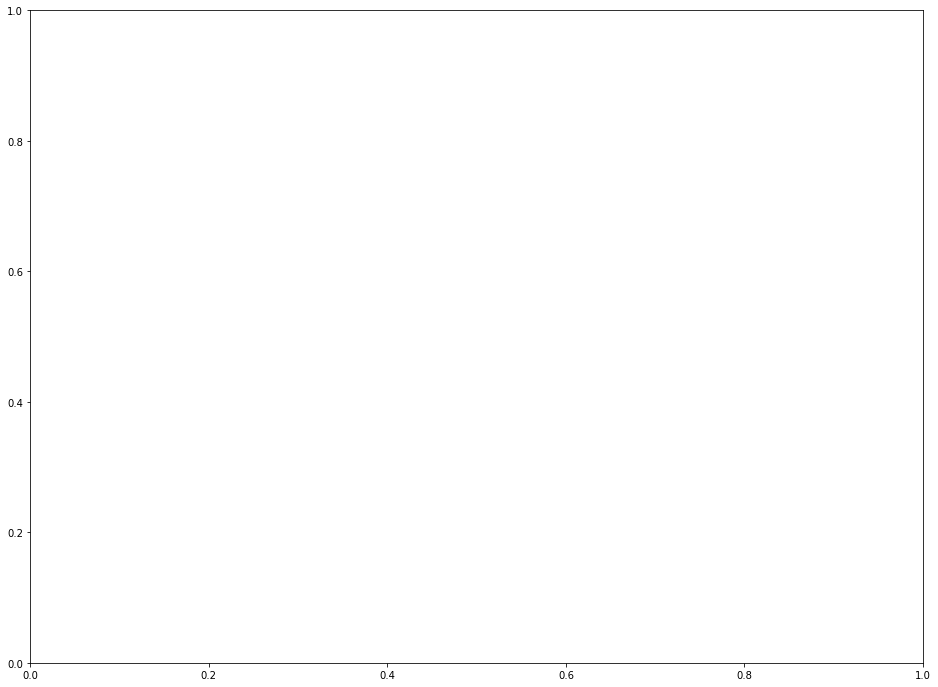

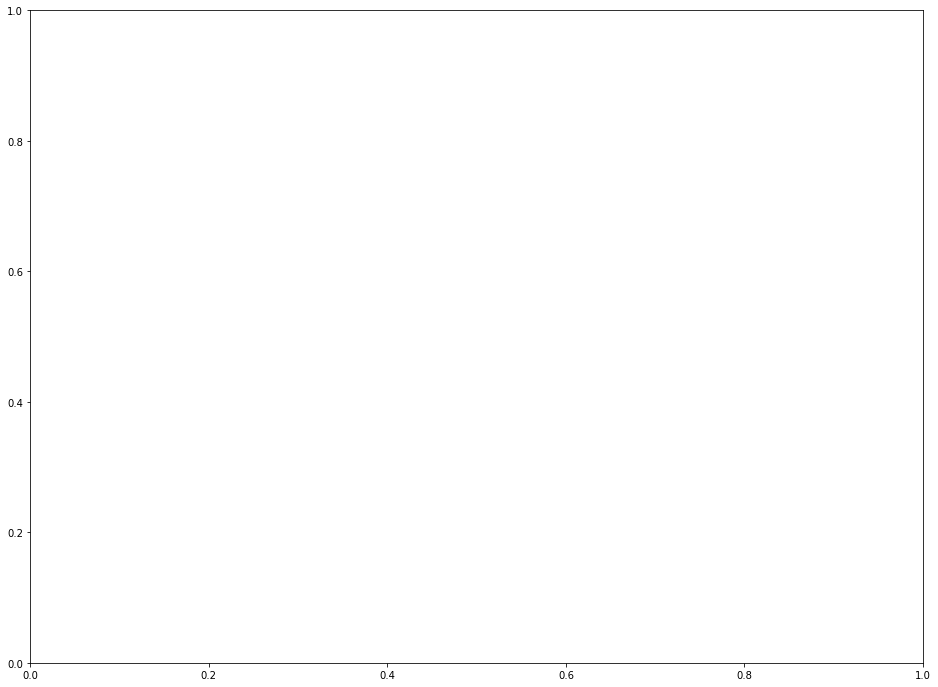

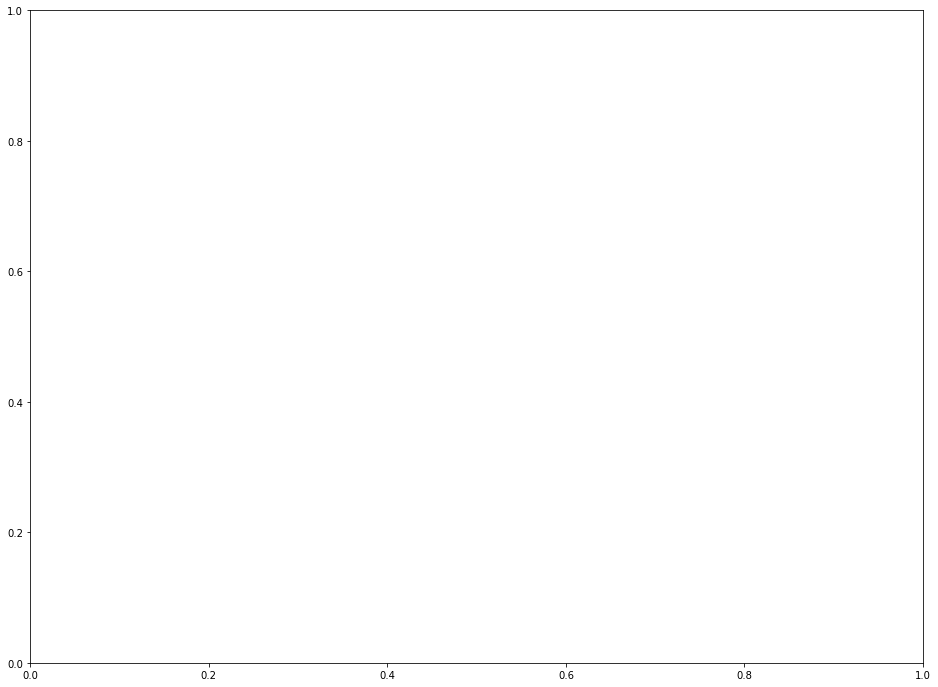

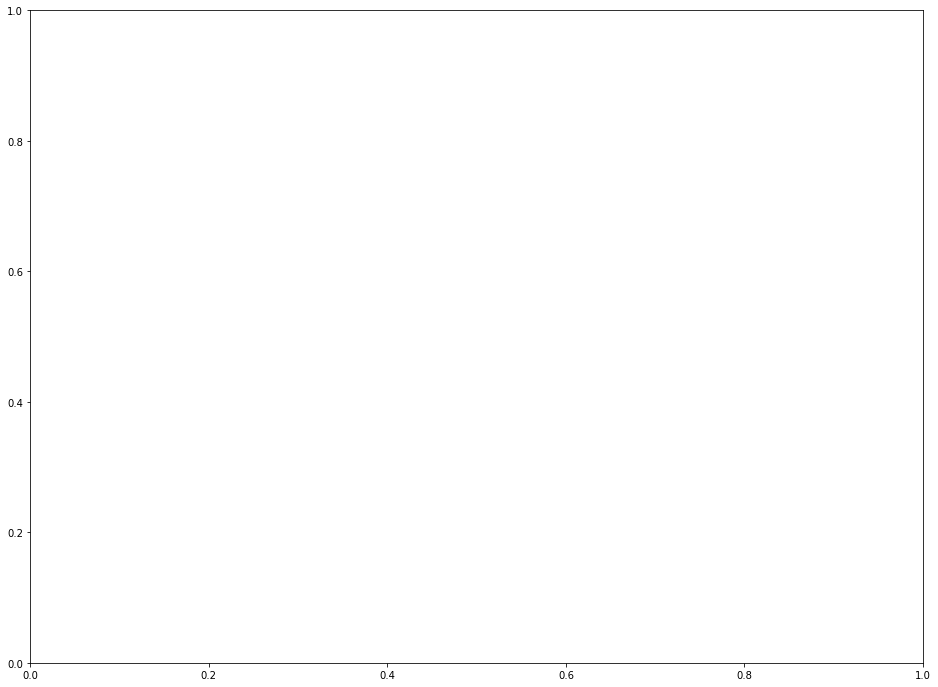

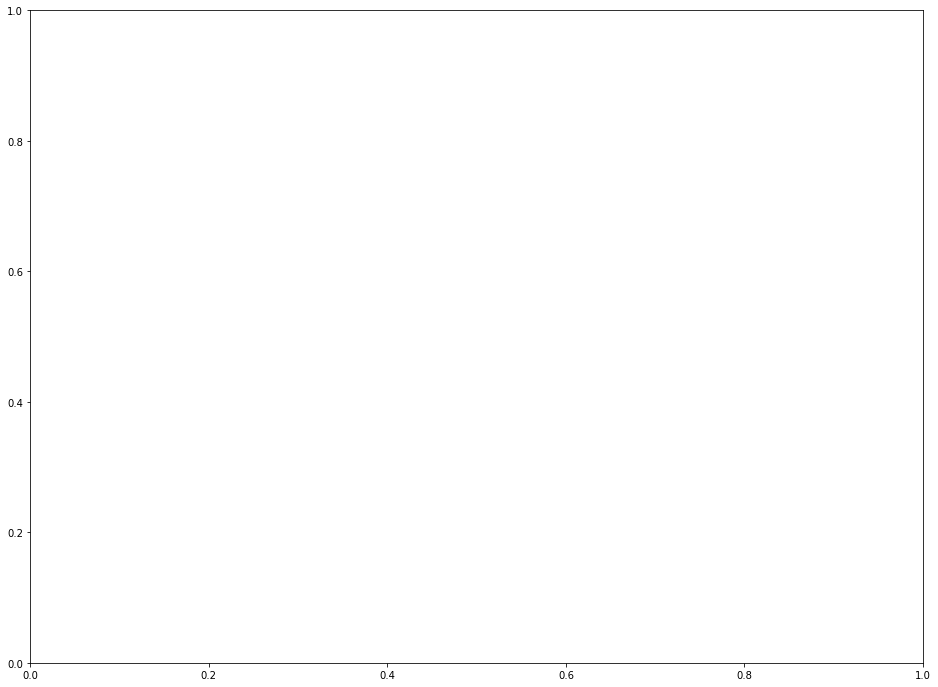

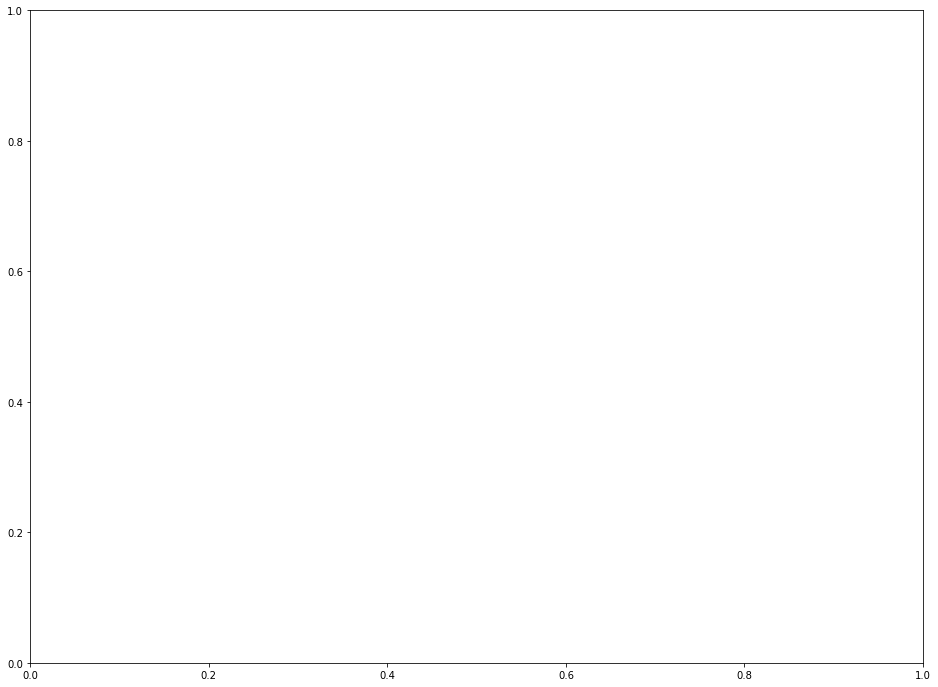

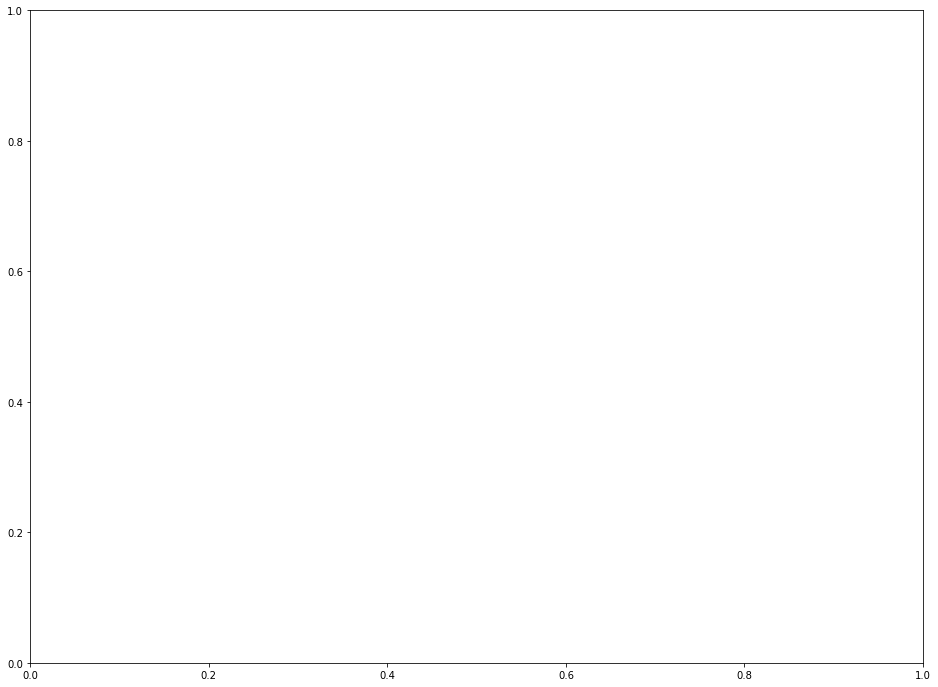

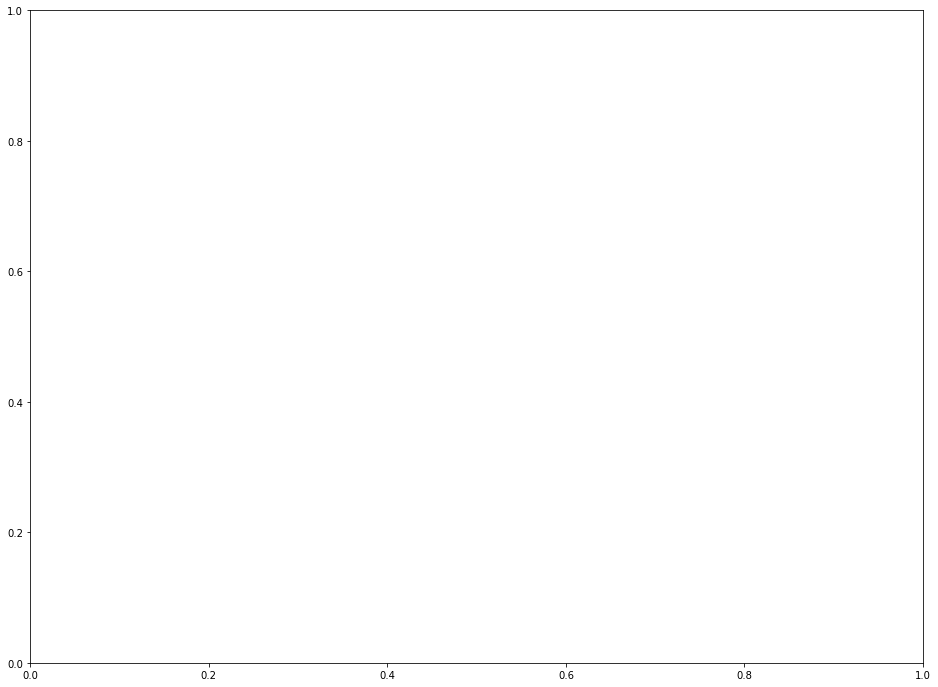

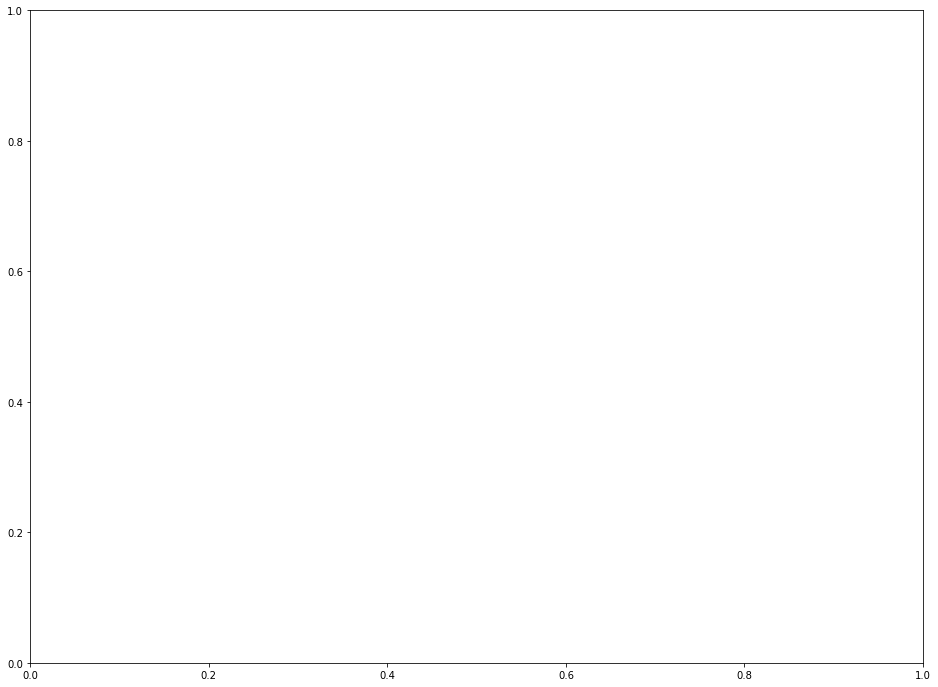

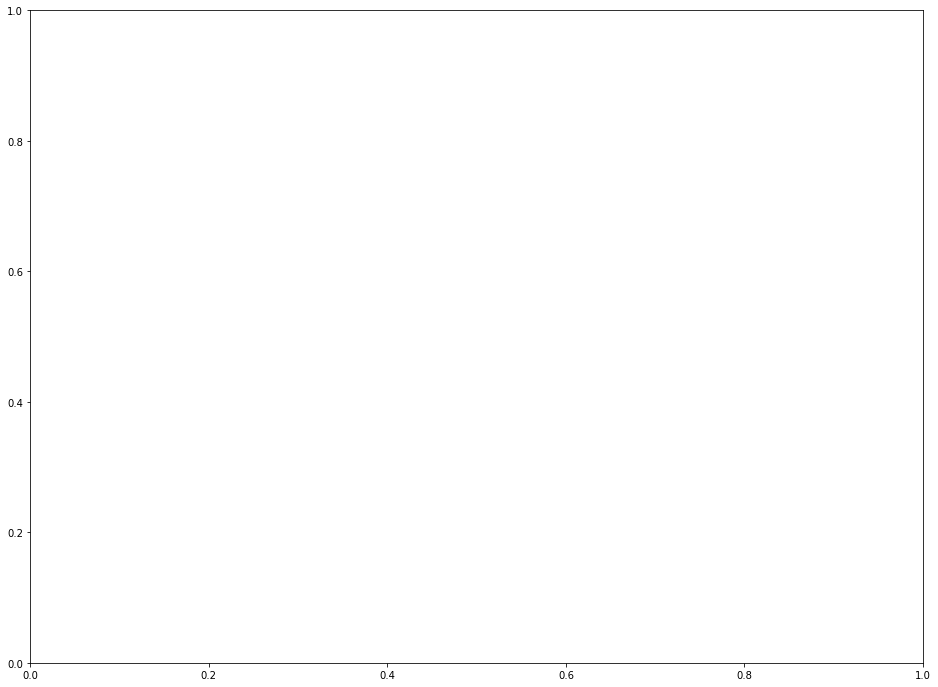

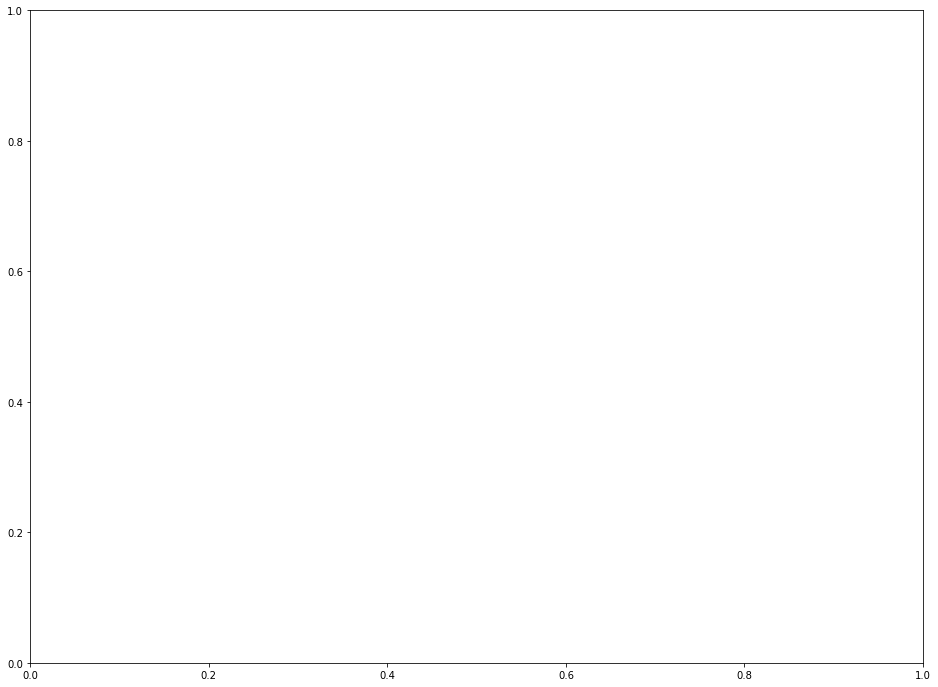

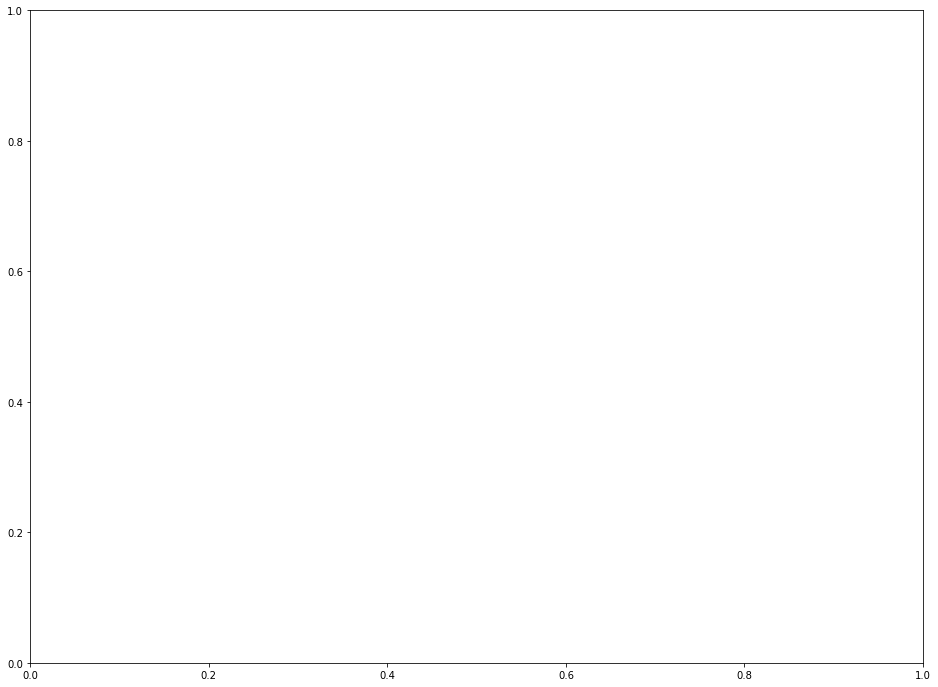

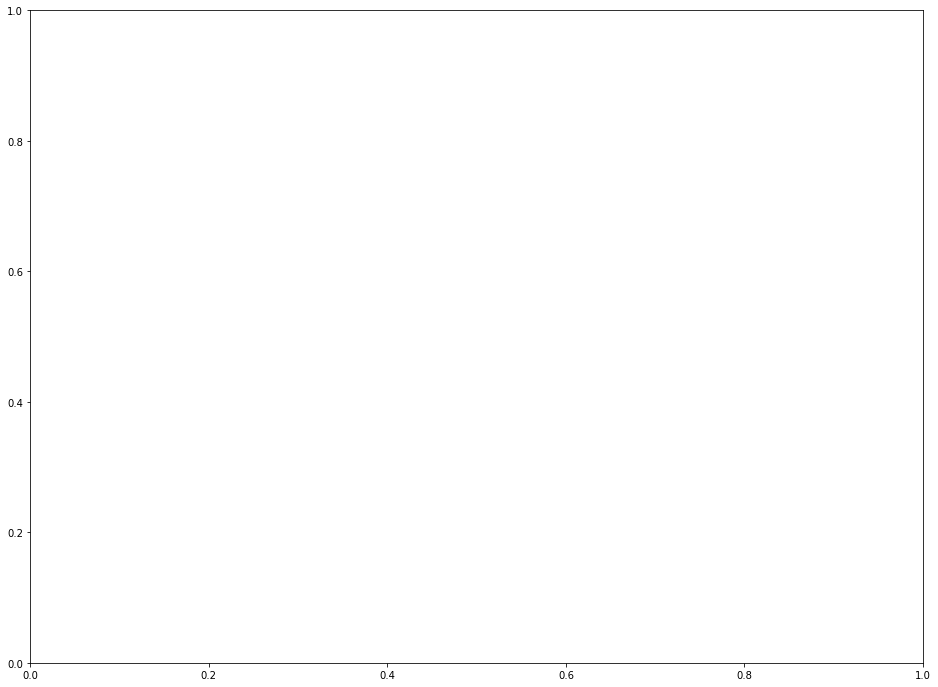

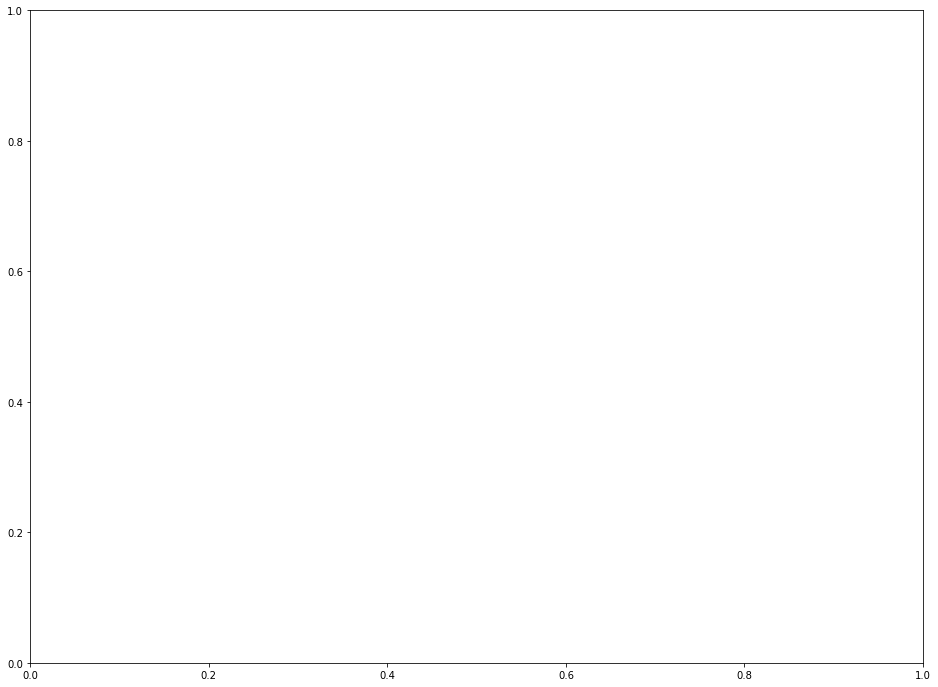

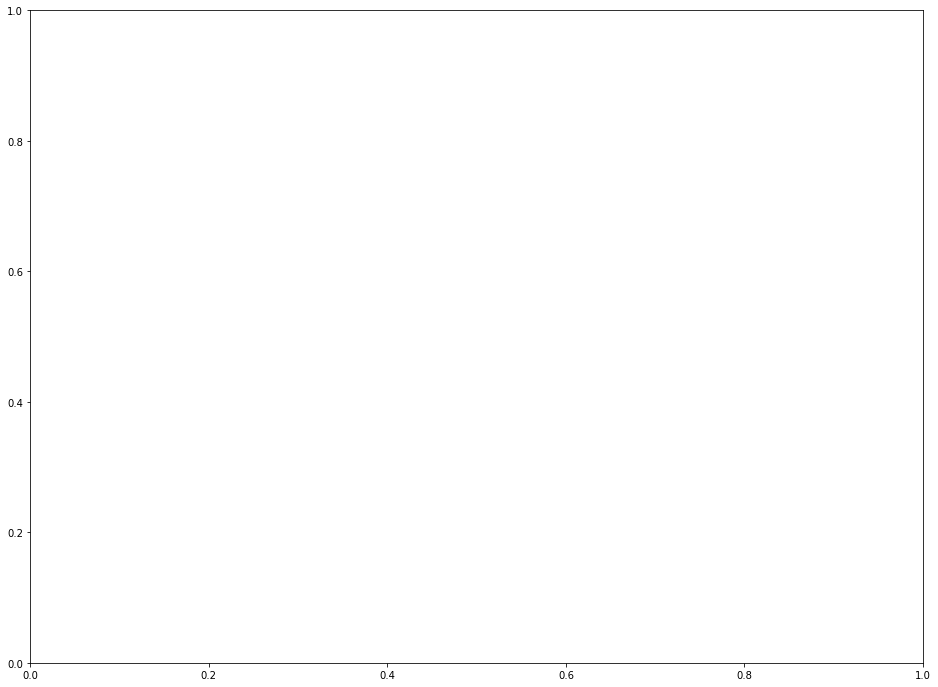

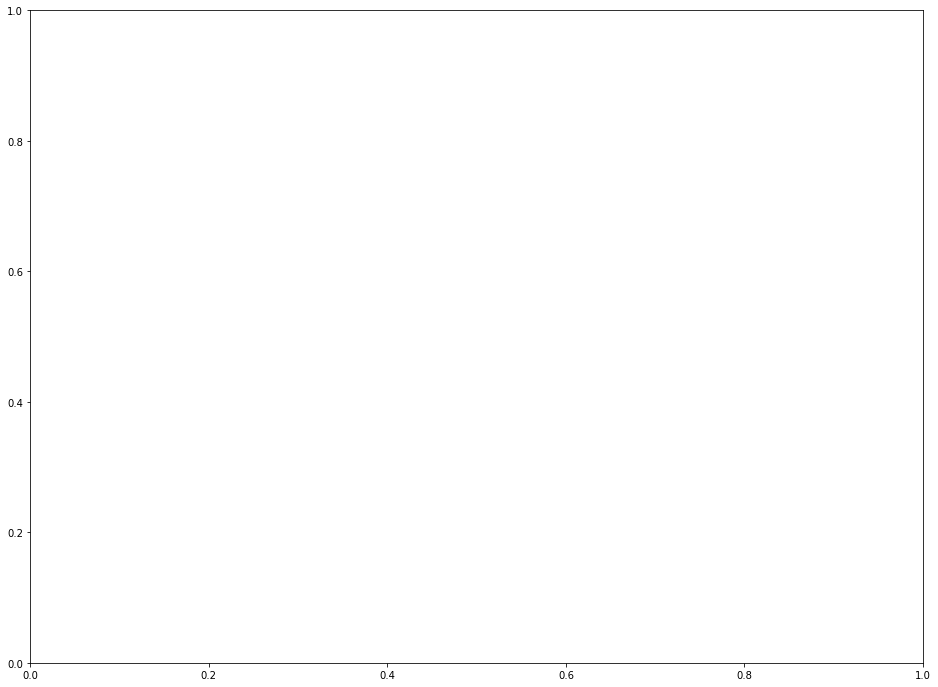

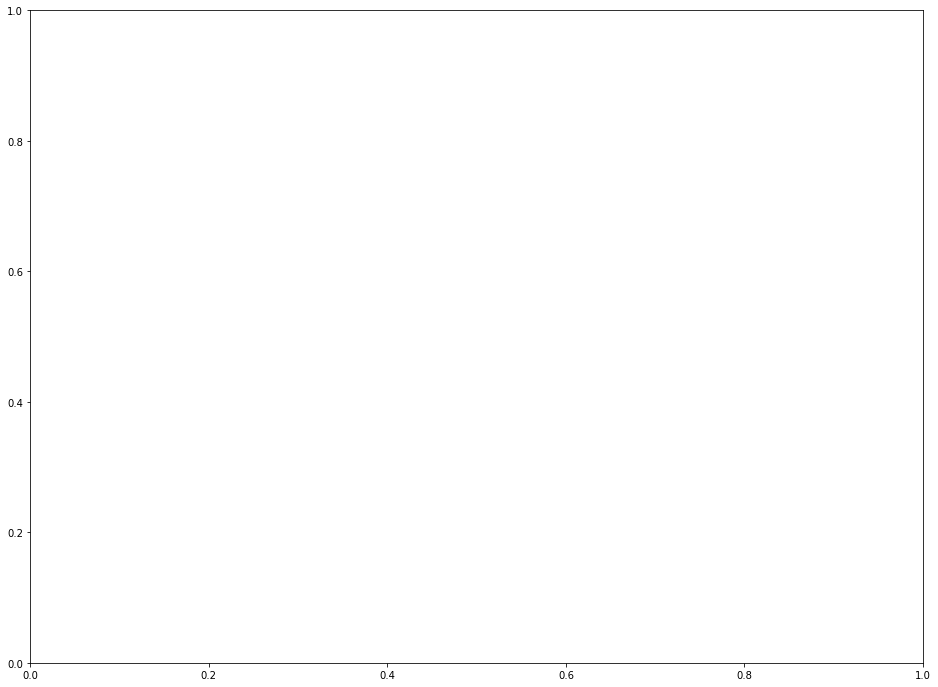

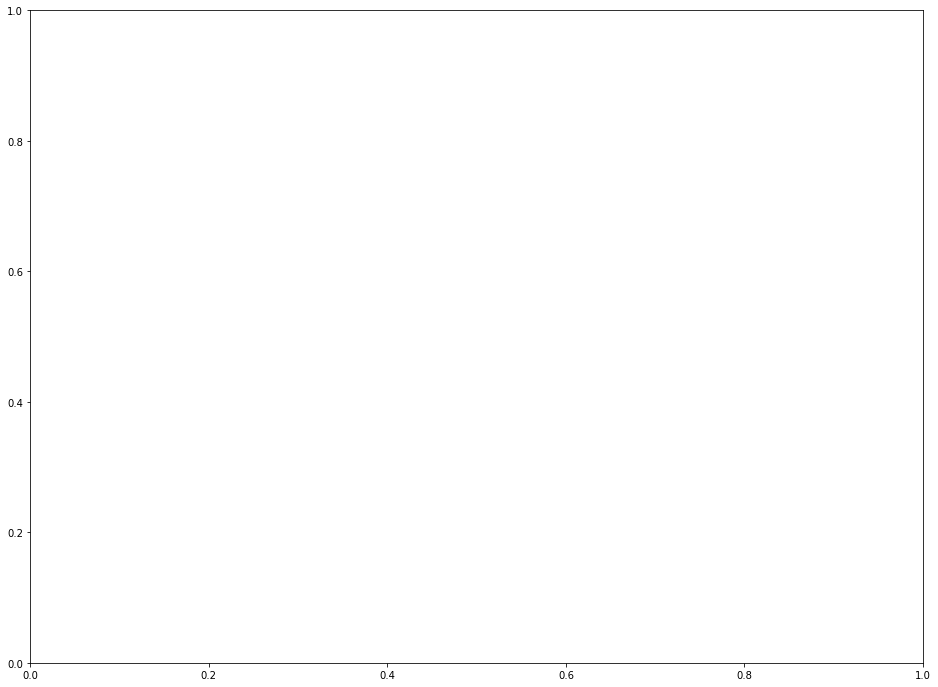

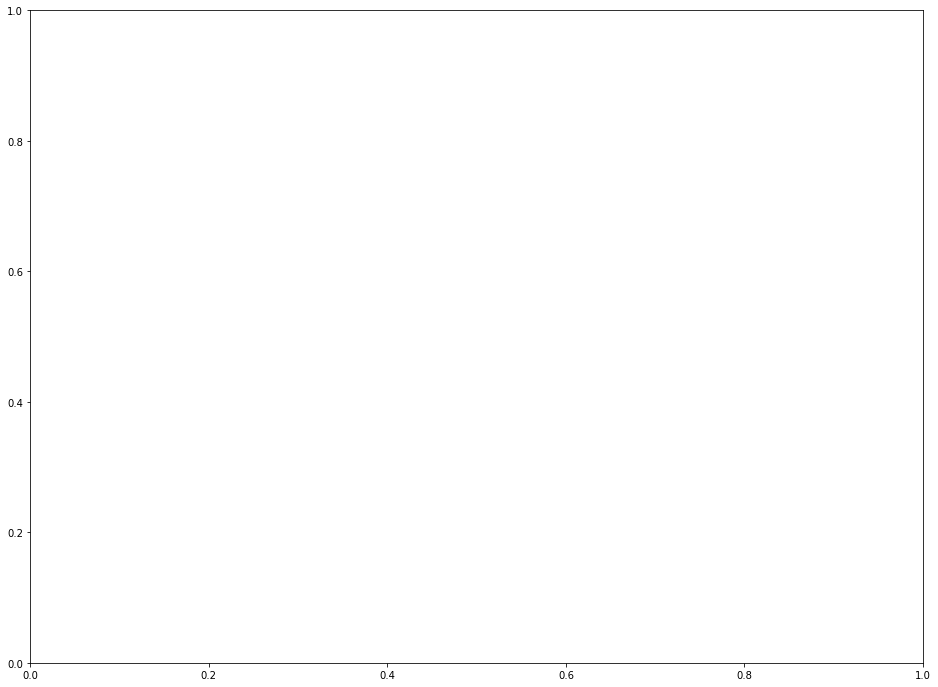

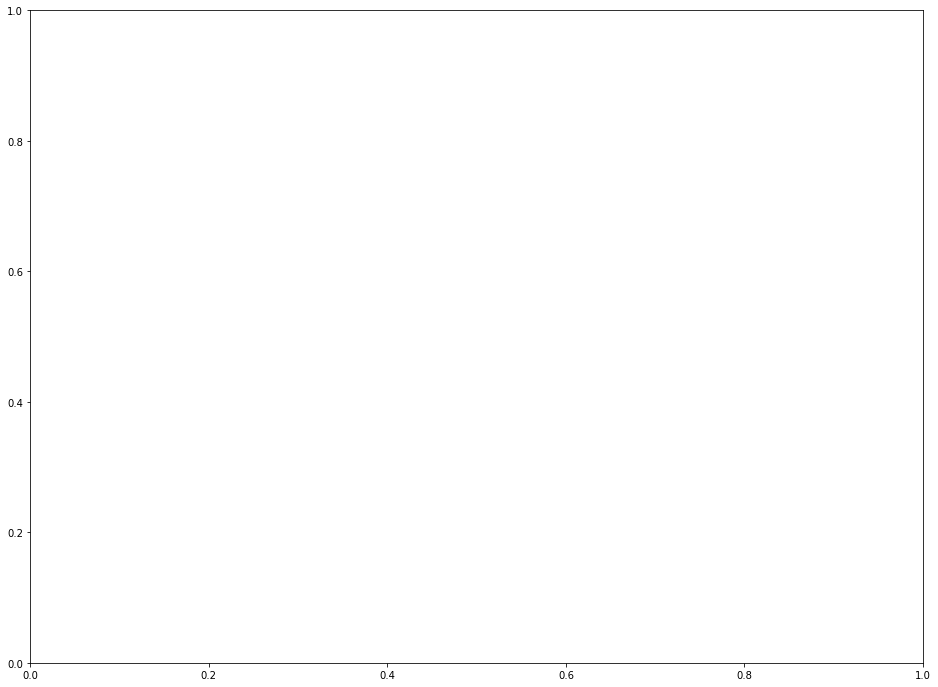

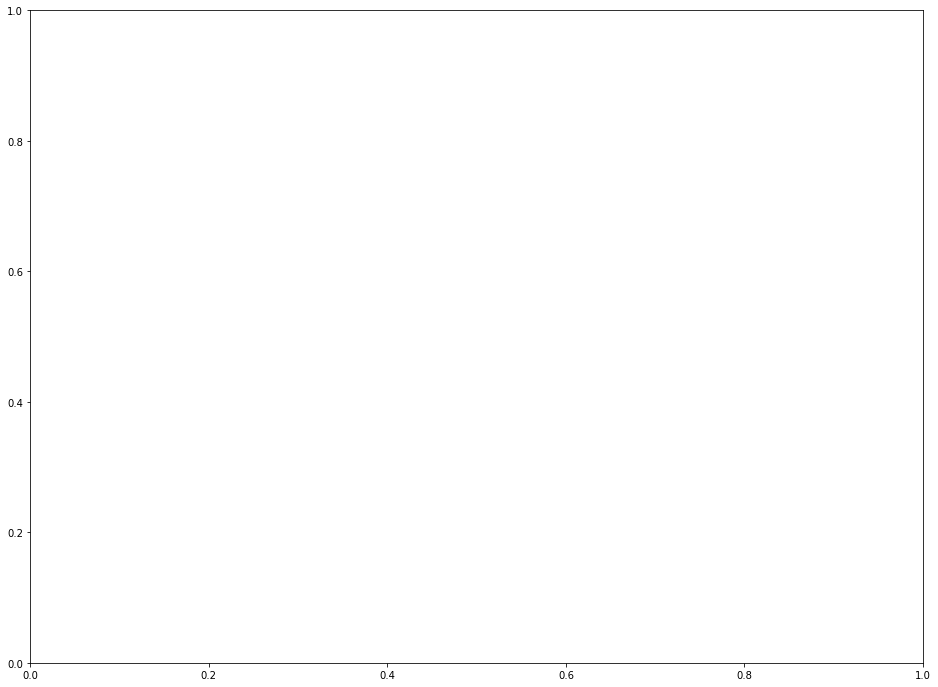

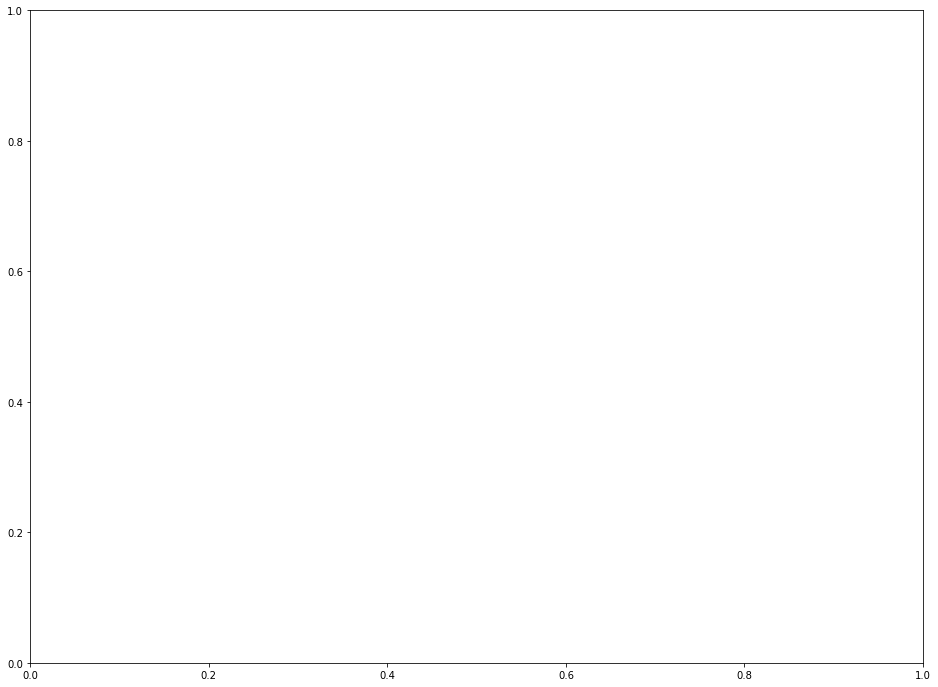

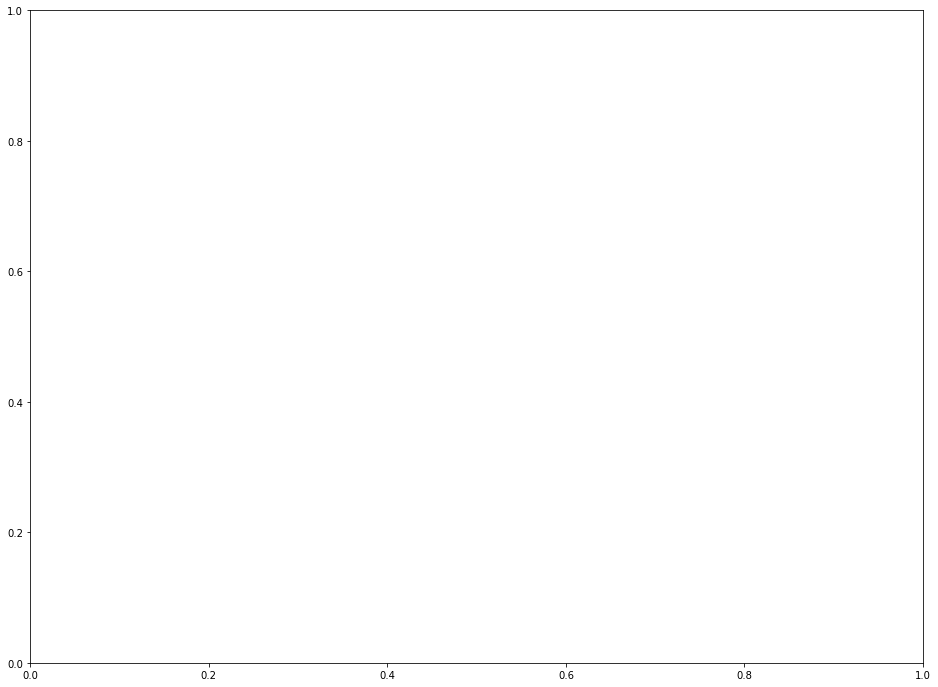

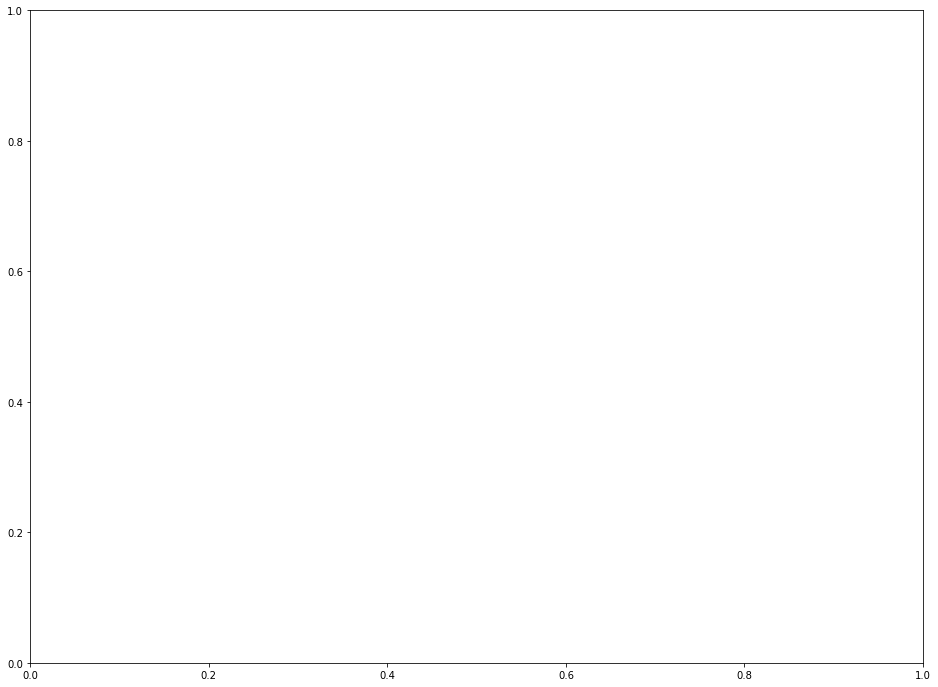

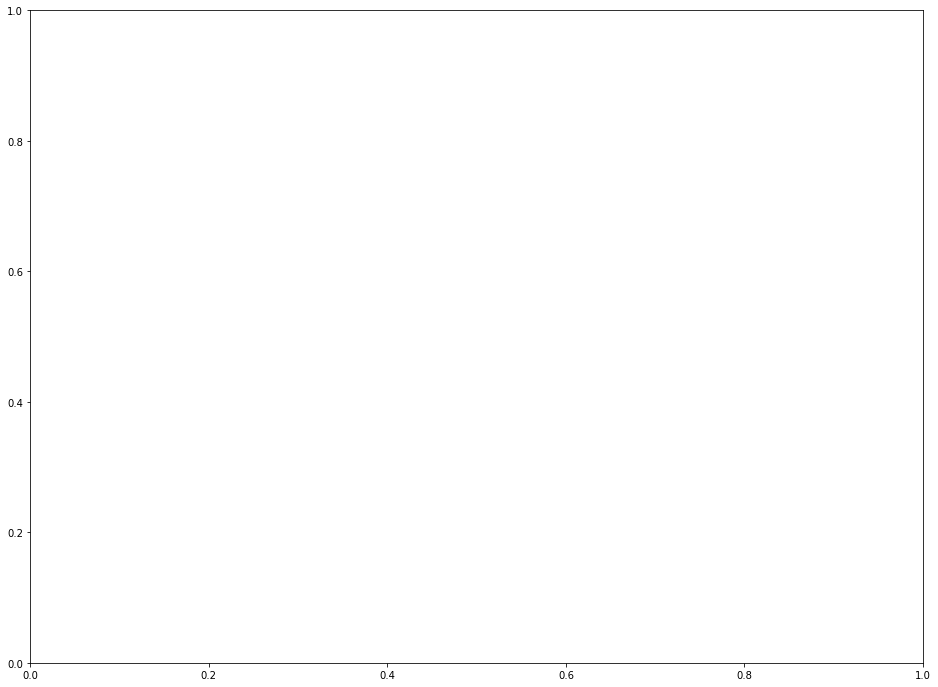

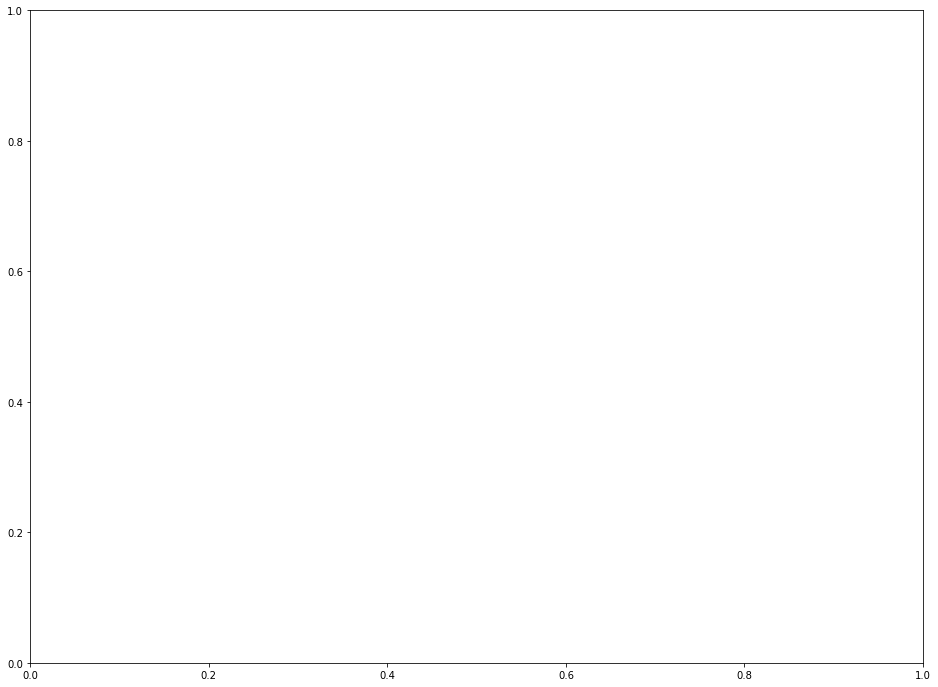

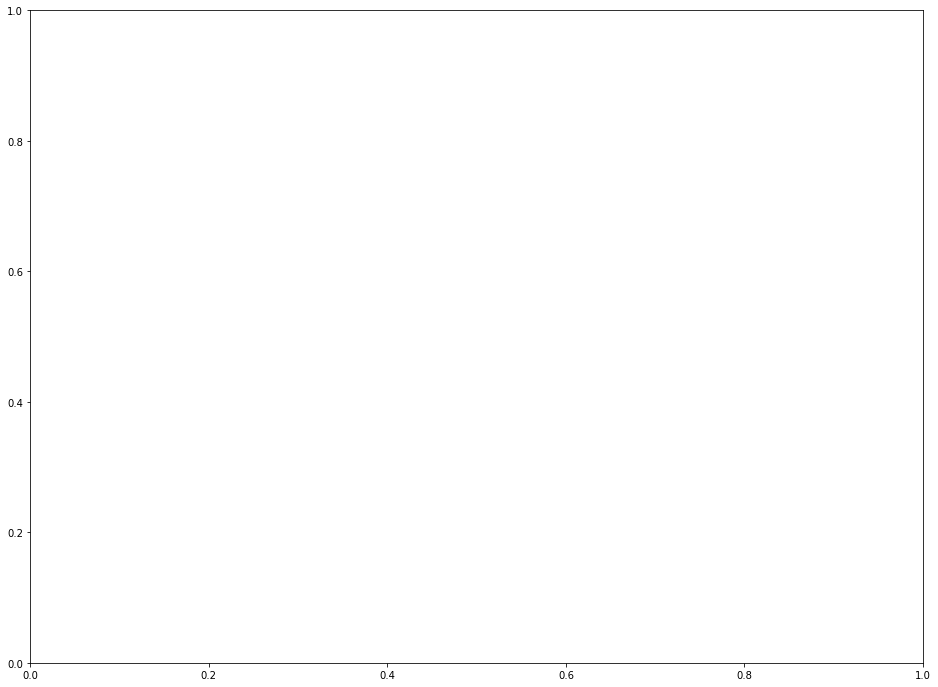

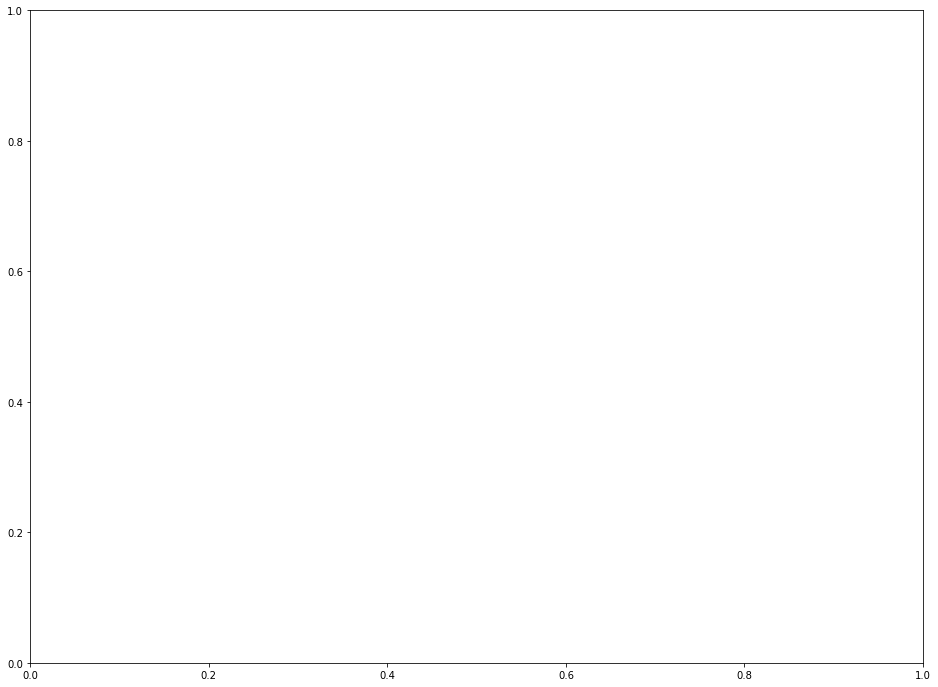

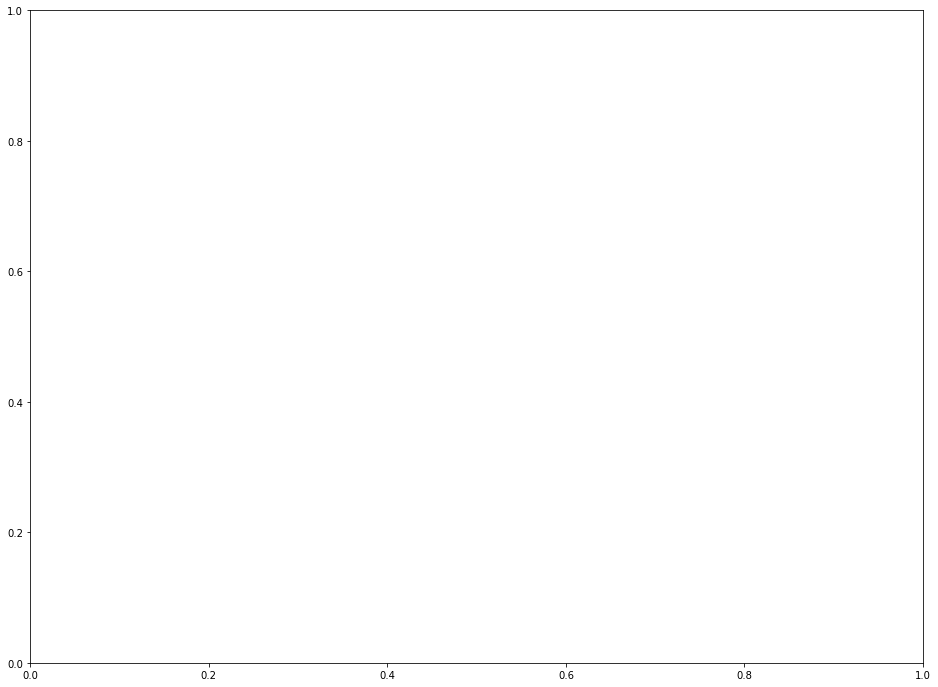

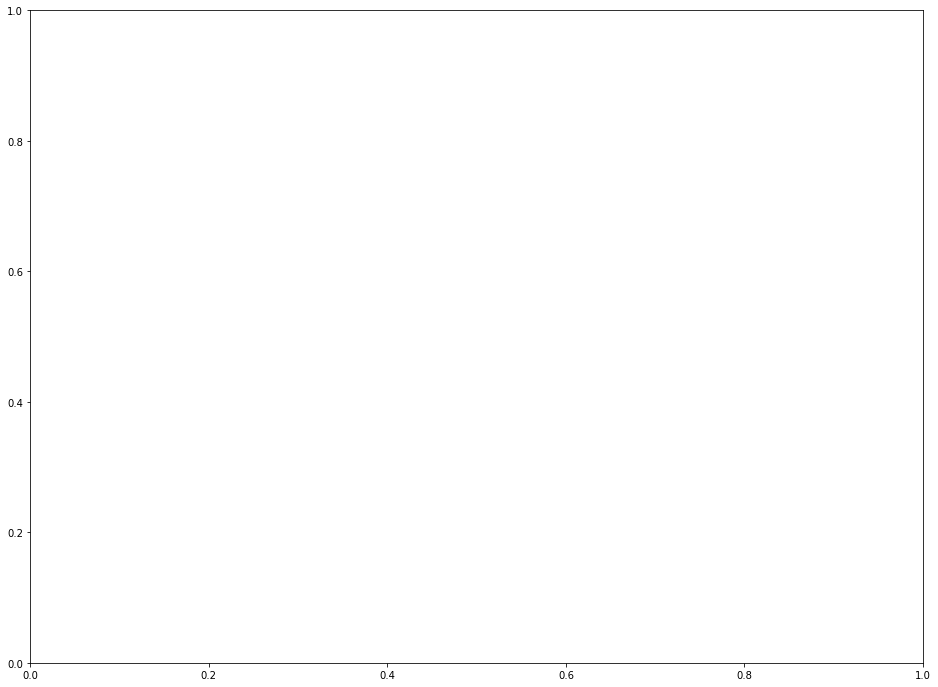

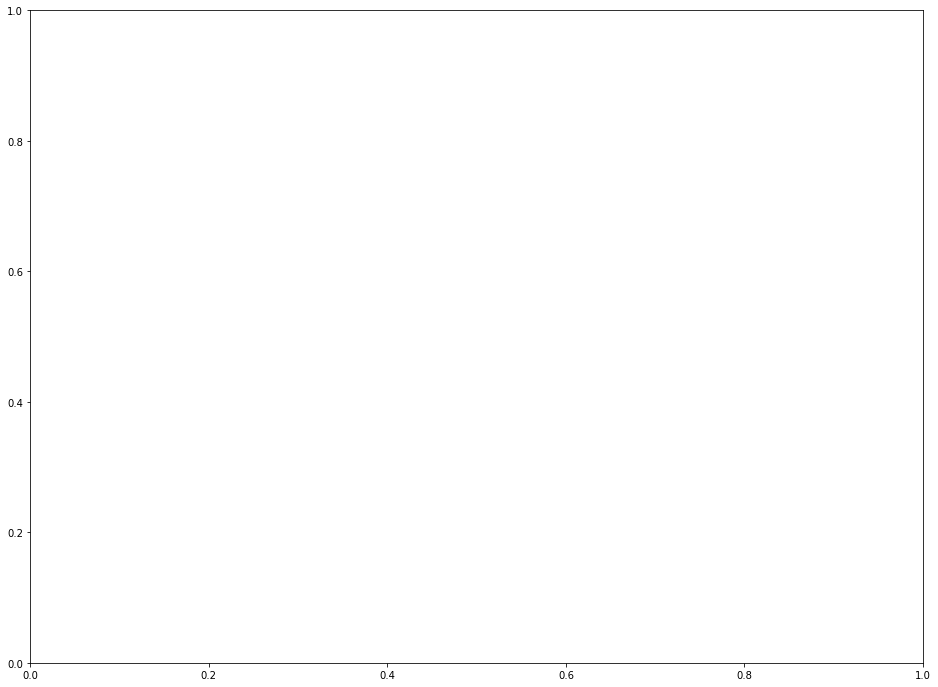

In [395]:
plotTsneAndSaveToFiles(df_learning_lab_perplexity, 'perplexity' + str(perplex) + '_')

In [396]:
n_comp=2 
perplex=30.0 
early_exag=100.0 
l_rate=200.0 
rstate=42 
n_i= 1000 
n_i_progress=300

df_marketing_exaggeration = tuneHyperparametersTsne(df=df_with_pm, scaled_df=scaled_df, n_components=n_comp, perplexity=perplex, early_exaggeration=early_exag, learning_rate=l_rate, 
random_state=rstate, n_iter= n_i, n_iter_without_progress=n_i_progress)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 726 entries, 201110 to 310113
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Gender                        726 non-null    float64
 1   IC                            726 non-null    int64  
 2   Zip-code                      726 non-null    int64  
 3   Geboortedatum                 726 non-null    int64  
 4   Leeftijd (op testdag)         726 non-null    float64
 5   AST (tijd afgerond op 0.1s)   726 non-null    float64
 6   MQ                            726 non-null    float64
 7   MQ catogory                   726 non-null    float64
 8   Lengte (afgerond op 0.1 cm)   726 non-null    float64
 9   Gewicht (afgerond op 0.1 kg)  726 non-null    float64
 10  Lengte (in m)                 726 non-null    float64
 11  BMI                           726 non-null    float64
 12  Gymles                        726 non-null    float64
 1

/tmp/ipykernel_36906/3569143405.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(16, 12))


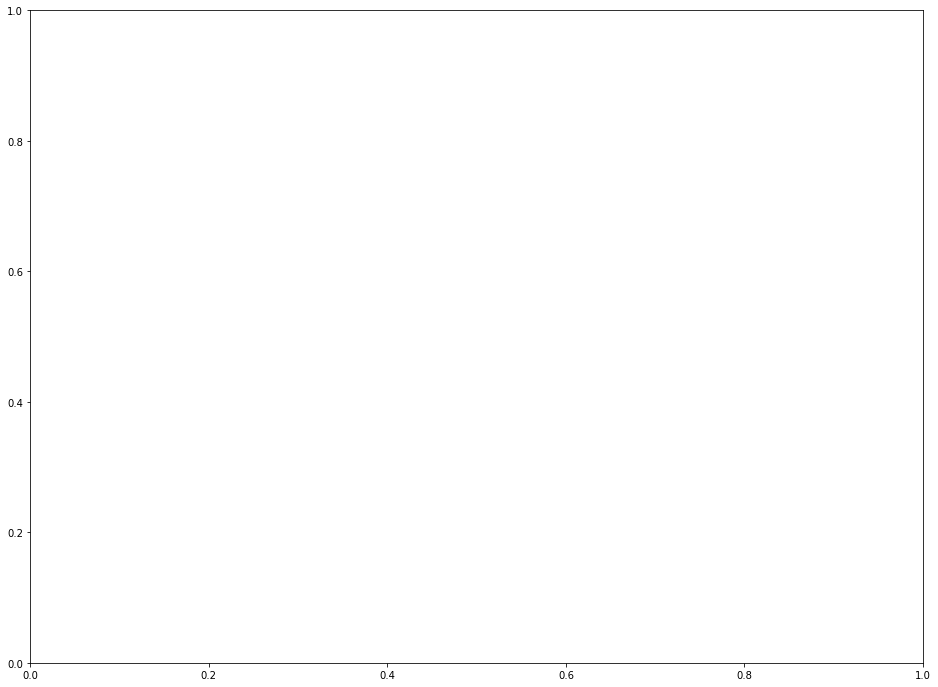

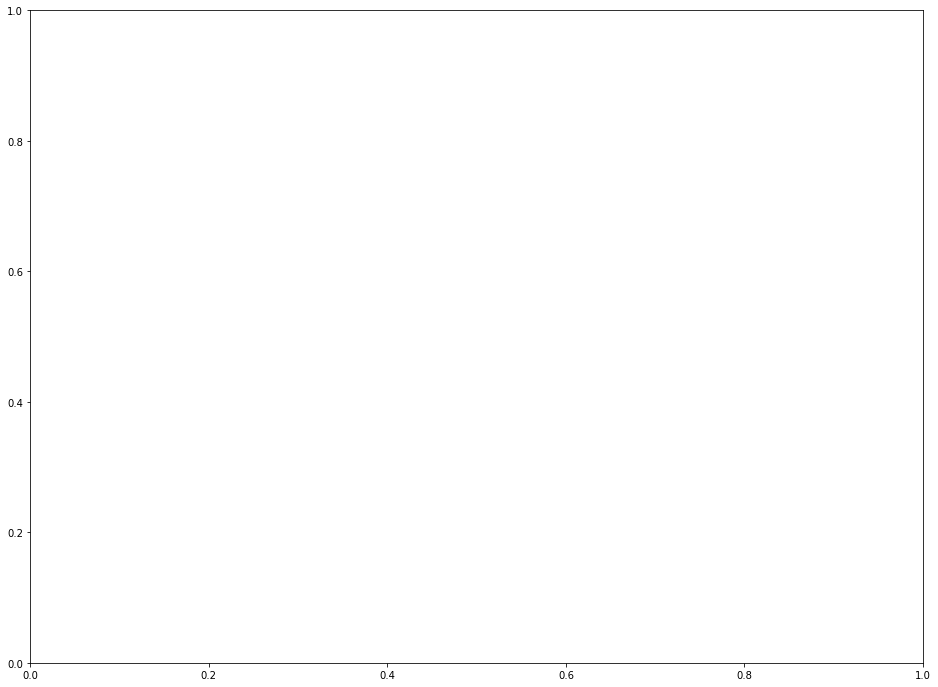

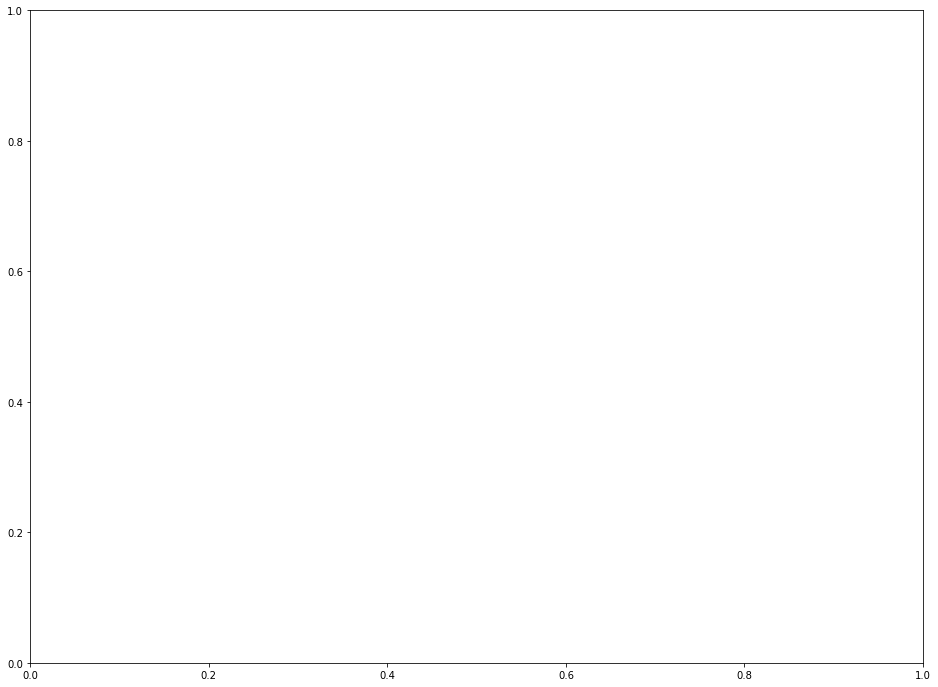

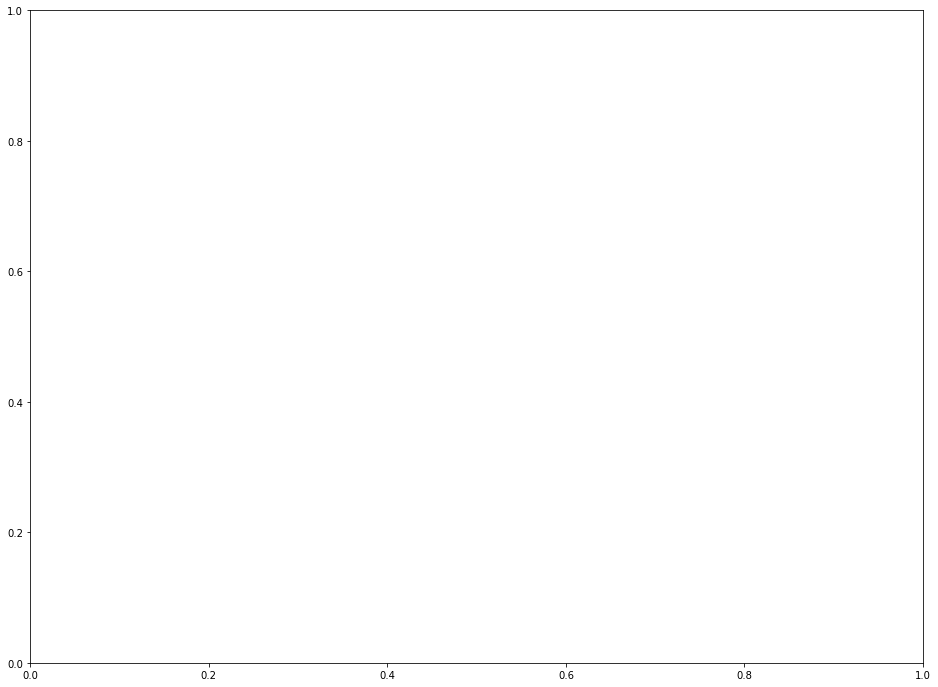

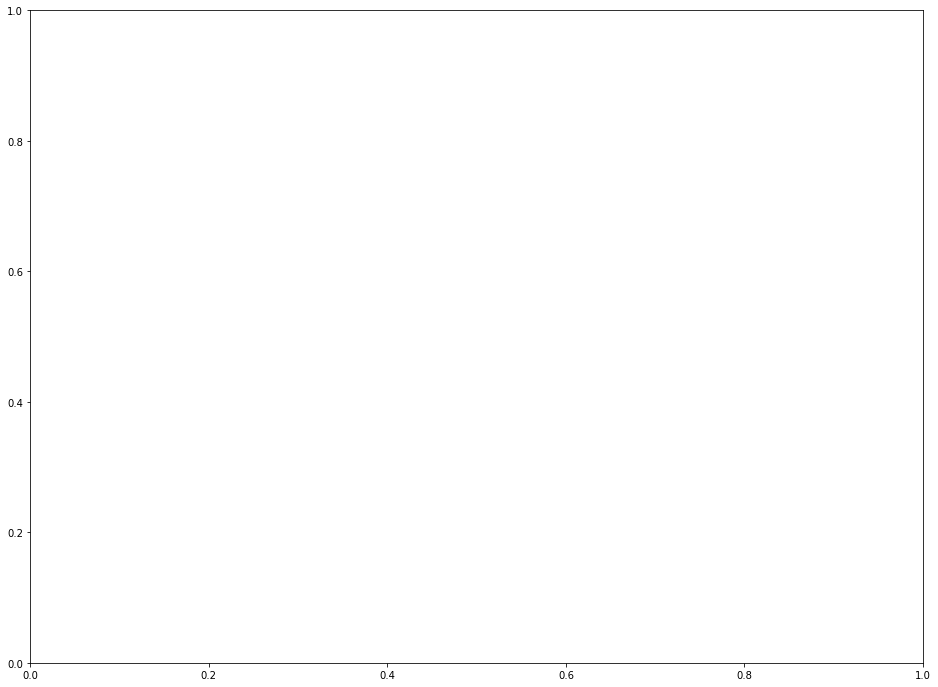

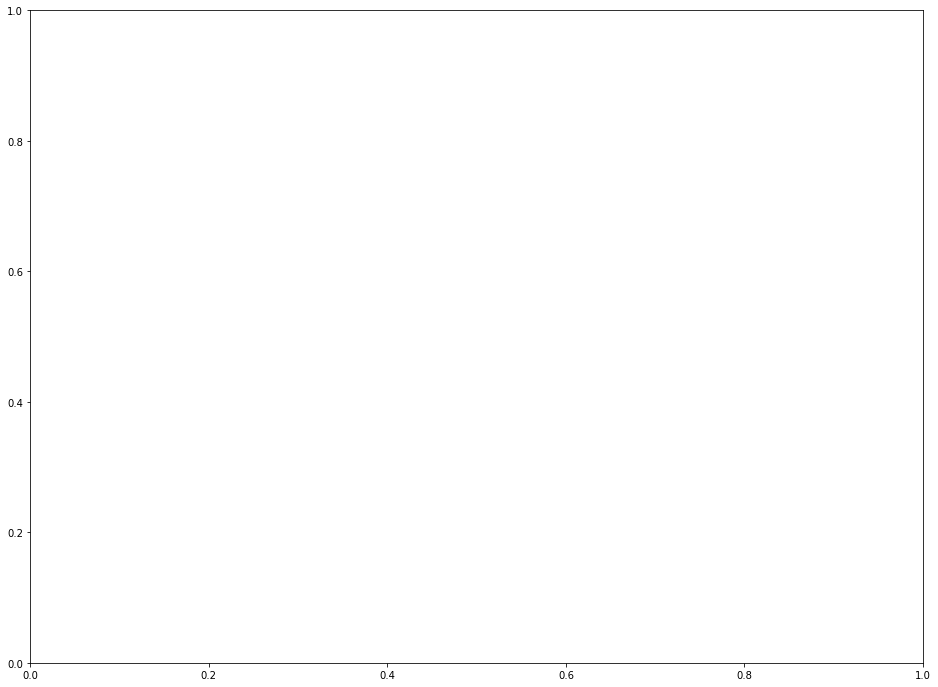

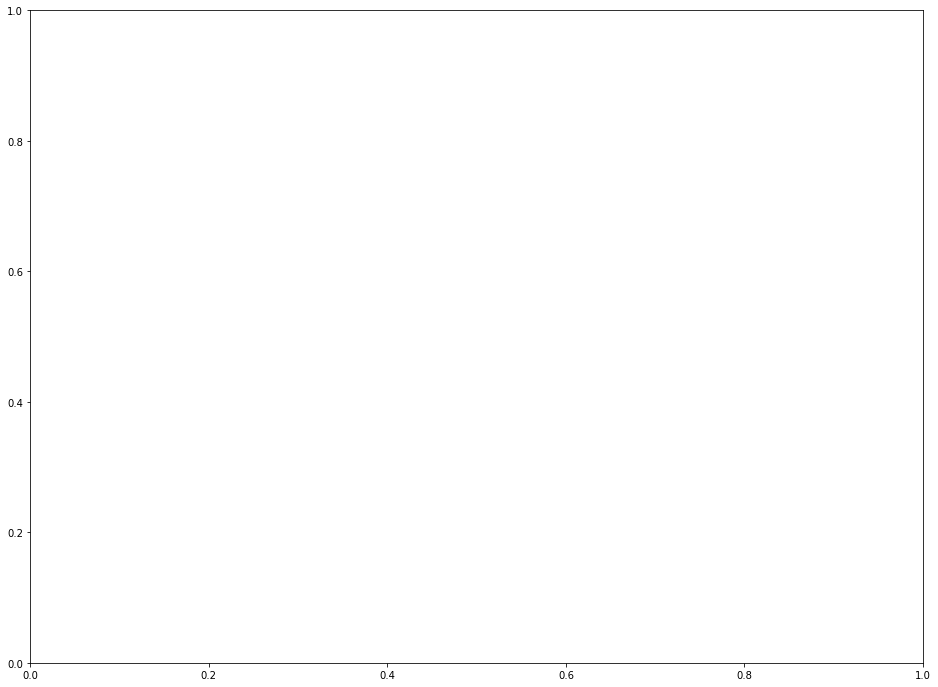

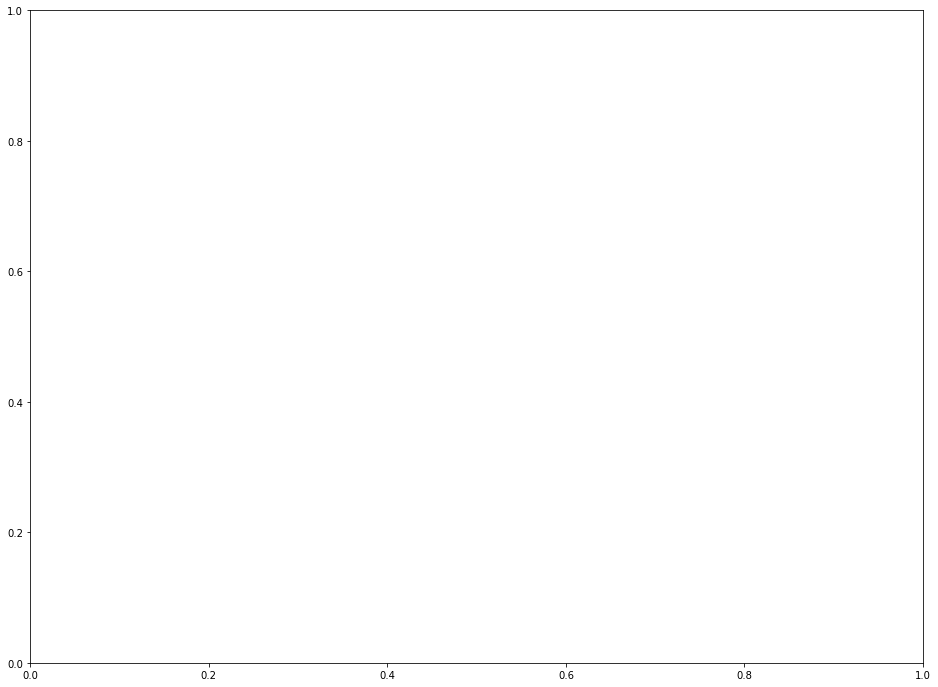

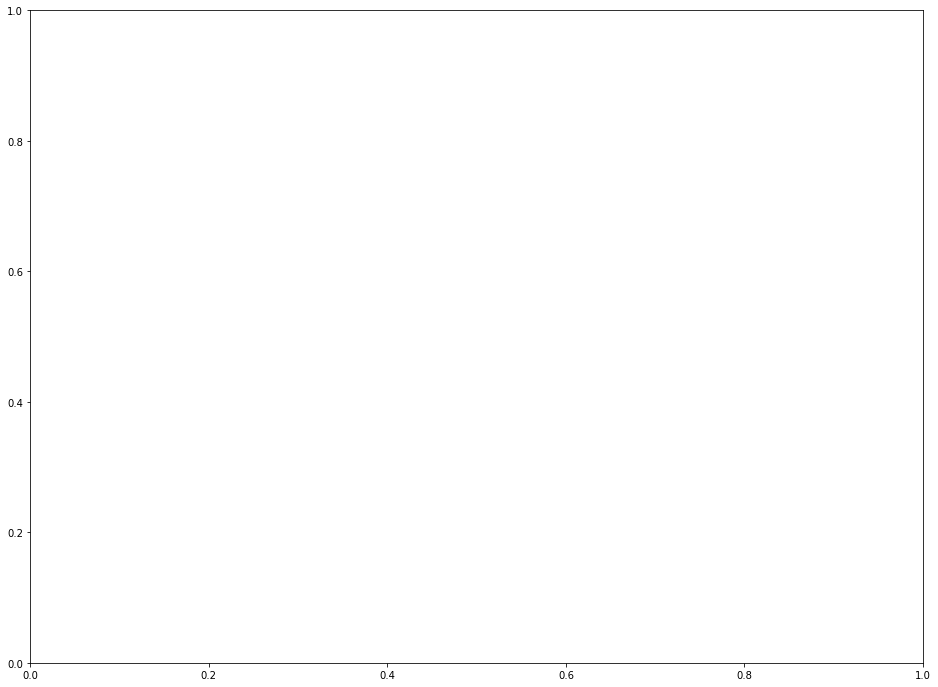

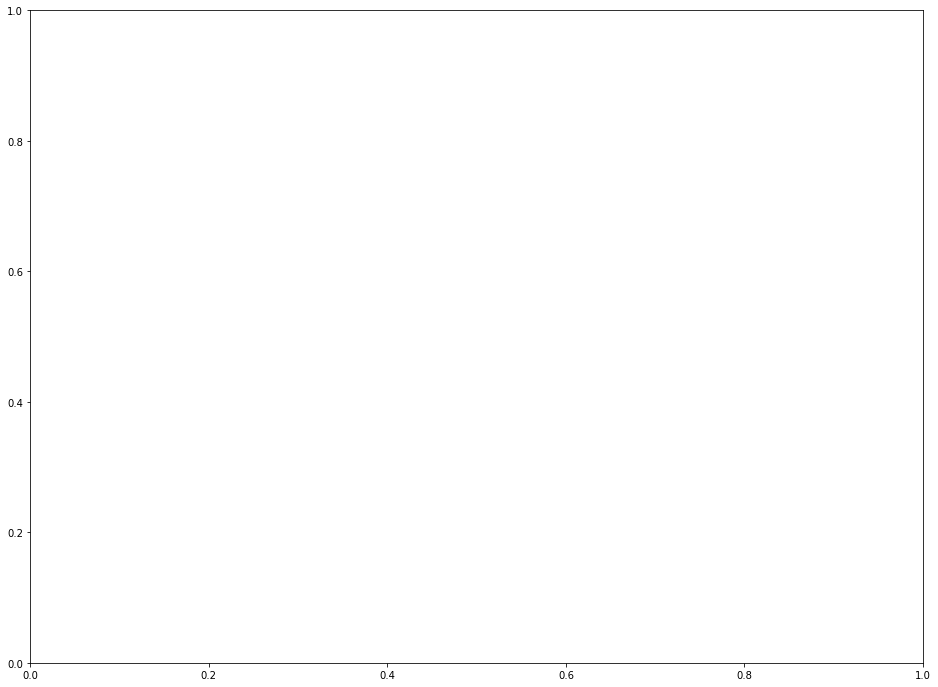

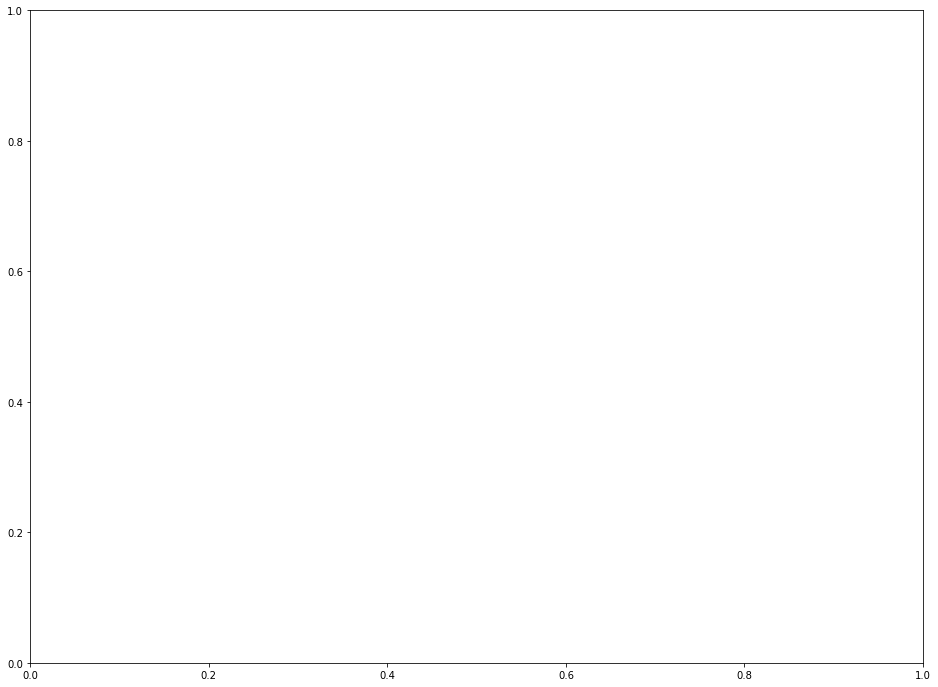

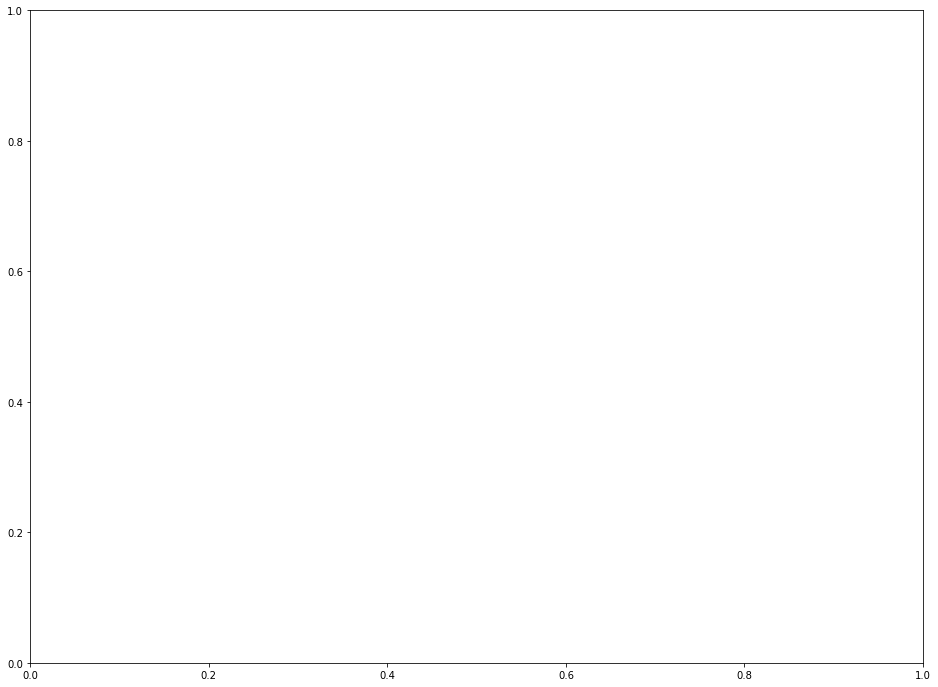

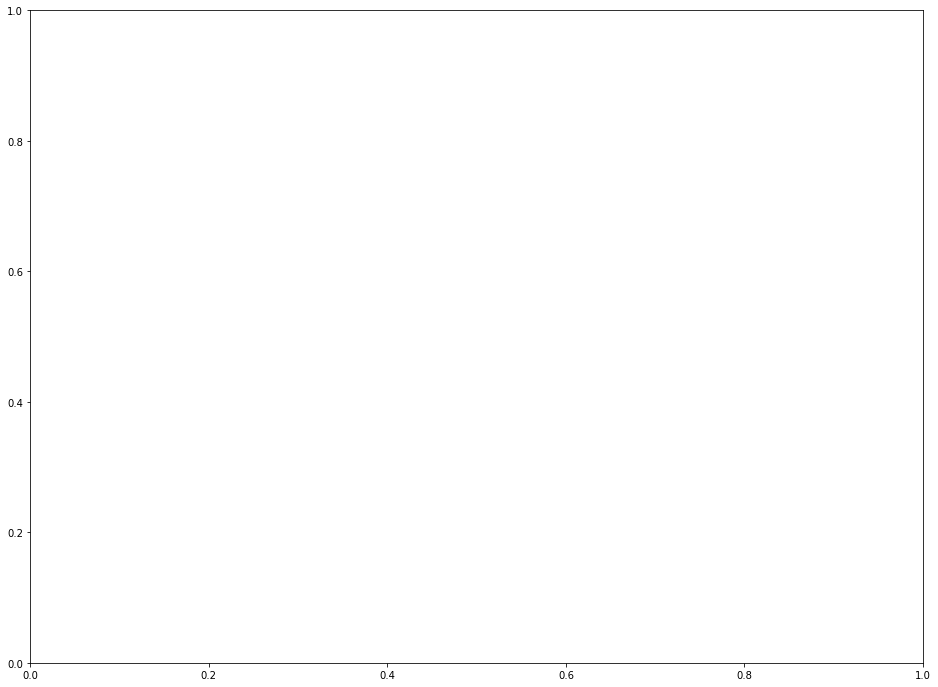

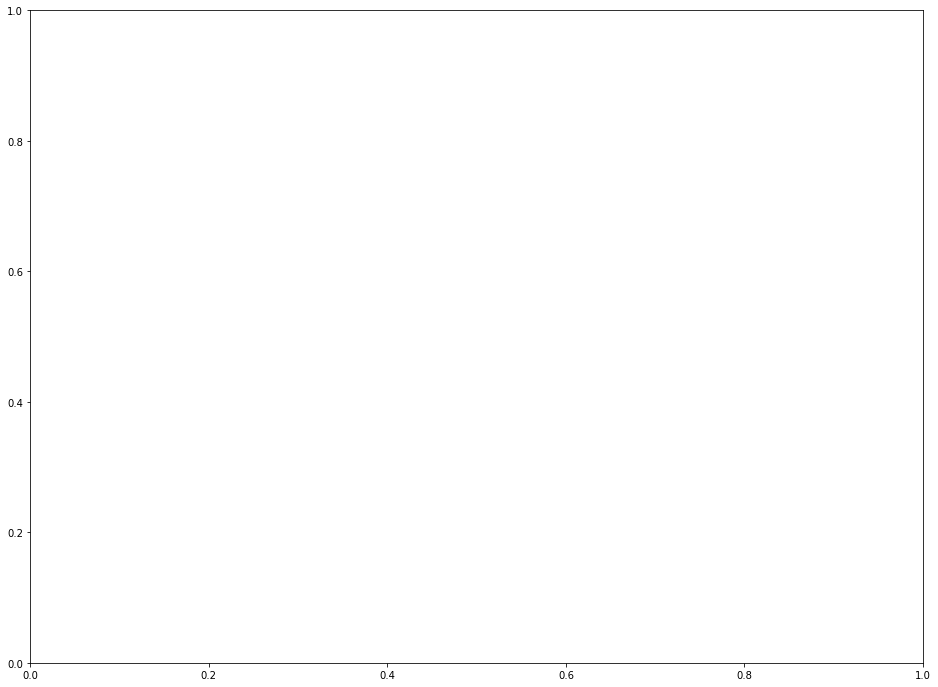

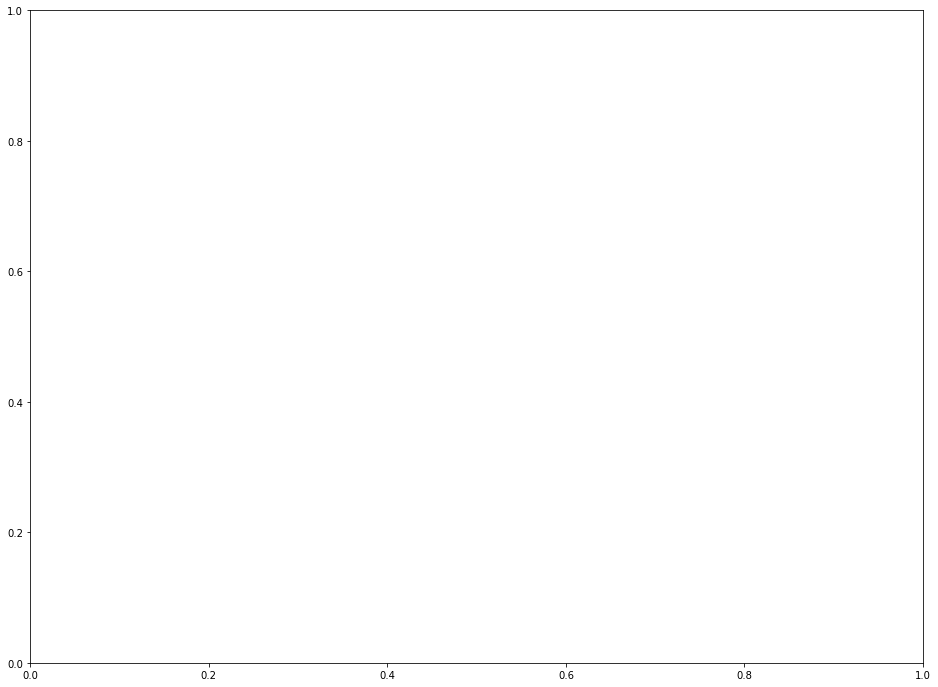

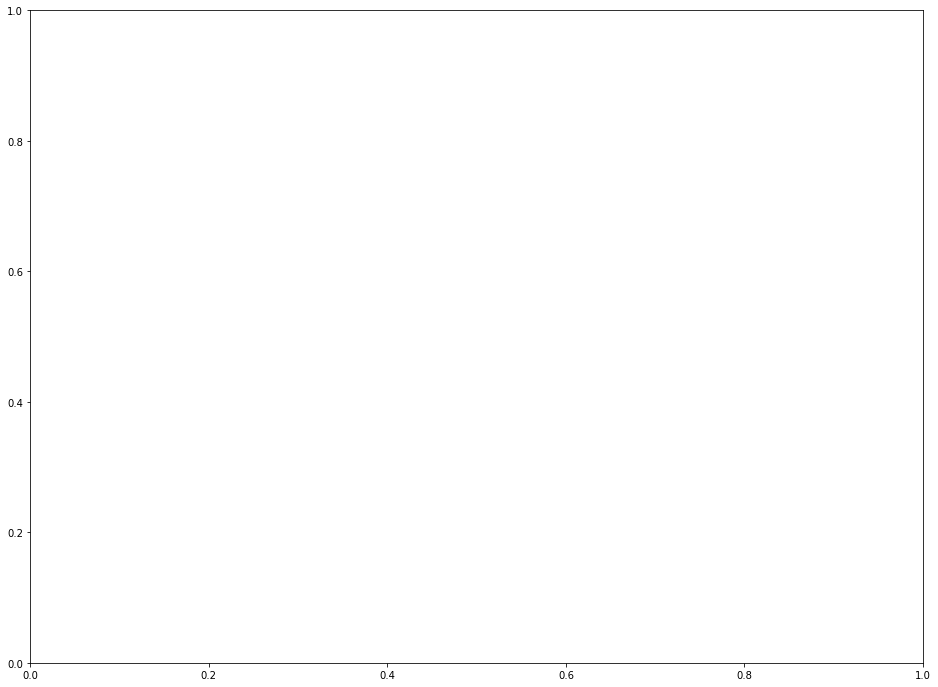

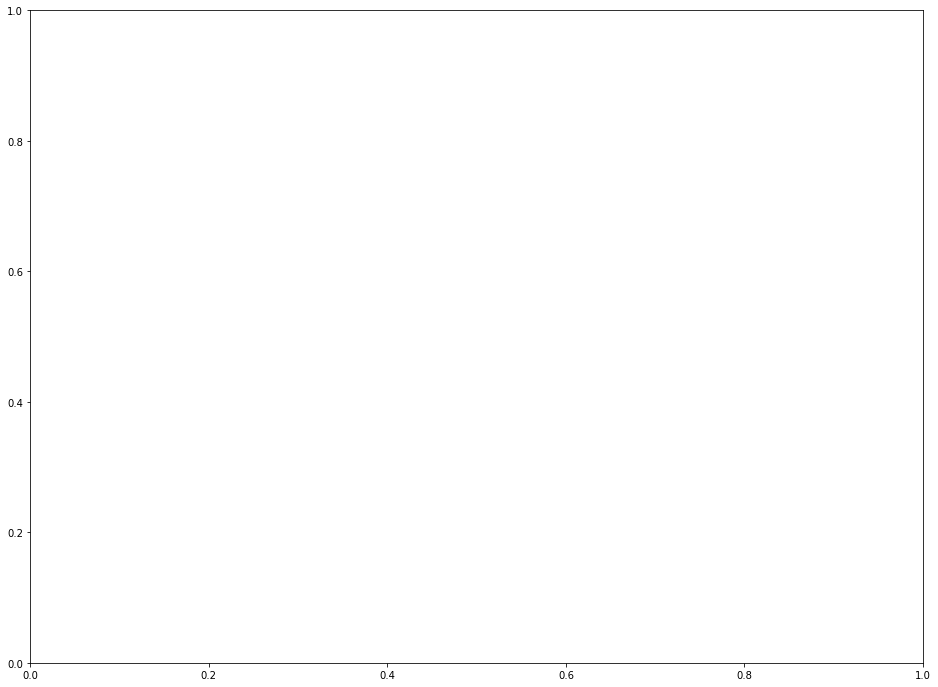

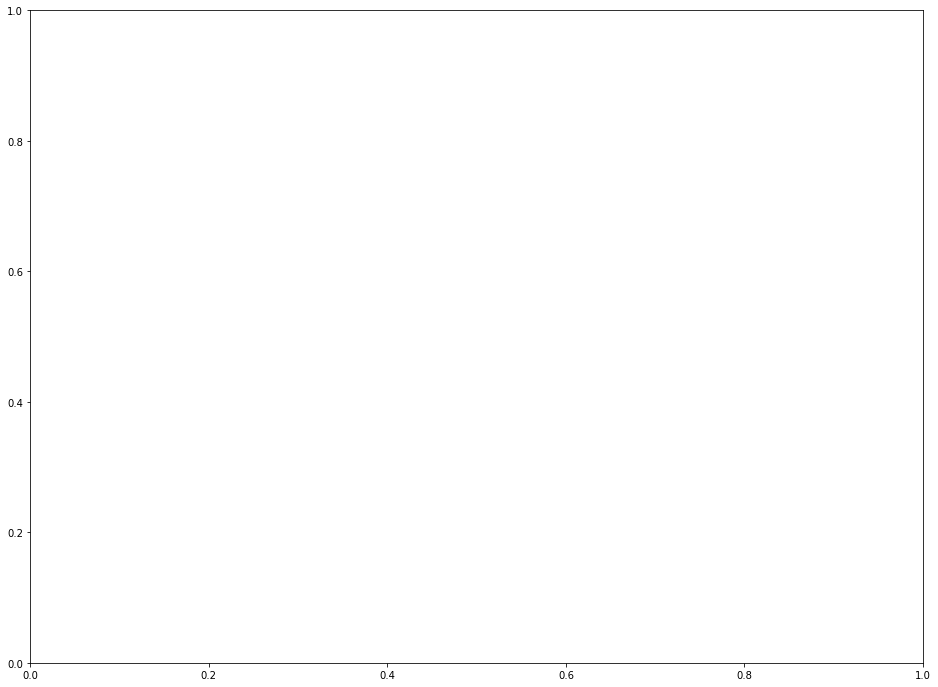

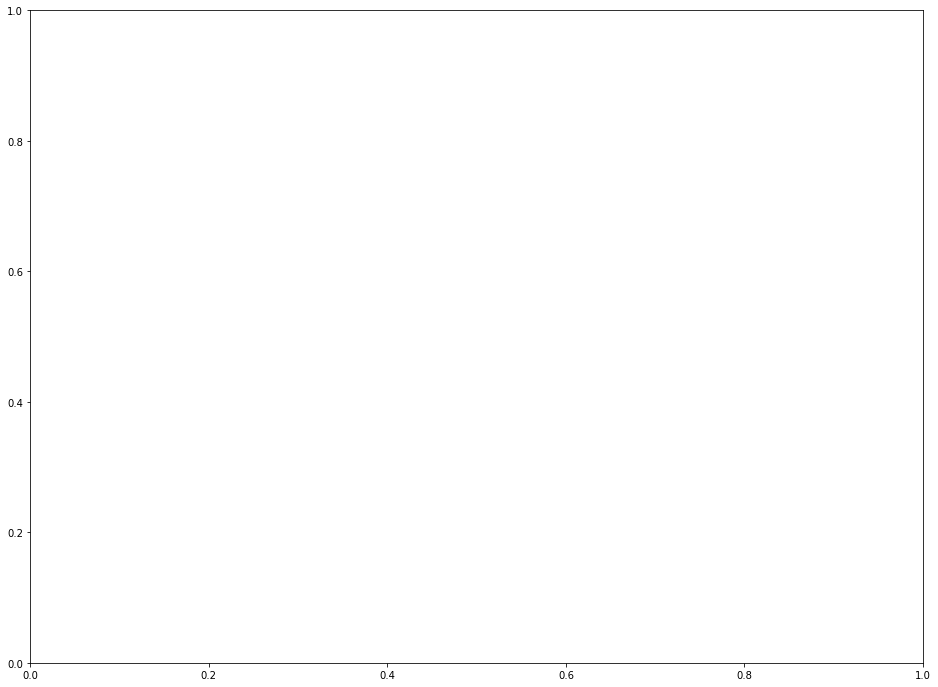

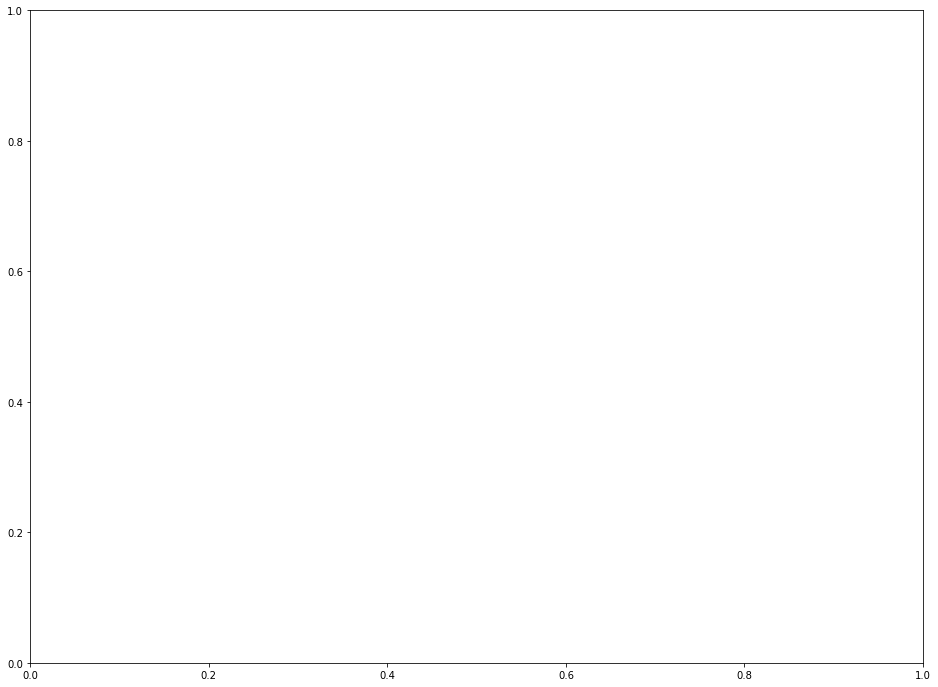

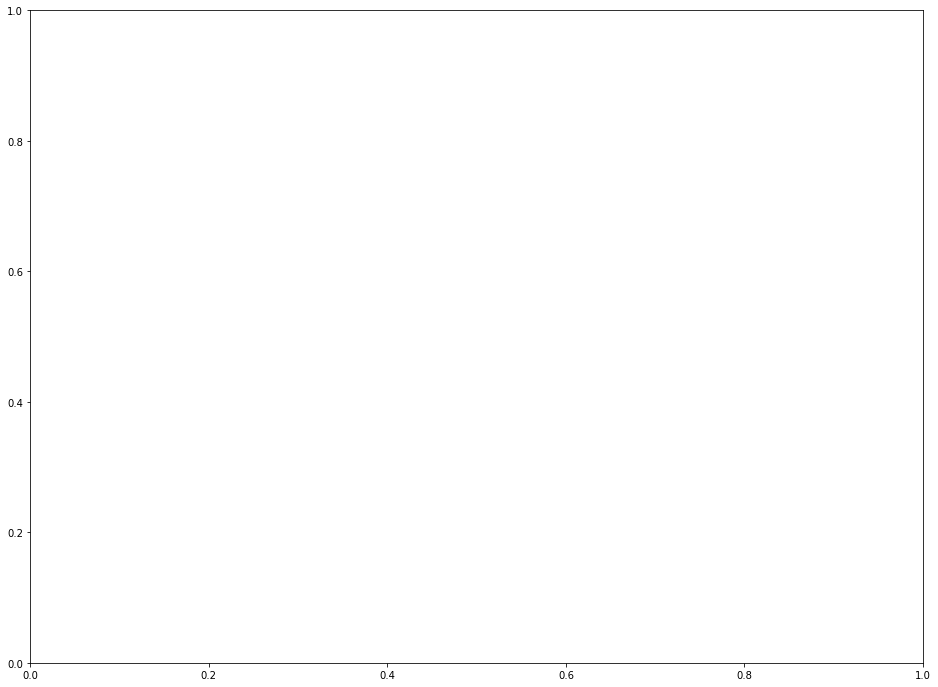

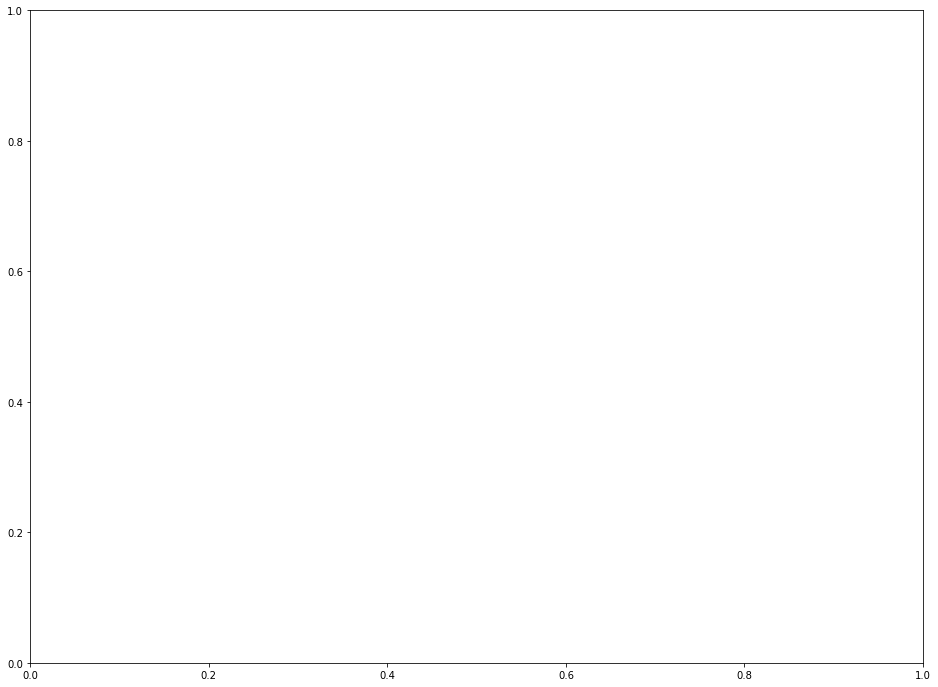

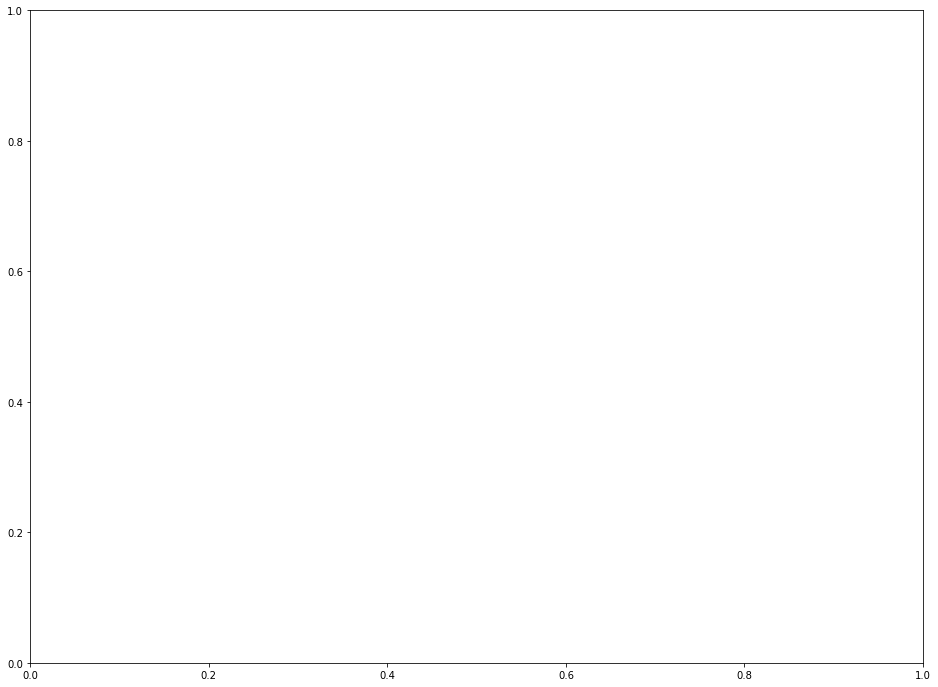

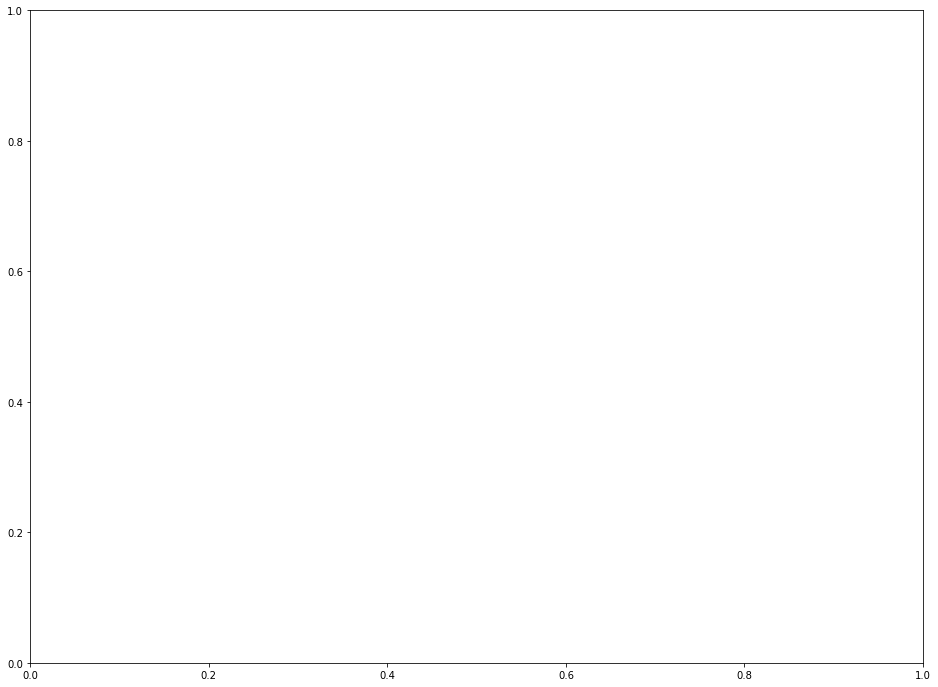

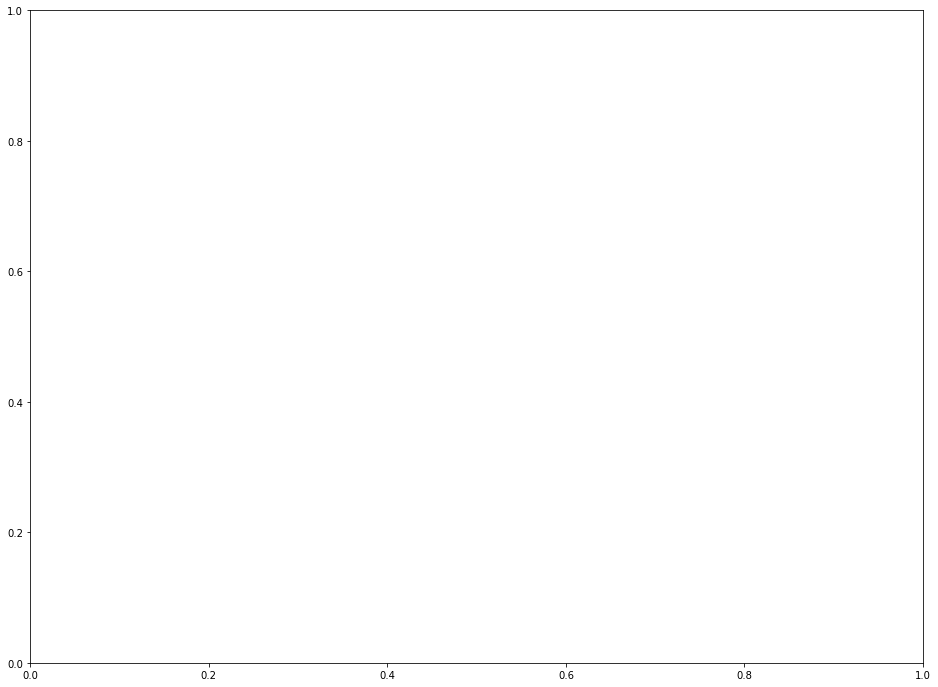

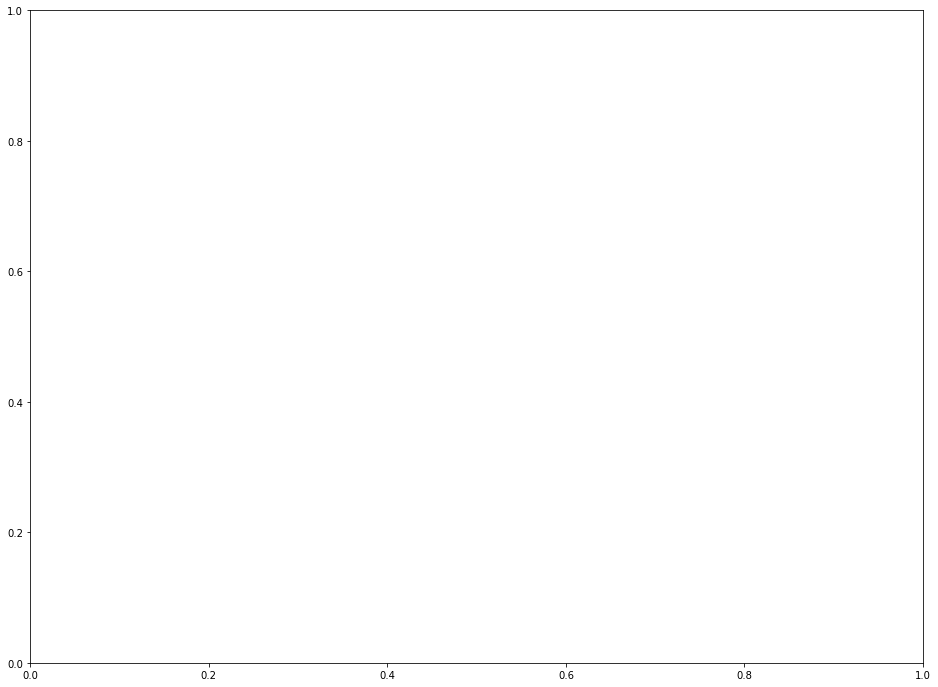

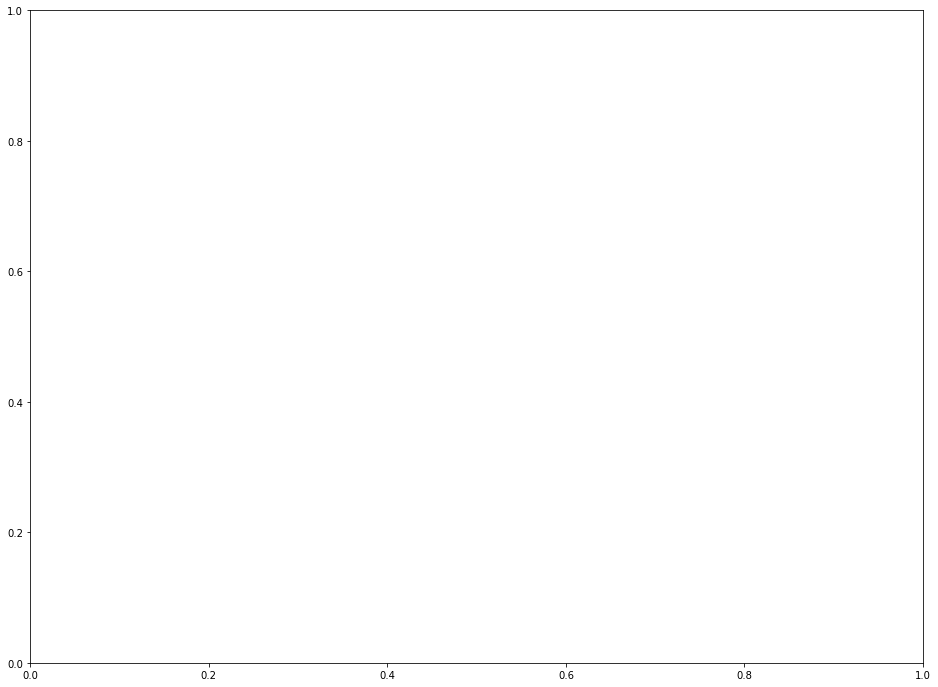

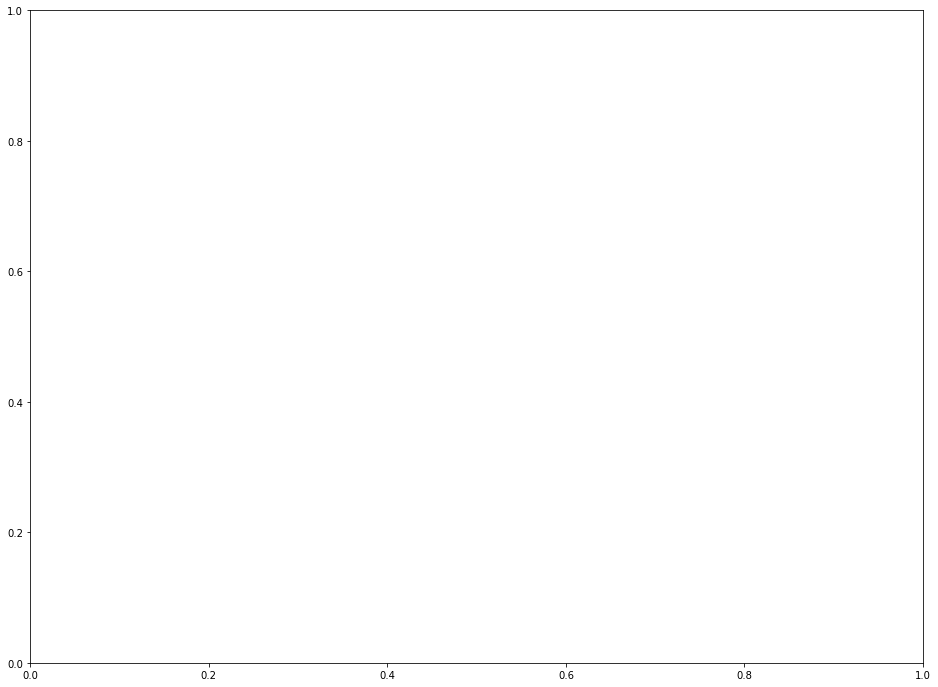

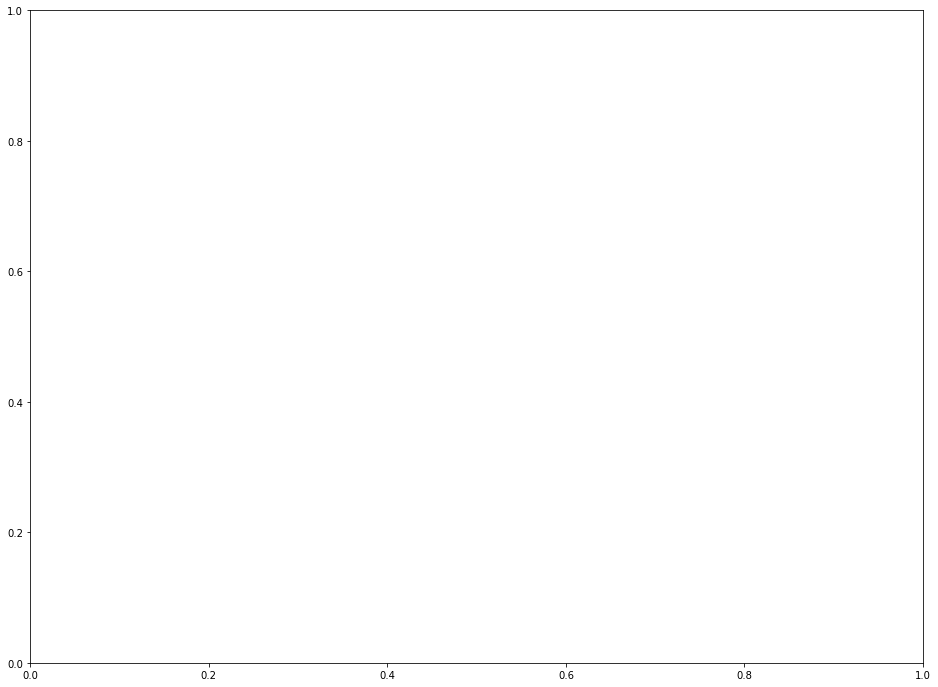

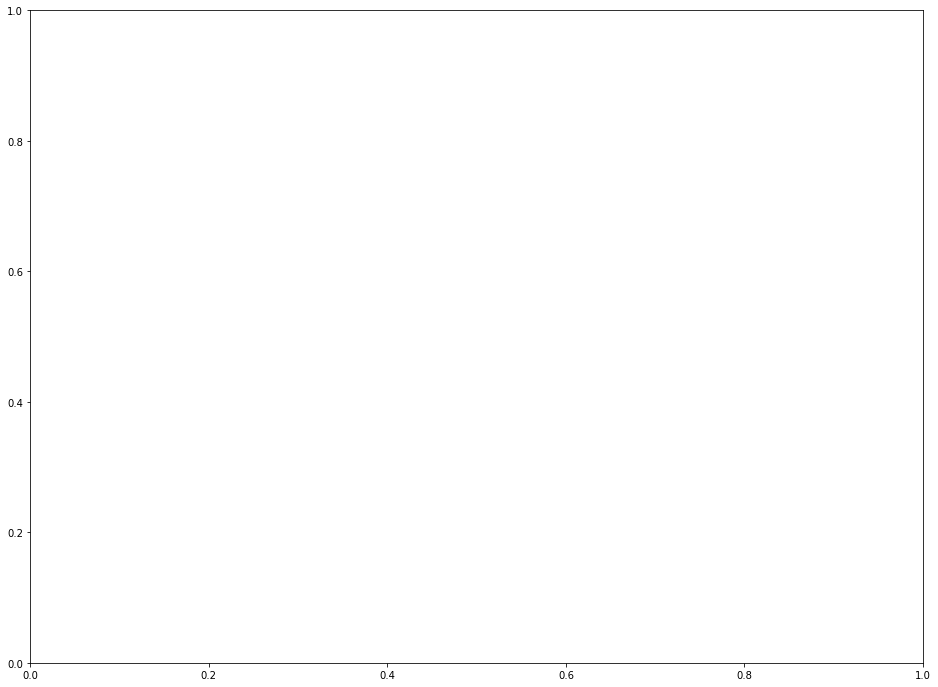

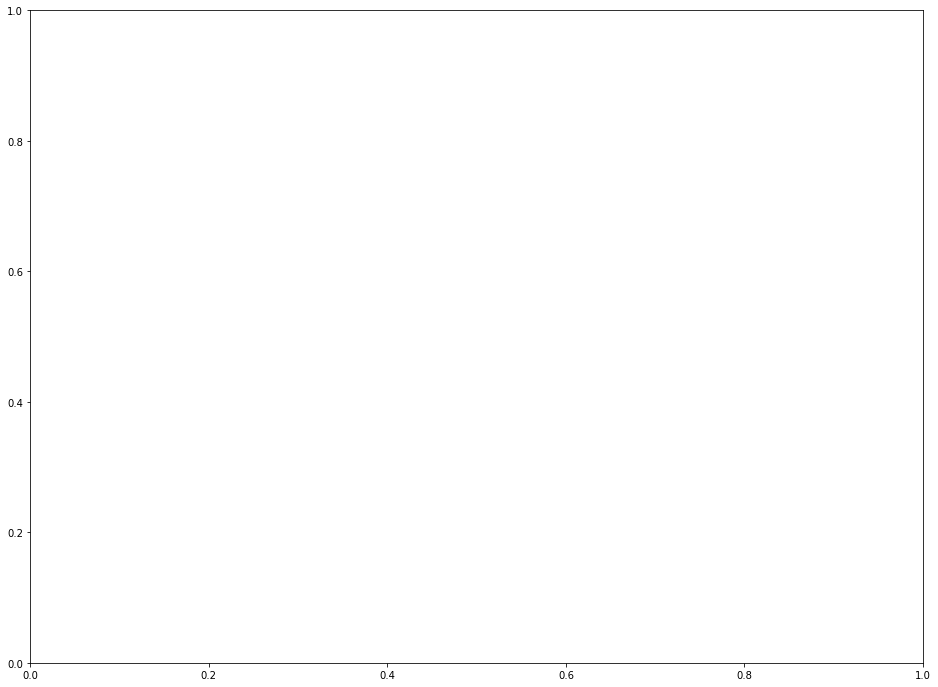

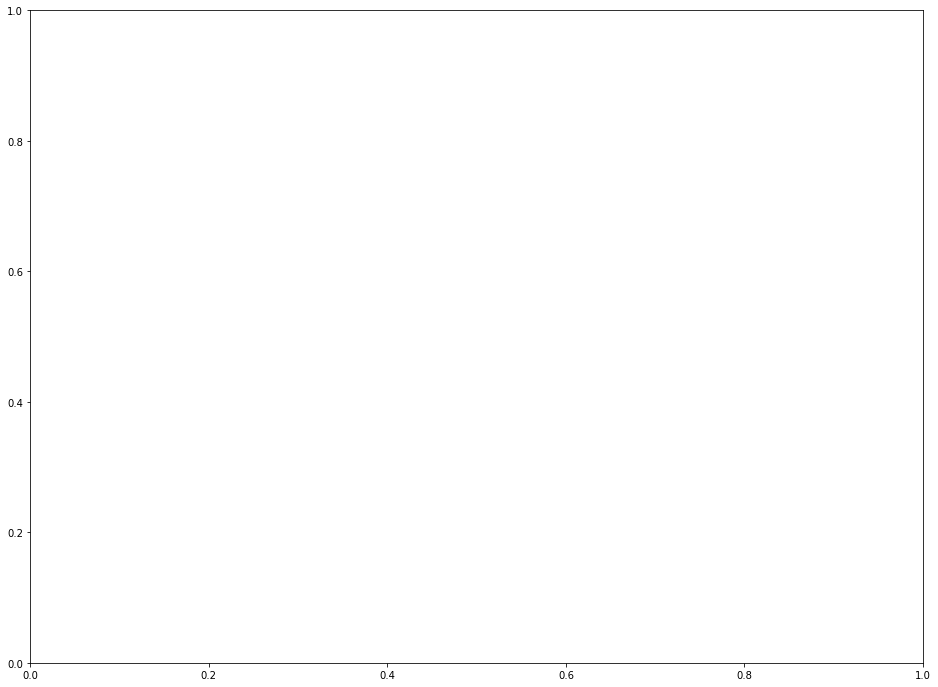

In [397]:
plotTsneAndSaveToFiles(df_marketing_exaggeration, 'exaggeration' + str(early_exag) + '_')

In [398]:
n_comp=2 
perplex=30.0 
early_exag=12.0 
l_rate=1000.0 
rstate=42 
n_i= 1000 
n_i_progress=300

df_marketing_lrate = tuneHyperparametersTsne(df=df_with_pm, scaled_df=scaled_df, n_components=n_comp, perplexity=perplex, early_exaggeration=early_exag, learning_rate=l_rate, 
random_state=rstate, n_iter= n_i, n_iter_without_progress=n_i_progress)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 726 entries, 201110 to 310113
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Gender                        726 non-null    float64
 1   IC                            726 non-null    int64  
 2   Zip-code                      726 non-null    int64  
 3   Geboortedatum                 726 non-null    int64  
 4   Leeftijd (op testdag)         726 non-null    float64
 5   AST (tijd afgerond op 0.1s)   726 non-null    float64
 6   MQ                            726 non-null    float64
 7   MQ catogory                   726 non-null    float64
 8   Lengte (afgerond op 0.1 cm)   726 non-null    float64
 9   Gewicht (afgerond op 0.1 kg)  726 non-null    float64
 10  Lengte (in m)                 726 non-null    float64
 11  BMI                           726 non-null    float64
 12  Gymles                        726 non-null    float64
 1

/tmp/ipykernel_36906/3569143405.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(16, 12))


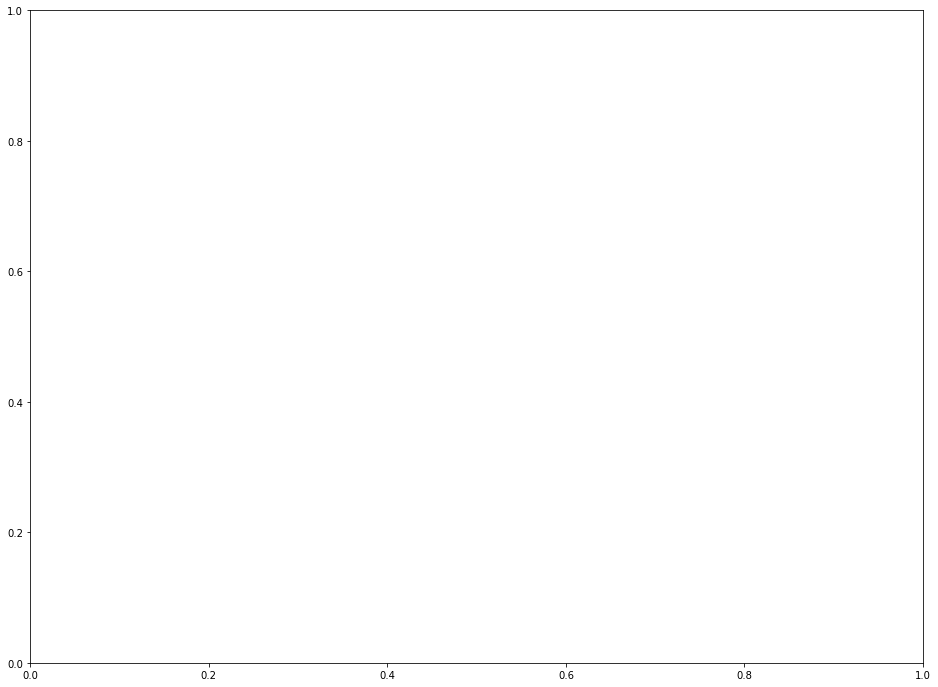

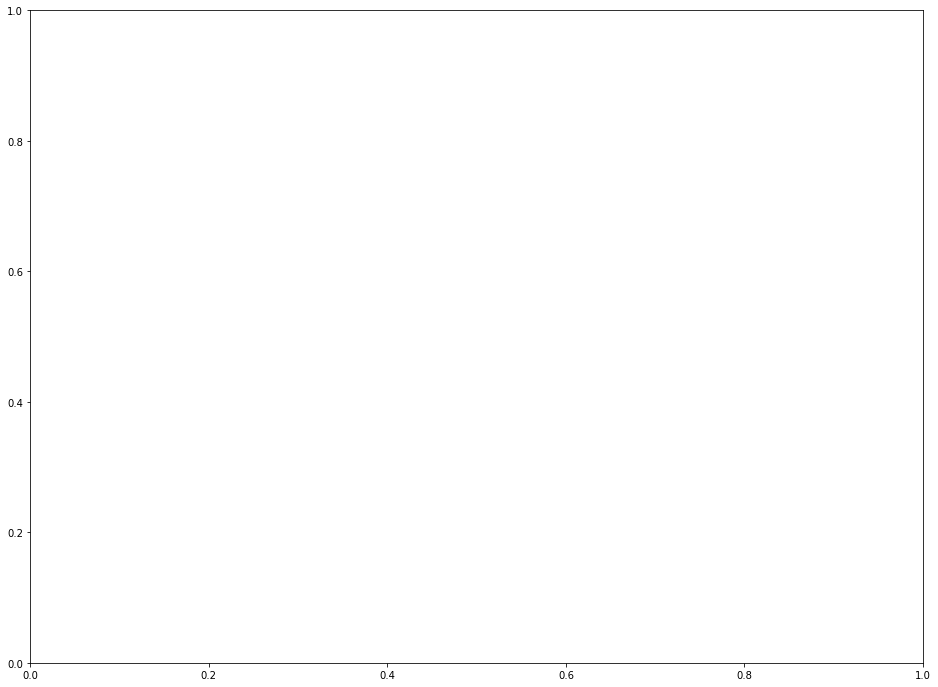

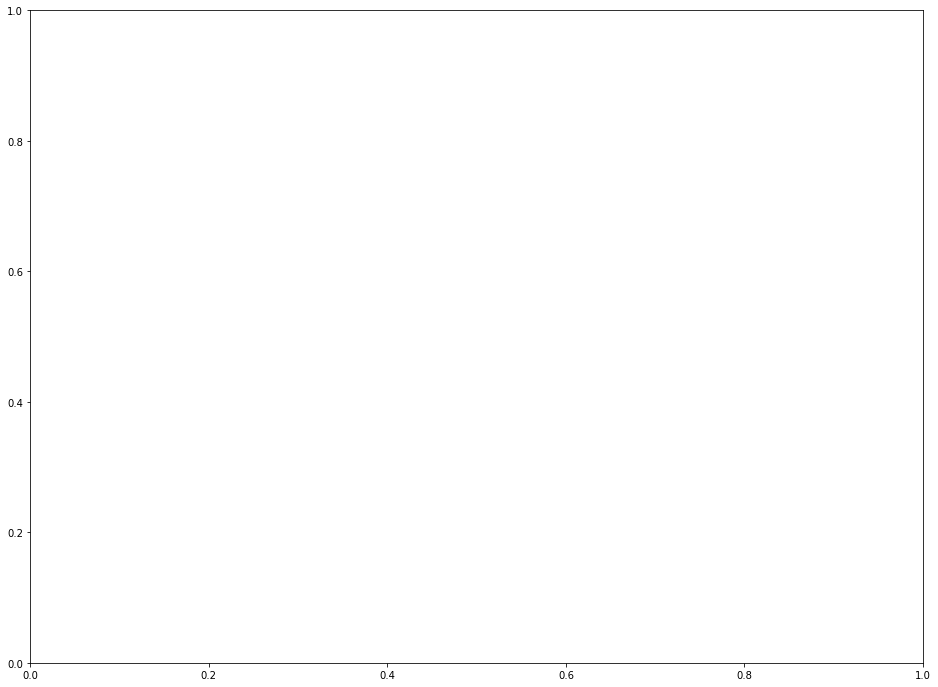

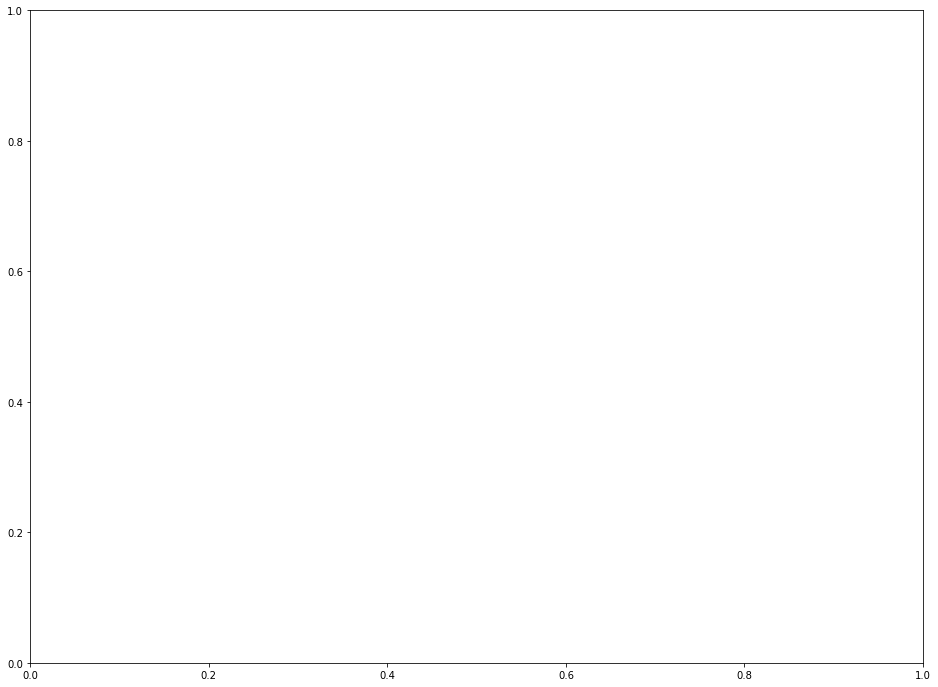

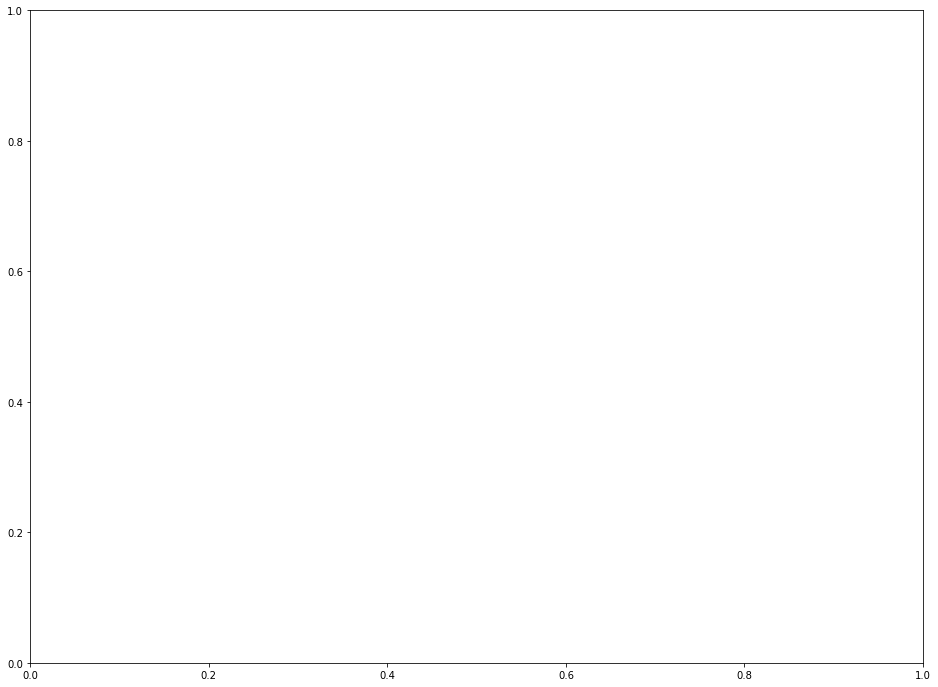

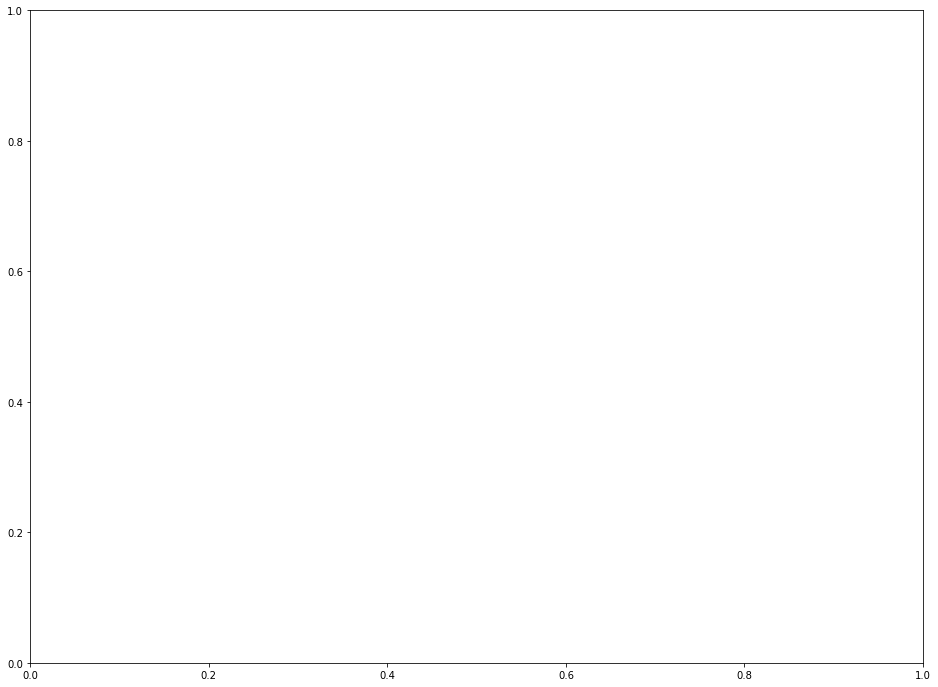

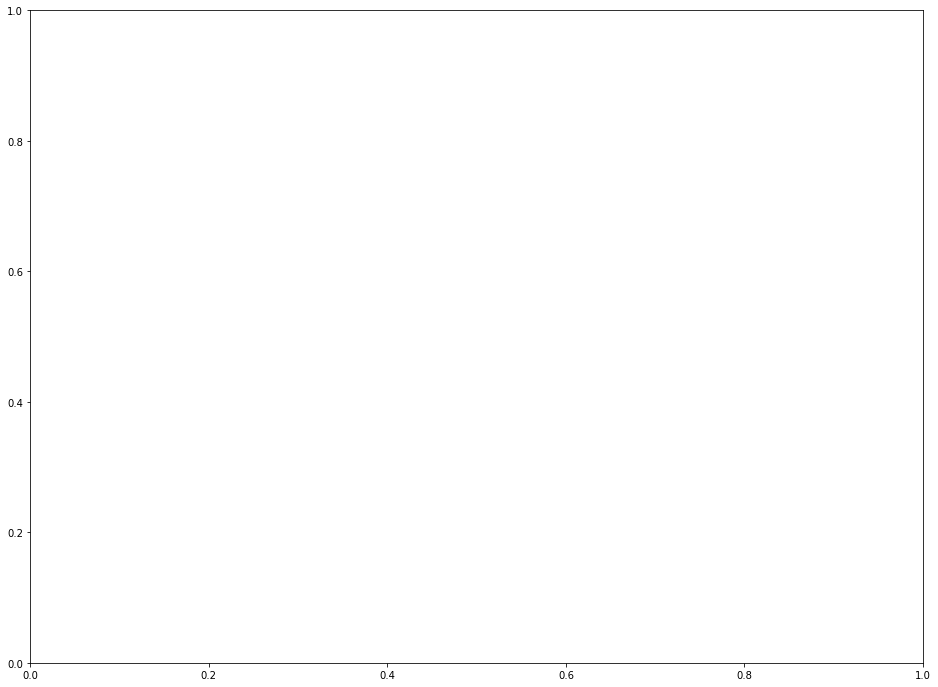

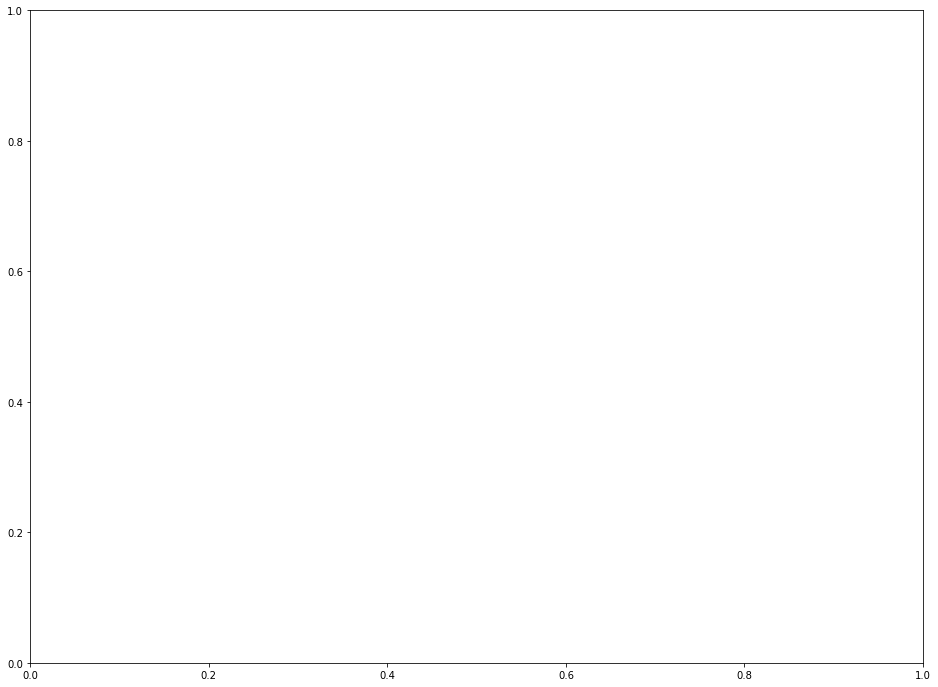

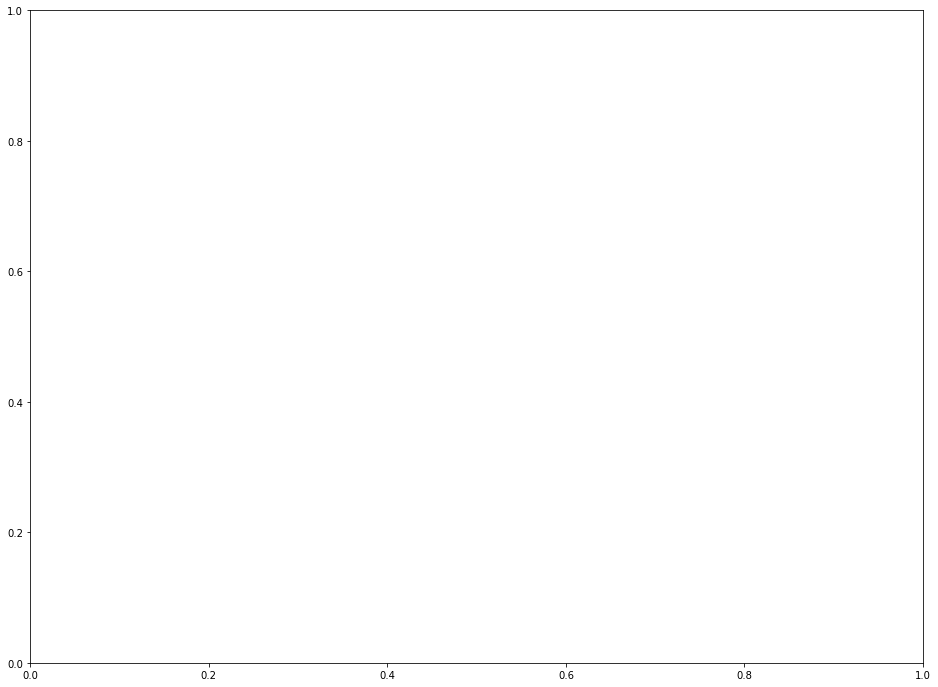

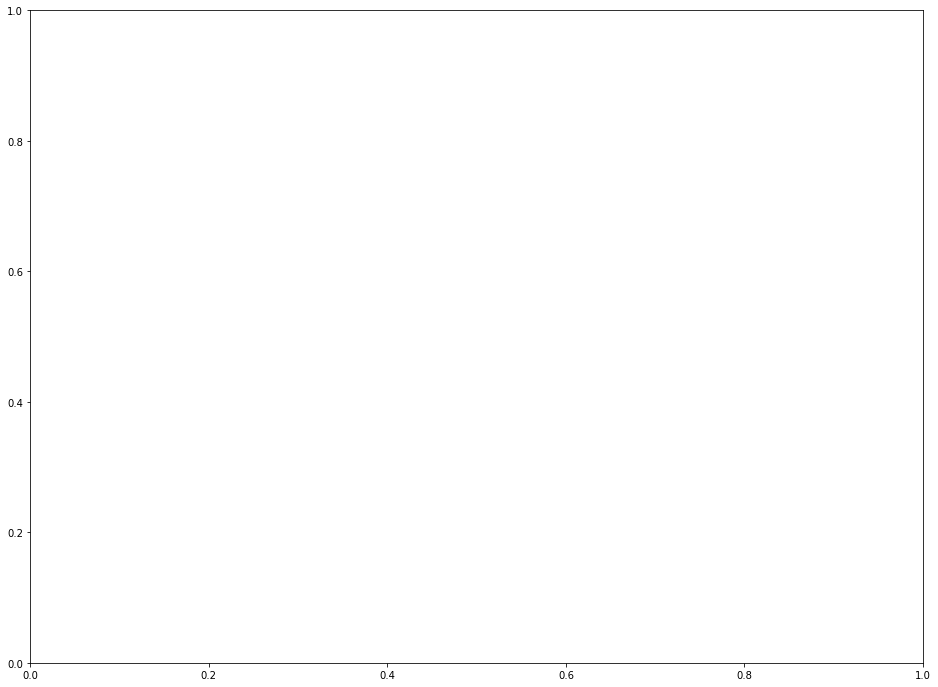

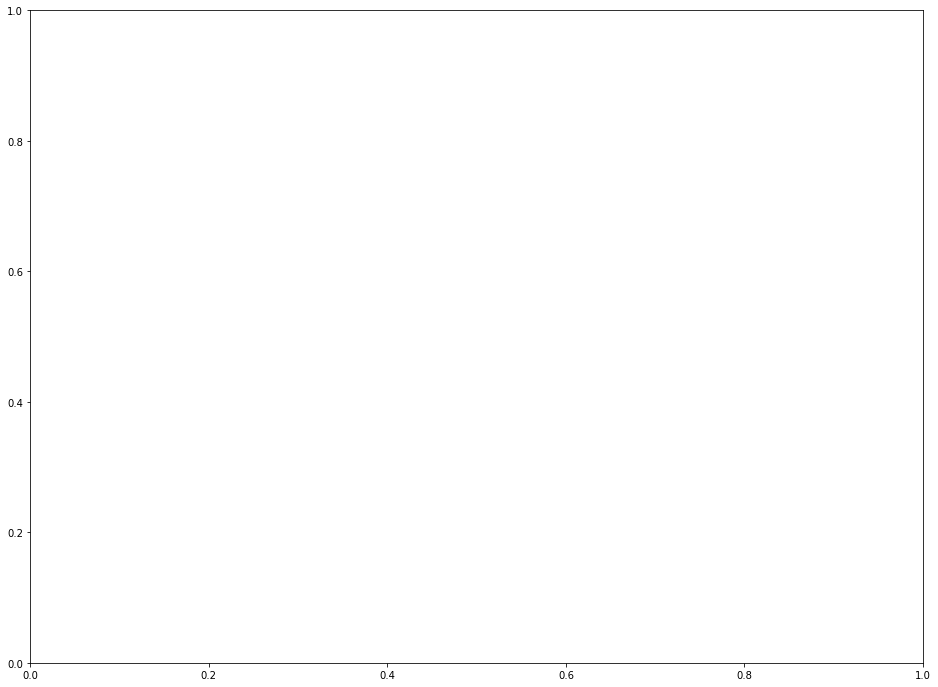

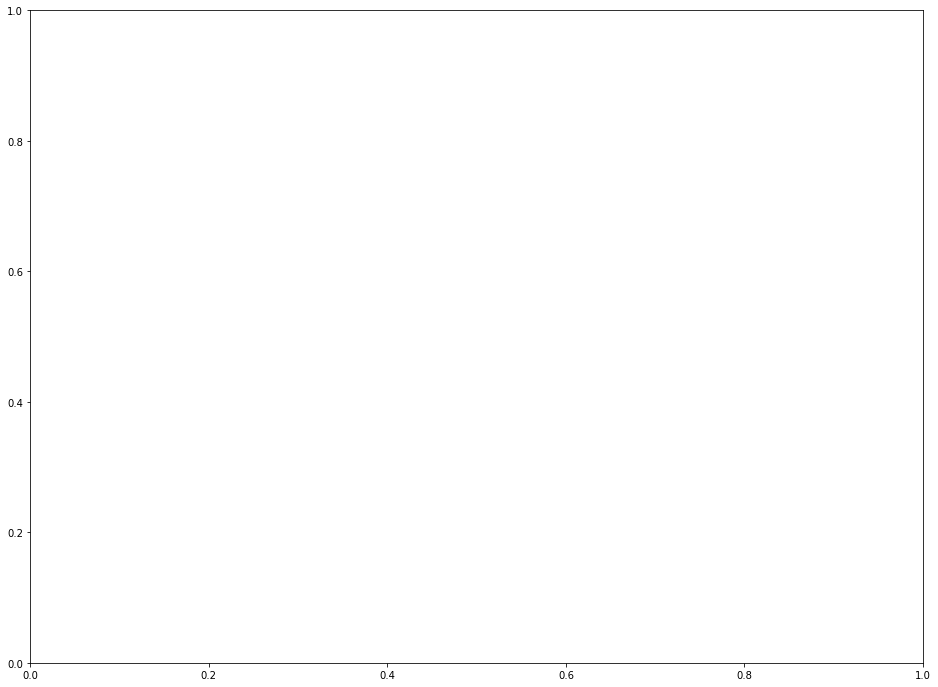

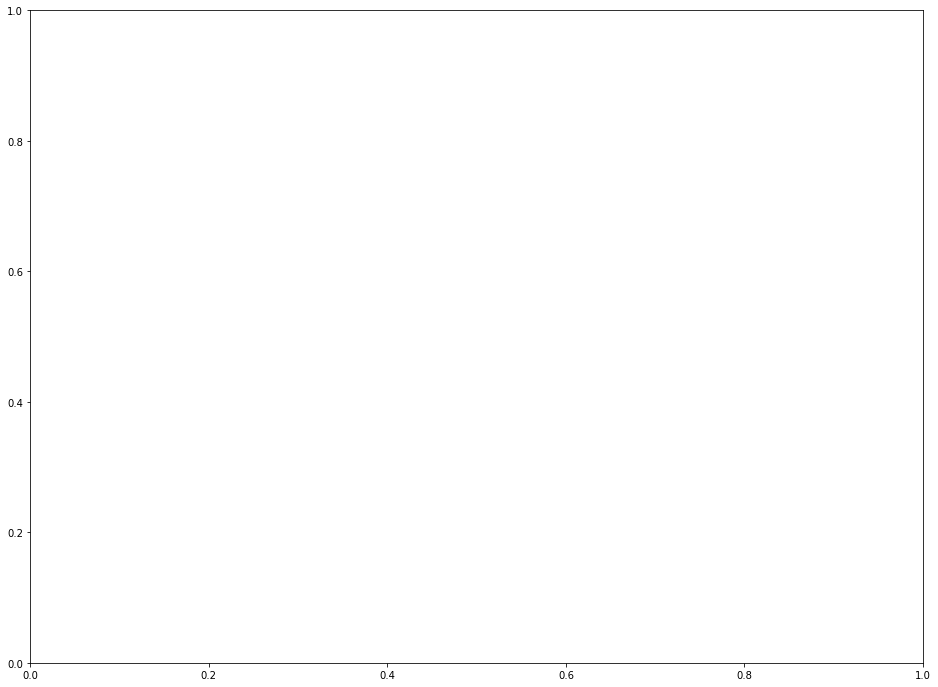

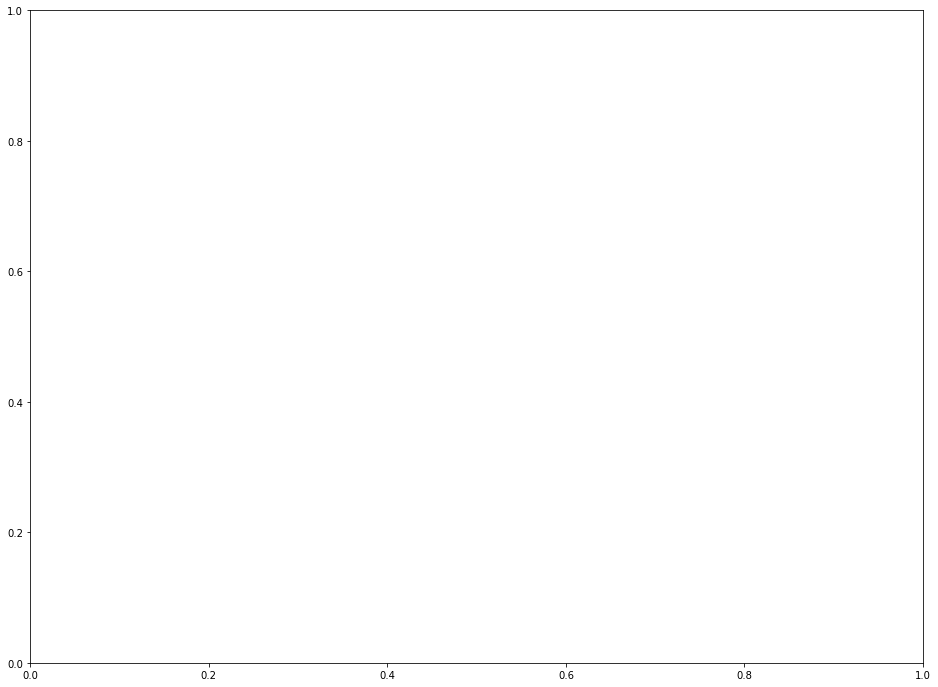

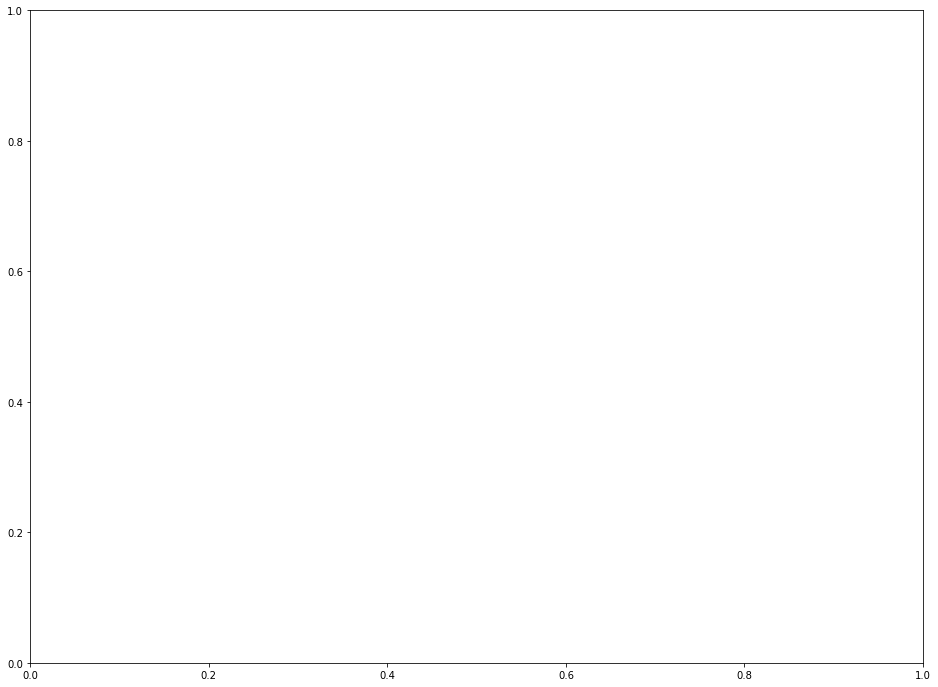

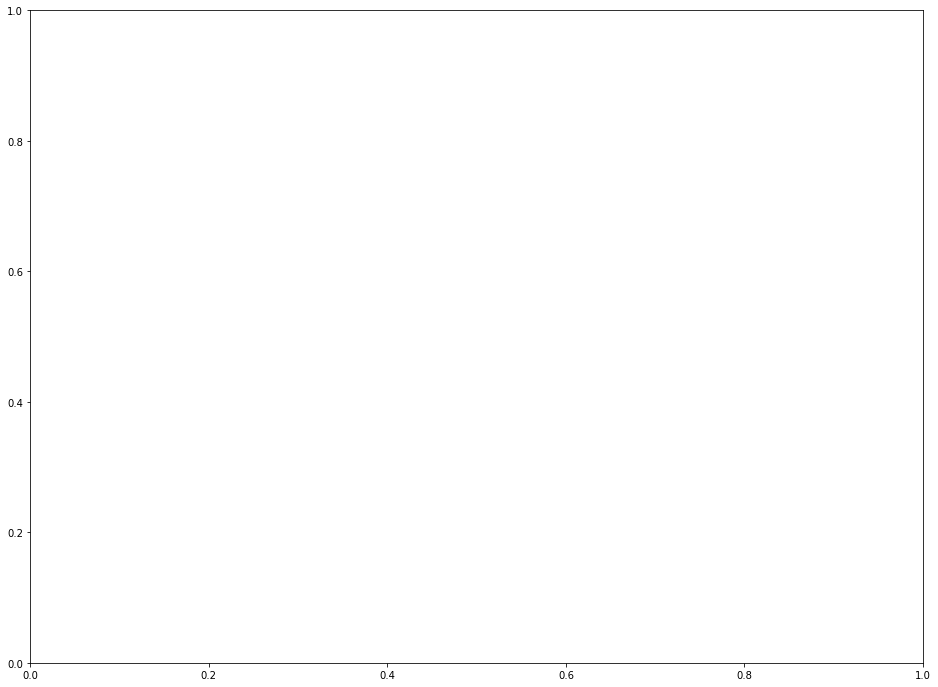

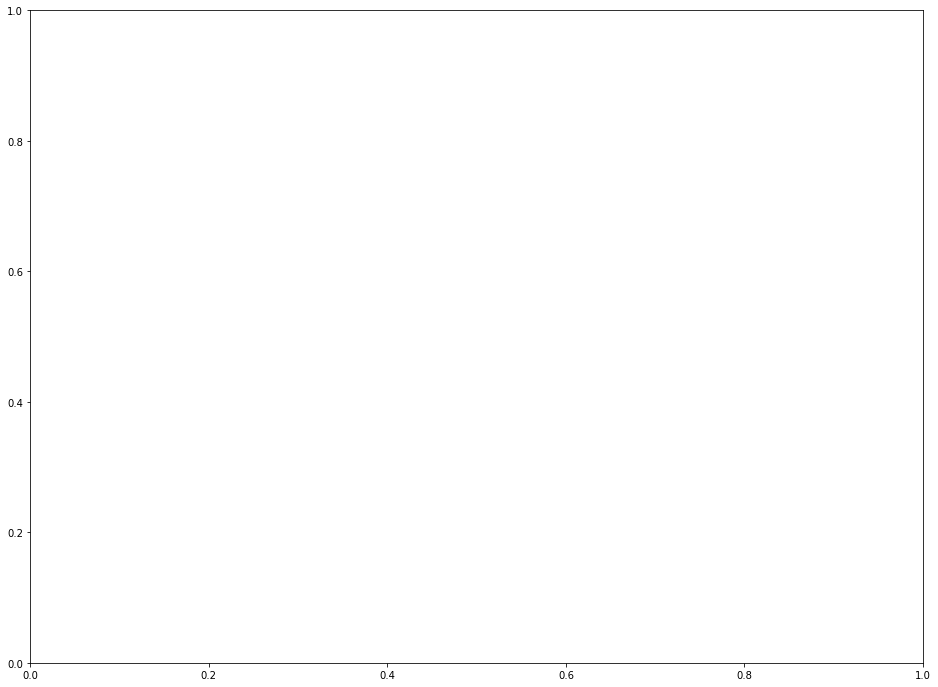

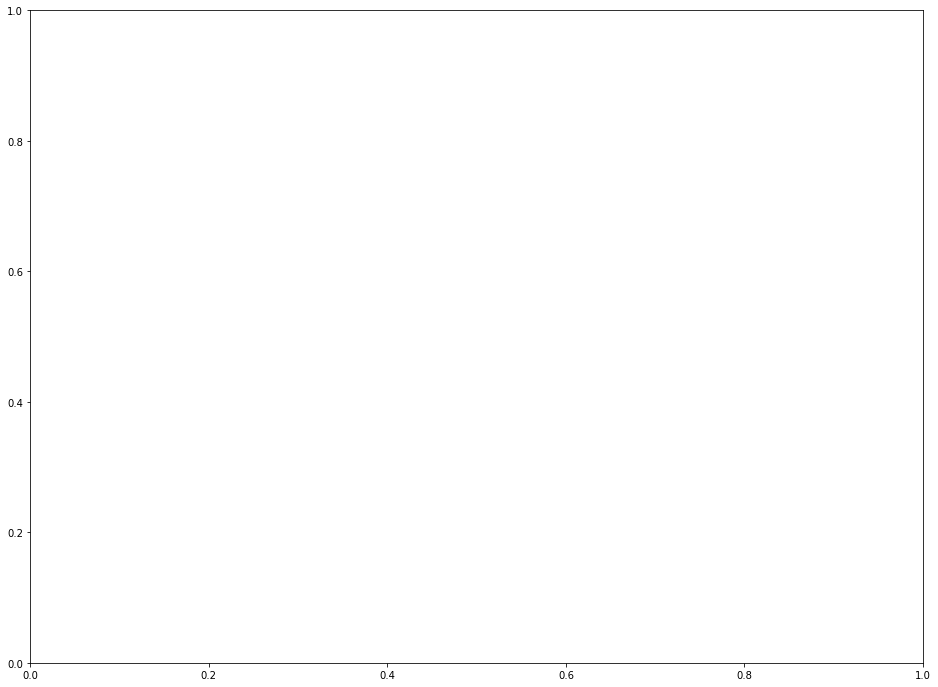

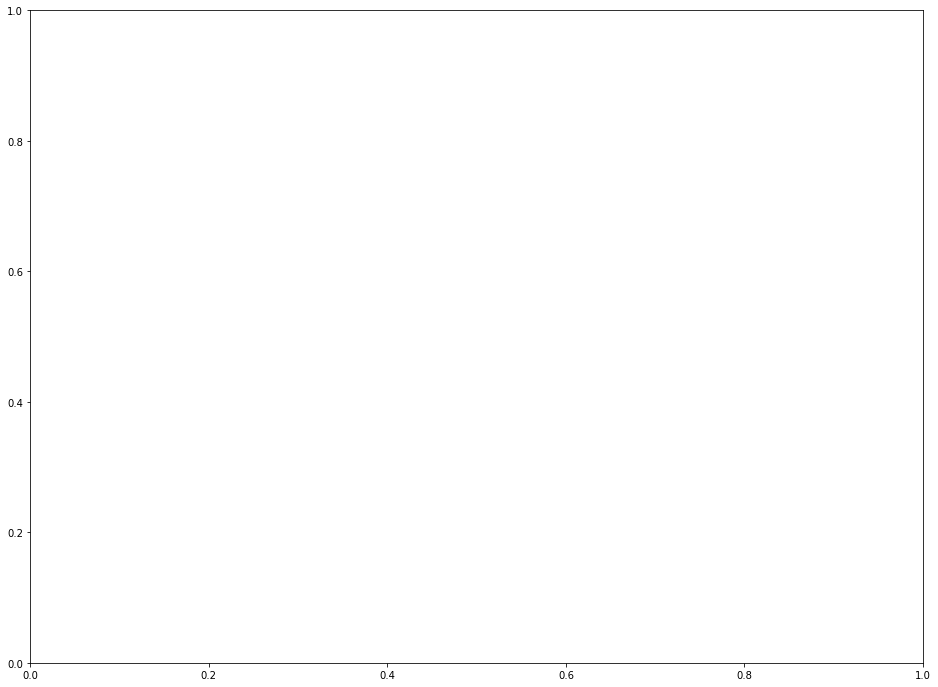

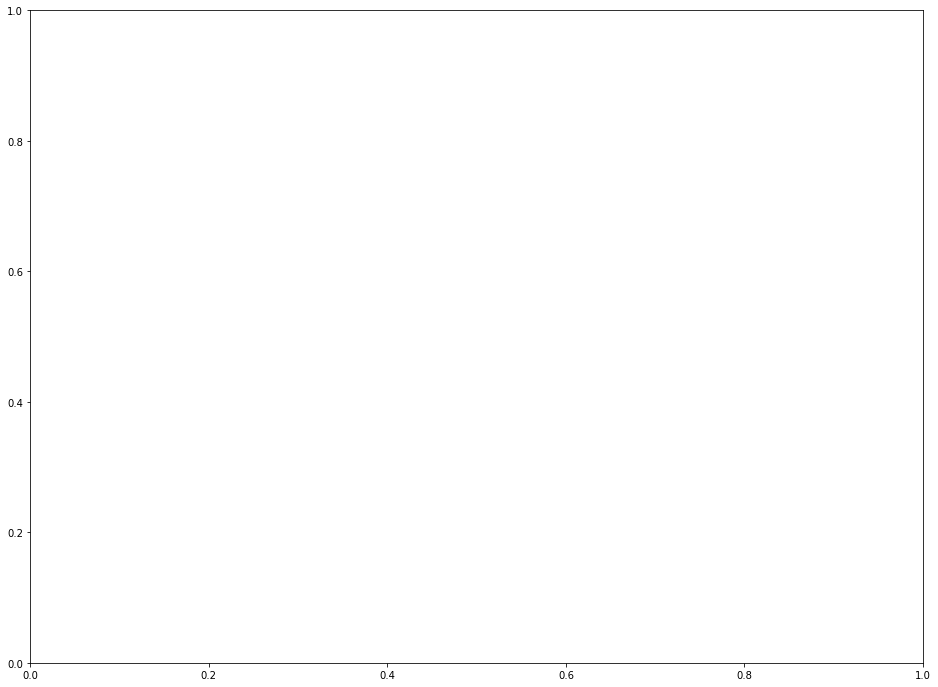

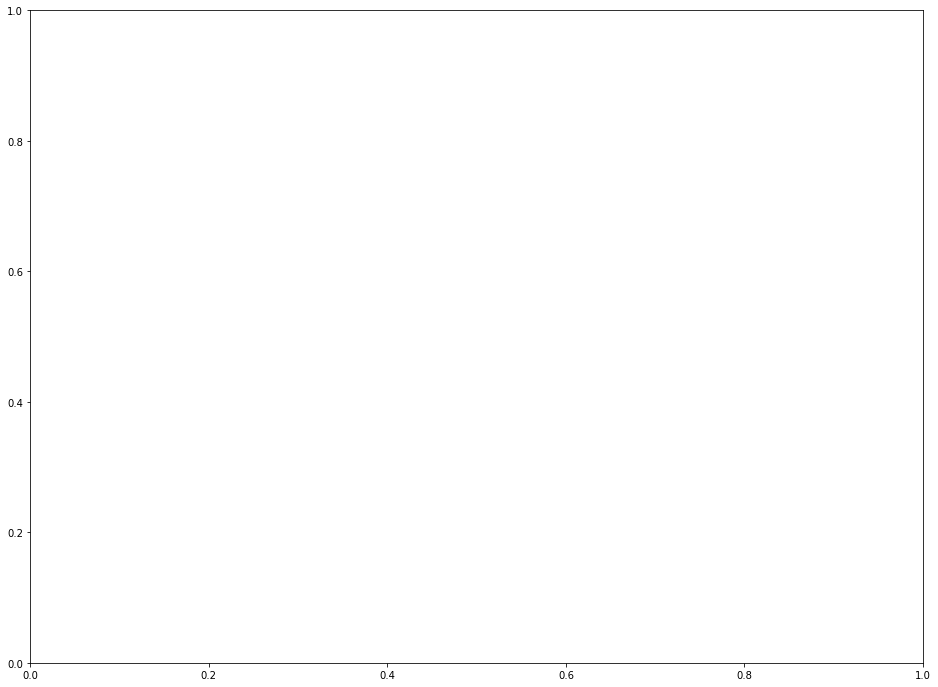

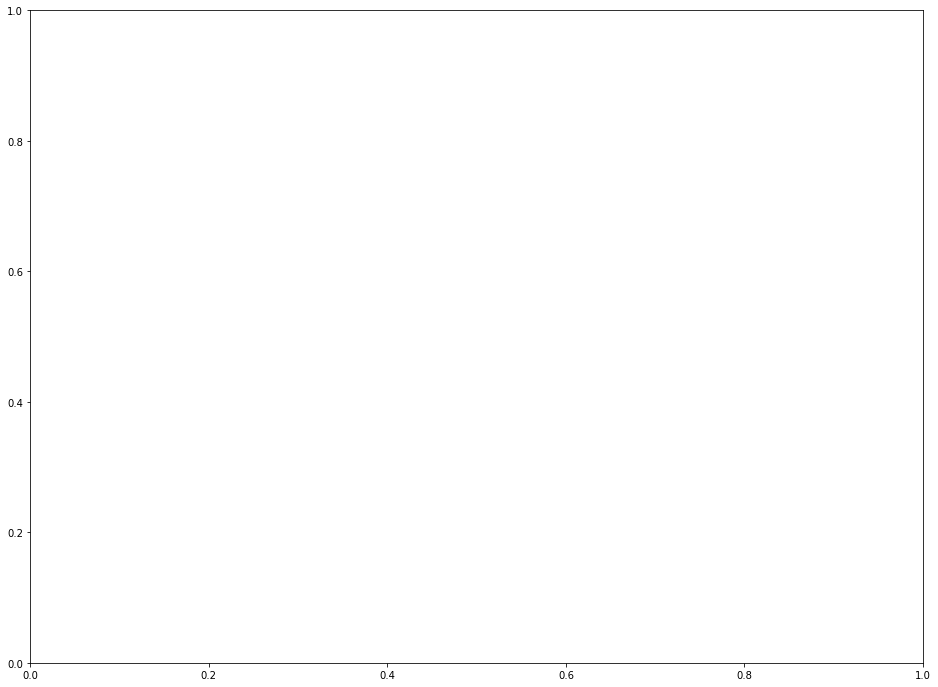

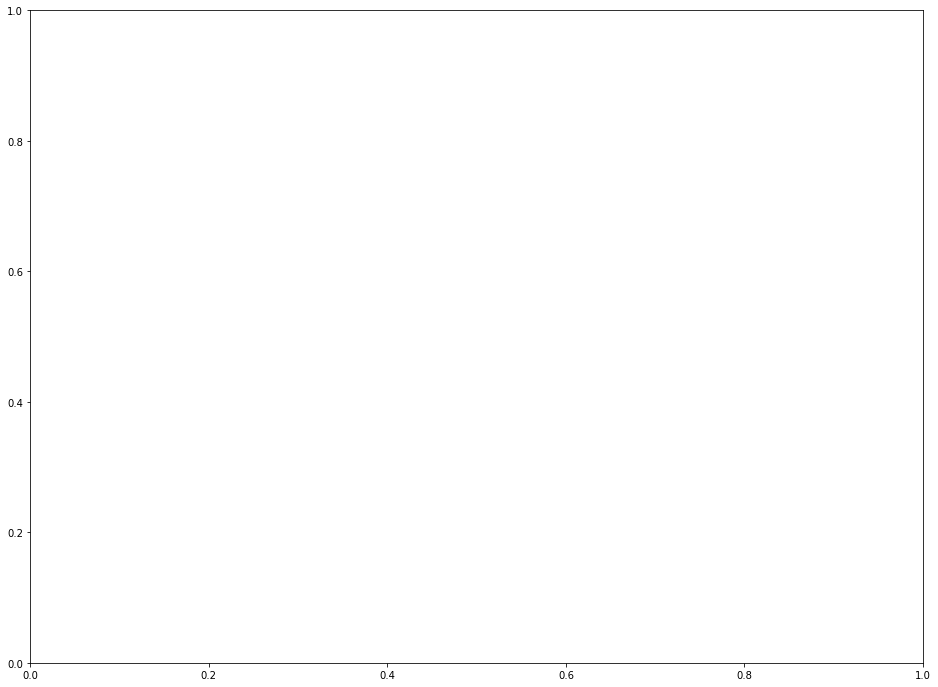

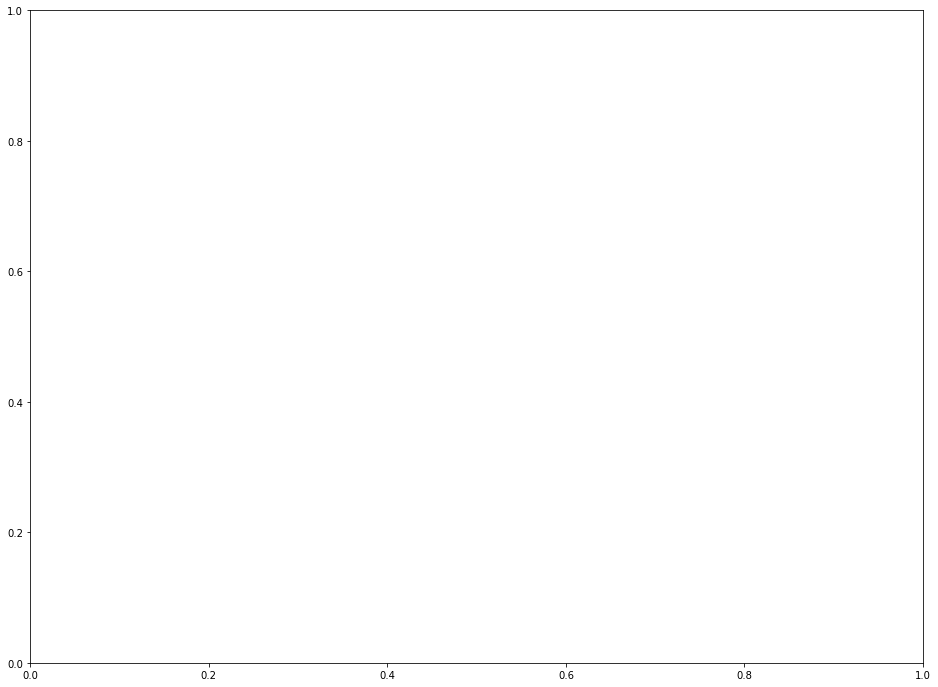

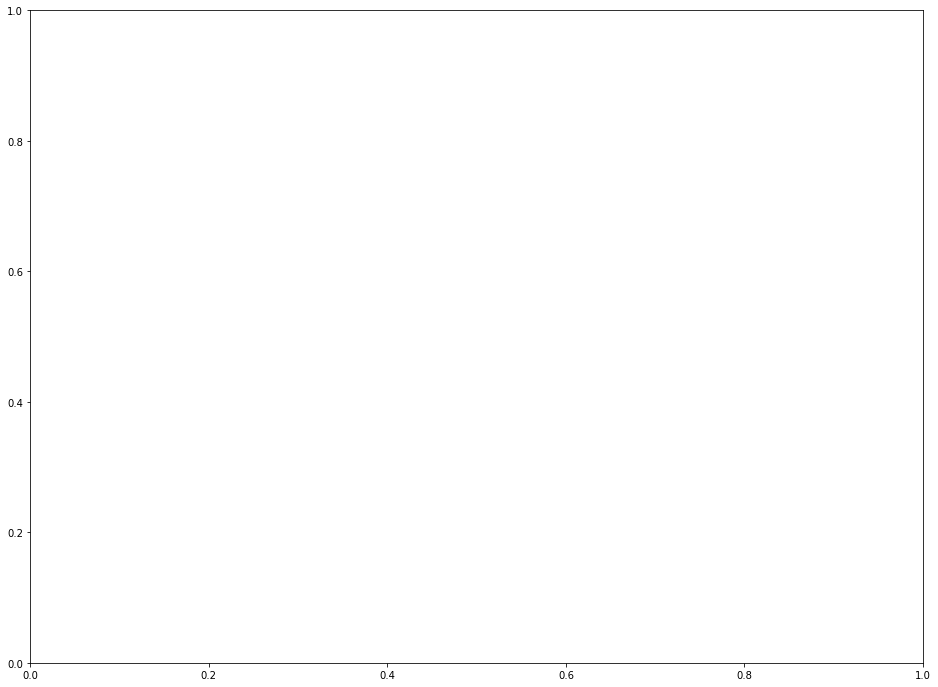

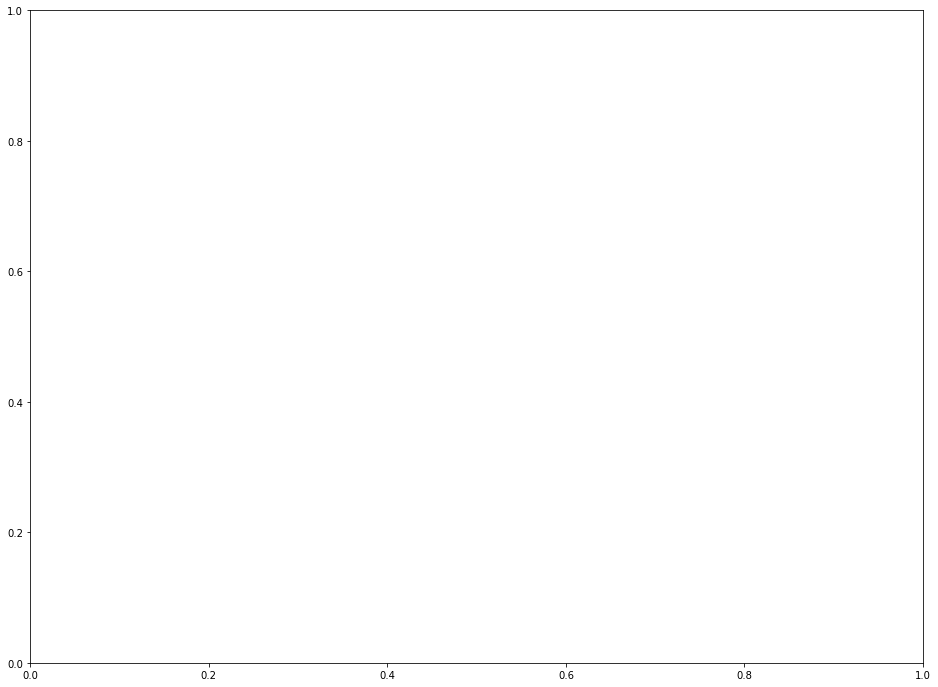

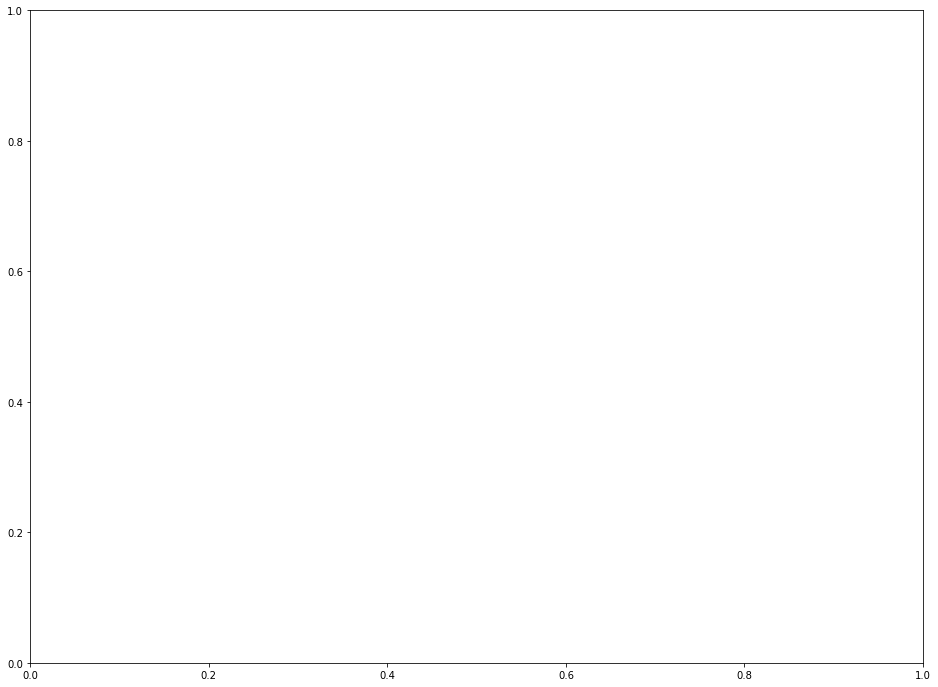

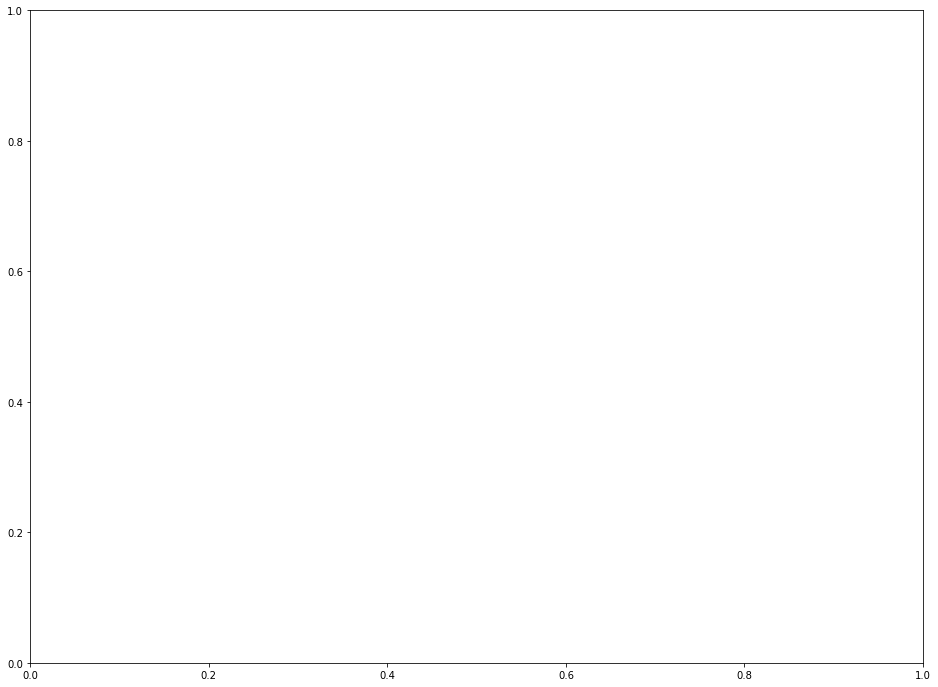

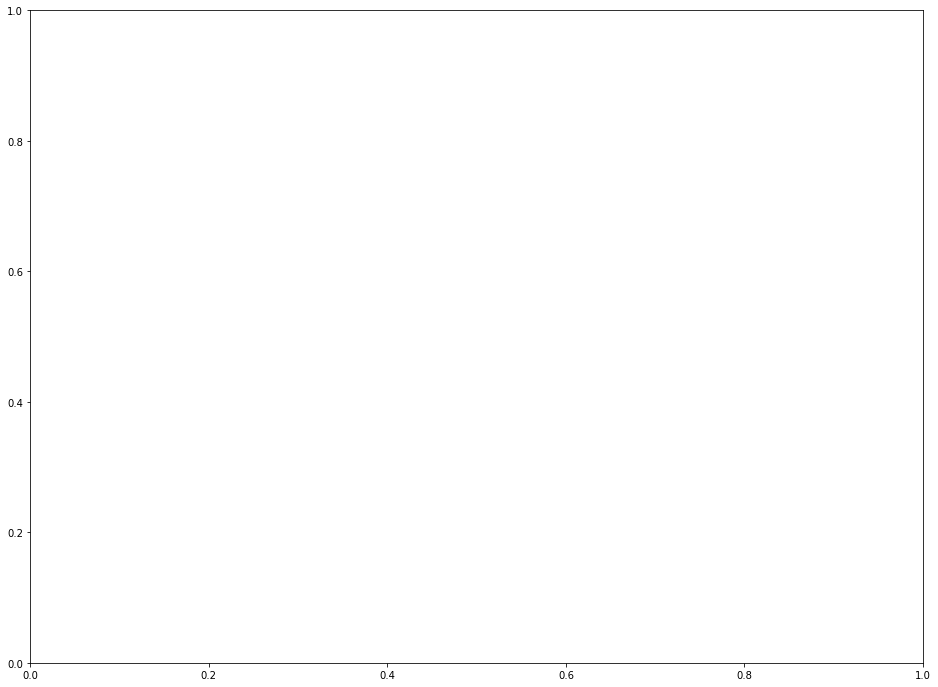

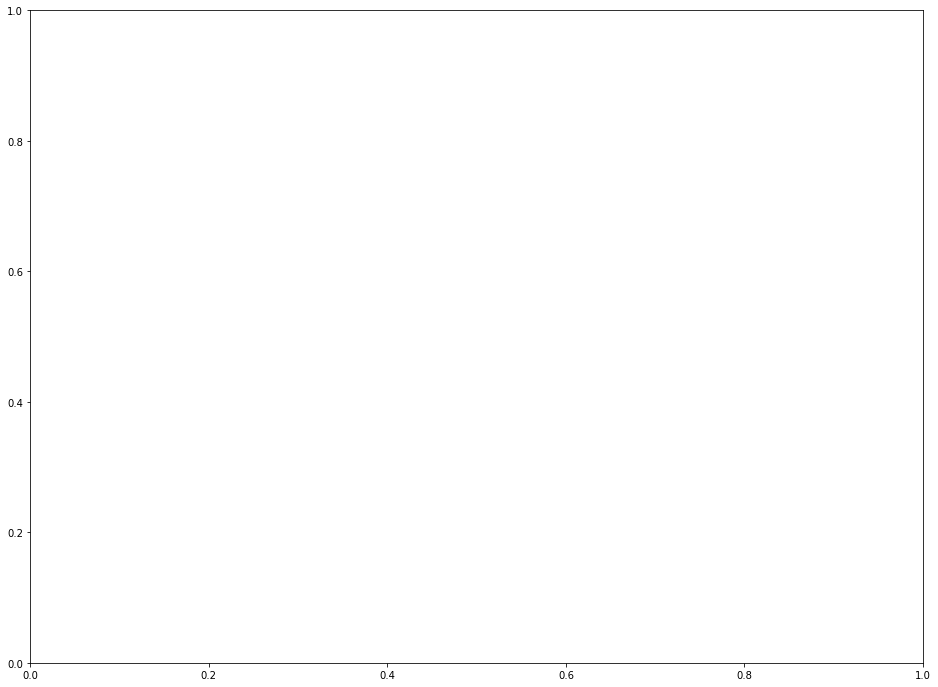

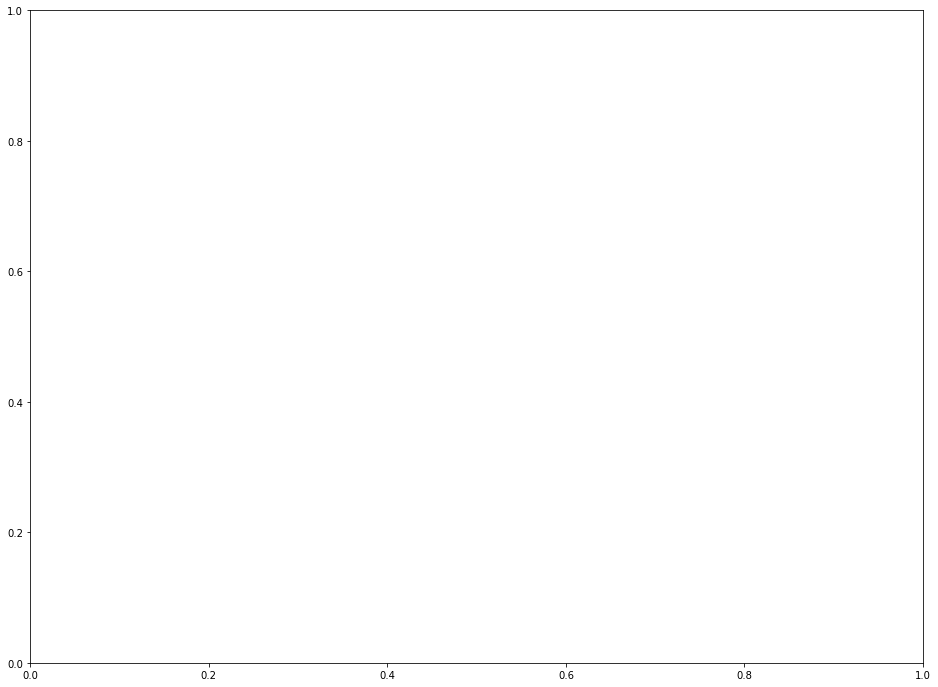

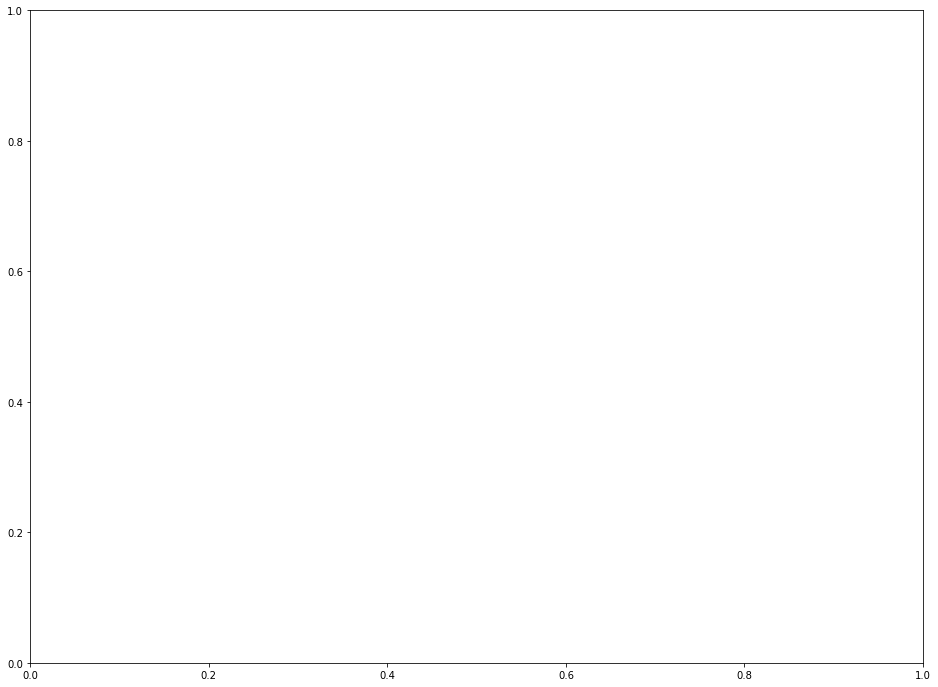

In [399]:
plotTsneAndSaveToFiles(df_marketing_lrate, 'lrate' + str(l_rate) + '_')

In [400]:
unscaled_df = unscaleData(scaler, scaled_df)